# ** IMPORT PACKAGES: **

In [ ]:
# python peripherals
import random
import os
import sys
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# skimage
import skimage.io
import skimage.color
import skimage.filters
import skimage.measure

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.networks import DeepSignatureCurvatureNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing
from deep_signature.linalg import euclidean_transform
from deep_signature.linalg import affine_transform
from deep_signature.stats import discrete_distribution

# common
from common import settings
from common import utils as common_utils

# notebooks
from notebooks.utils import utils as notebook_utils

# ipython
from IPython.display import display, HTML

# DISPLAY CURVES

In [ ]:
# curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
# limit = 3
# color_map = plt.get_cmap('rainbow', limit)
# for i, curve in enumerate(curves[:limit]): 
#     fig, ax = plt.subplots(1, 1, figsize=(20,10))
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(30)
#     ax.axis('equal')
#     notebook_utils.plot_curve(ax=ax, curve=curve, linewidth=5)
#     plt.show()

# LOAD IMAGE PATHS

In [ ]:
image_file_paths = []
# images_base_dir_path = os.path.normpath(settings.images_dir_path)
images_base_dir_path = os.path.normpath(f'C:\deep-signature-data\images_shutterstock')

for sub_dir_path, _, file_names in os.walk(images_base_dir_path):
    if sub_dir_path == images_base_dir_path:
        continue

    for file_name in file_names:
        image_file_path = os.path.normpath(os.path.join(sub_dir_path, file_name))
        image_file_paths.append(image_file_path)

# DISPLAY CONTOURS

In [ ]:
sigma = 16
contour_level=0.5
min_points=500
max_points=20000
max_abs_kappa=40
flat_point_threshold=1e-3
max_flat_points_ratio=0.03
eps = 1e-12
# numpy.random.seed(0)

found = False
while True:
    image_file_path_index = int(numpy.random.randint(len(image_file_paths), size=1))
    image_file_path = image_file_paths[image_file_path_index]
    try:
        image = skimage.io.imread(image_file_path)
    except:
        continue
    gray_image = skimage.color.rgb2gray(image)
    gray_image_filtered = skimage.filters.gaussian(gray_image, sigma=sigma)
    contours = skimage.measure.find_contours(gray_image_filtered, contour_level)
    contours = [contour for contour in contours if min_points <= contour.shape[0] <= max_points]
    contours.sort(key=lambda contour: contour.shape[0], reverse=True)
    for contour in contours:
        first_point = contour[0]
        last_point = contour[-1]
        distance = numpy.linalg.norm(x=first_point - last_point, ord=2)
        if distance > eps:
            continue

        curve = curve_processing.smooth_curve(
            curve=contour,
            iterations=6,
            window_length=99,
            poly_order=2)

        kappa = curve_processing.calculate_euclidean_curvature(curve)
        min_kappa = numpy.abs(numpy.min(kappa))
        max_kappa = numpy.abs(numpy.max(kappa))
        flat_points = numpy.sum(numpy.array([1 if x < flat_point_threshold else 0 for x in numpy.abs(kappa)]))
        flat_points_ratio = flat_points / len(kappa)

        if min_kappa > max_abs_kappa:
            continue

        if max_kappa > max_abs_kappa:
            continue

        if flat_points_ratio > max_flat_points_ratio:
            continue

        found = True
        break

    if found is True:
        break

figsize=(20,20)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image)
ax.axis('off')

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(gray_image, cmap=plt.cm.gray)
ax.axis('off')

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(gray_image_filtered, cmap=plt.cm.gray)
ax.axis('off')

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(gray_image_filtered, cmap=plt.cm.gray)
ax.plot(curve[:, 1], curve[:, 0], linewidth=10)
ax.axis('off')

plt.show()

curve = curve_processing.center_curve(curve=curve)
curve_copy = curve.copy()
curve[:, 1] = -curve_copy[:, 0]
curve[:, 0] = curve_copy[:, 1]

# PLOT CURVATURE SAMPLES

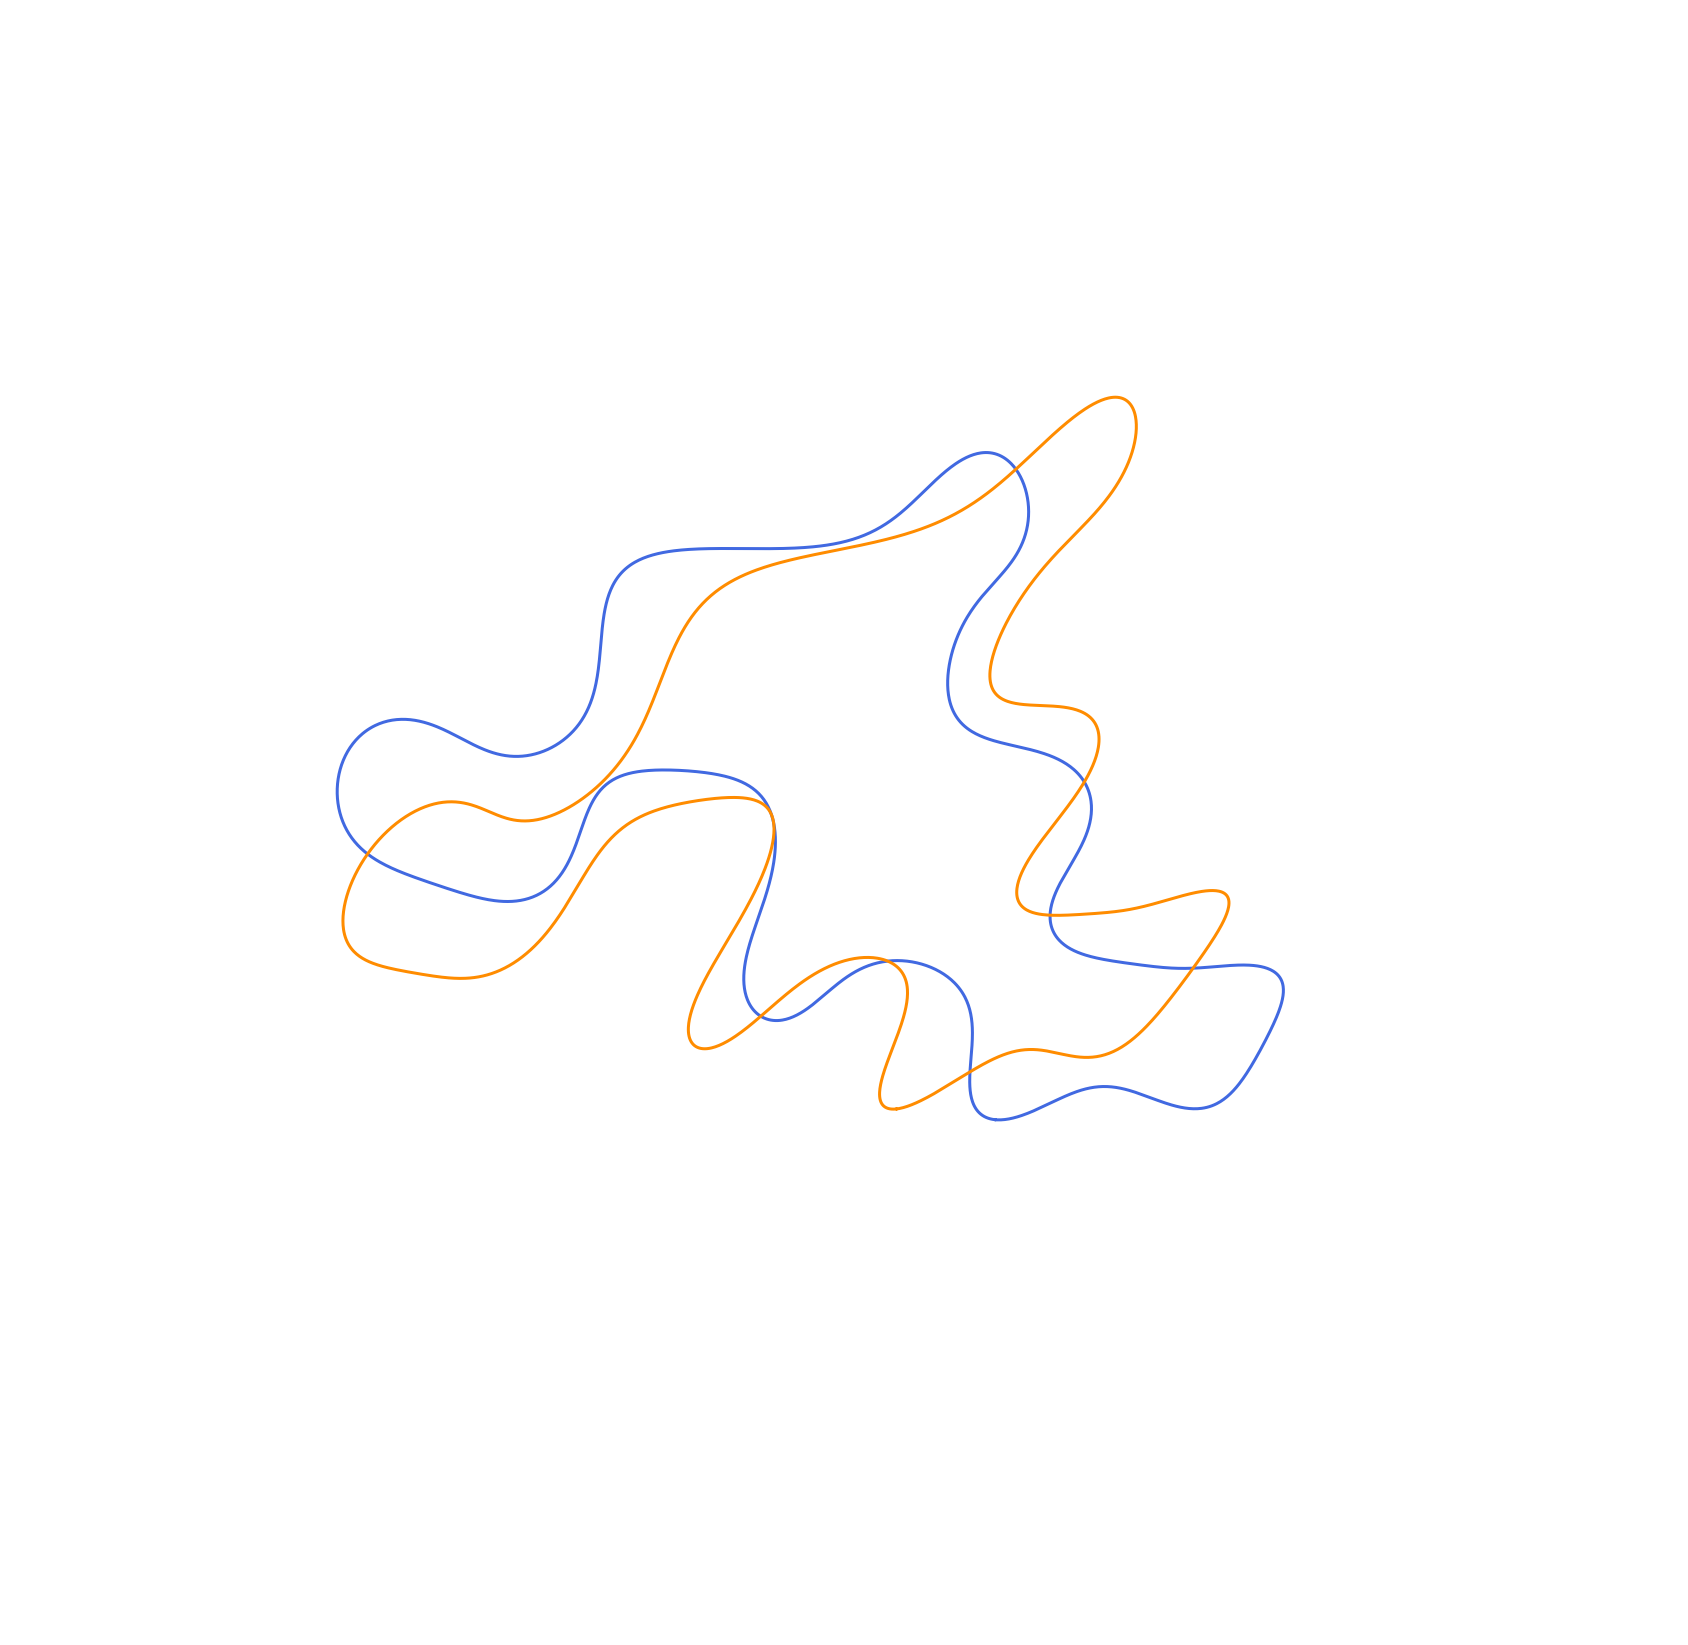

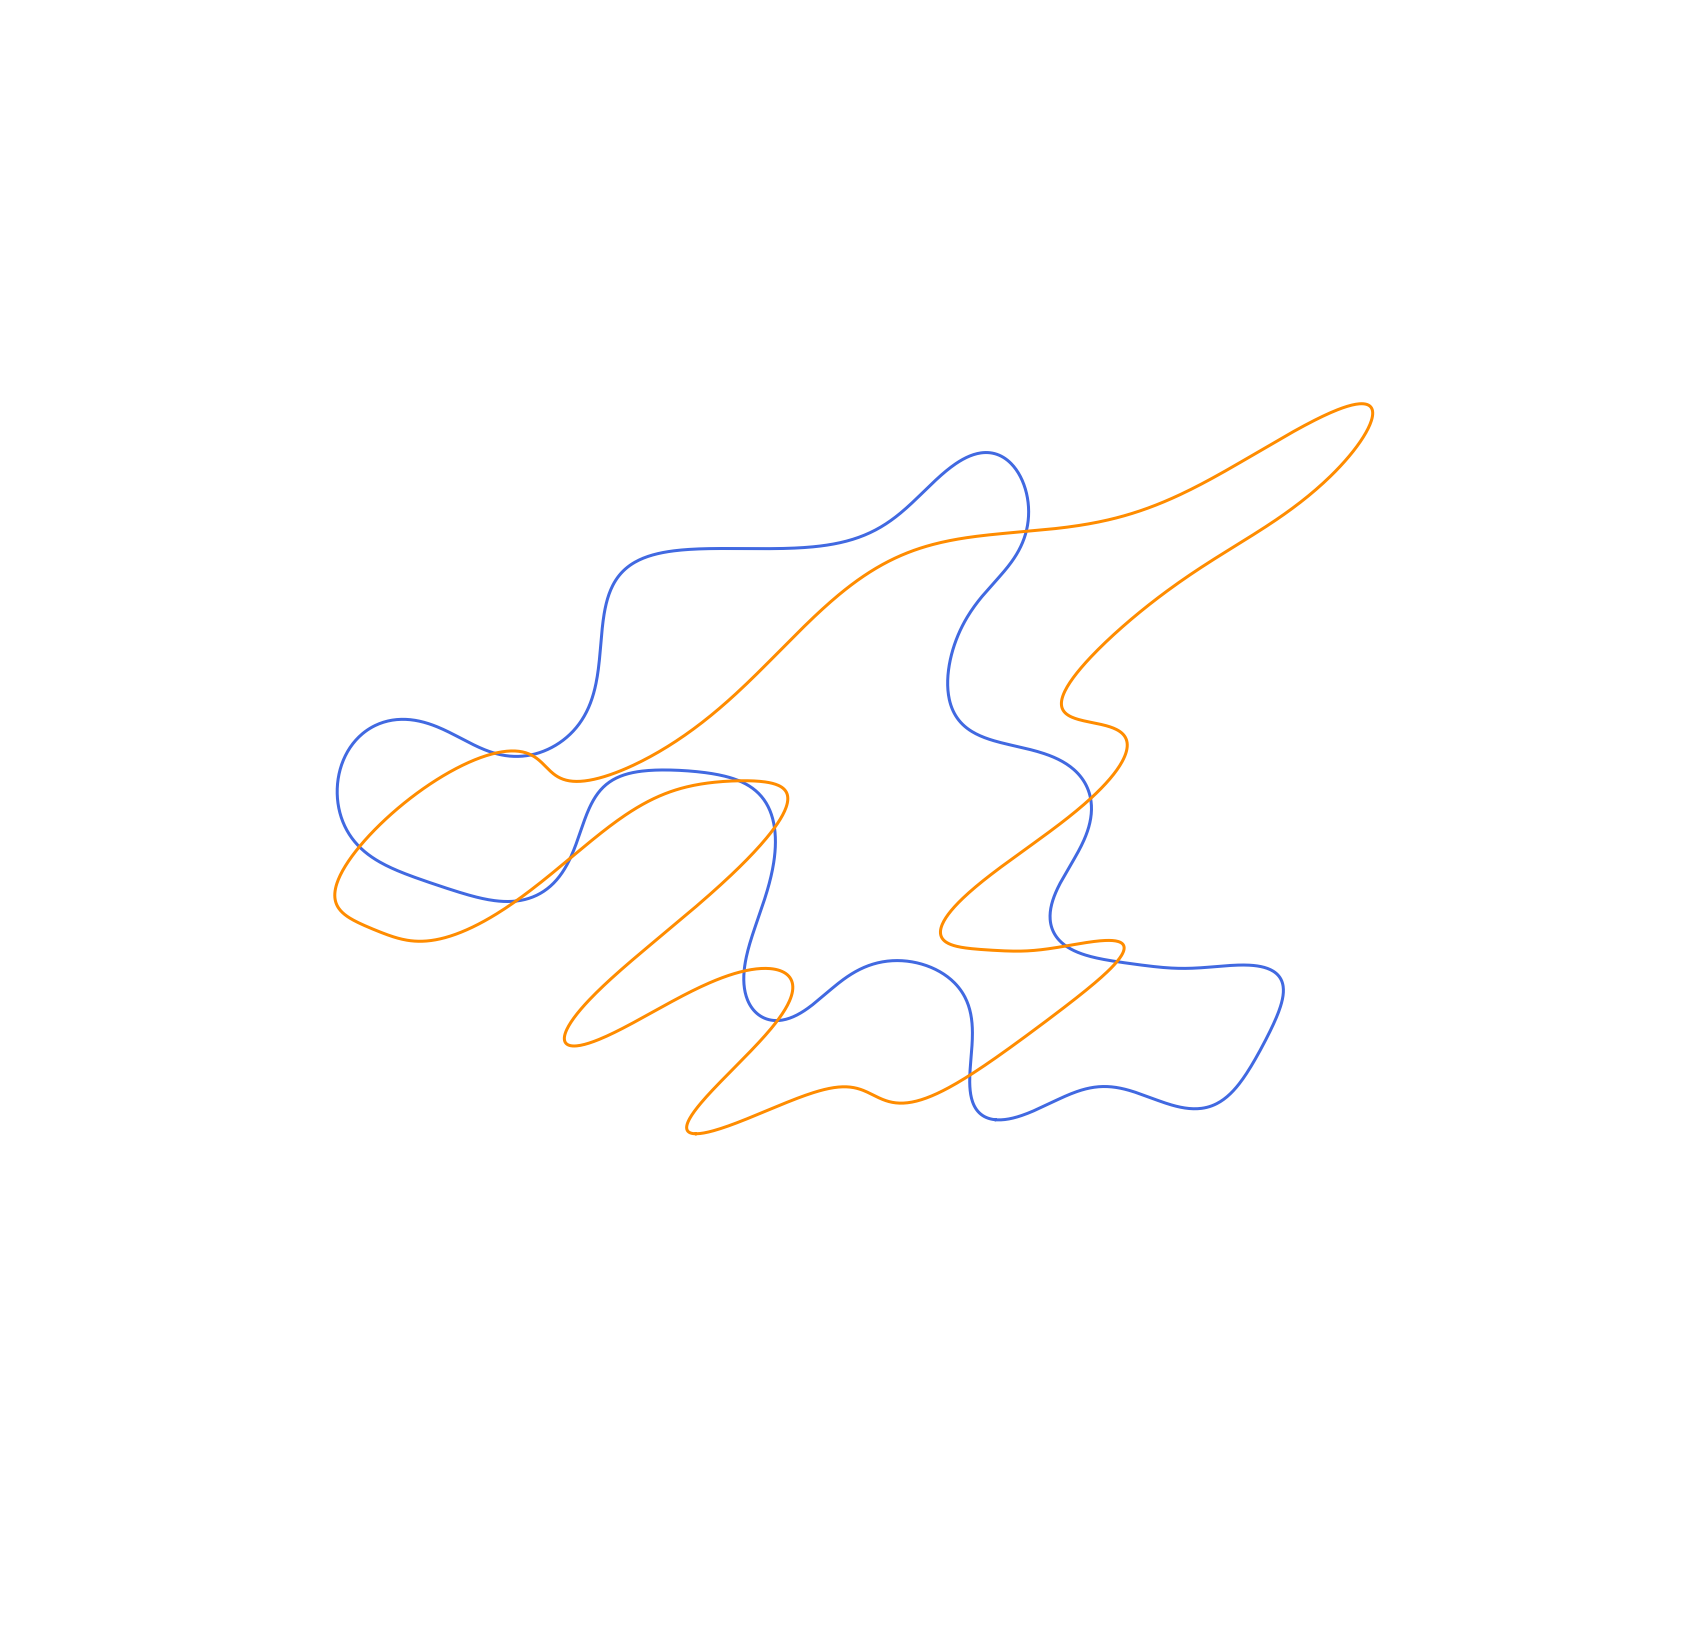

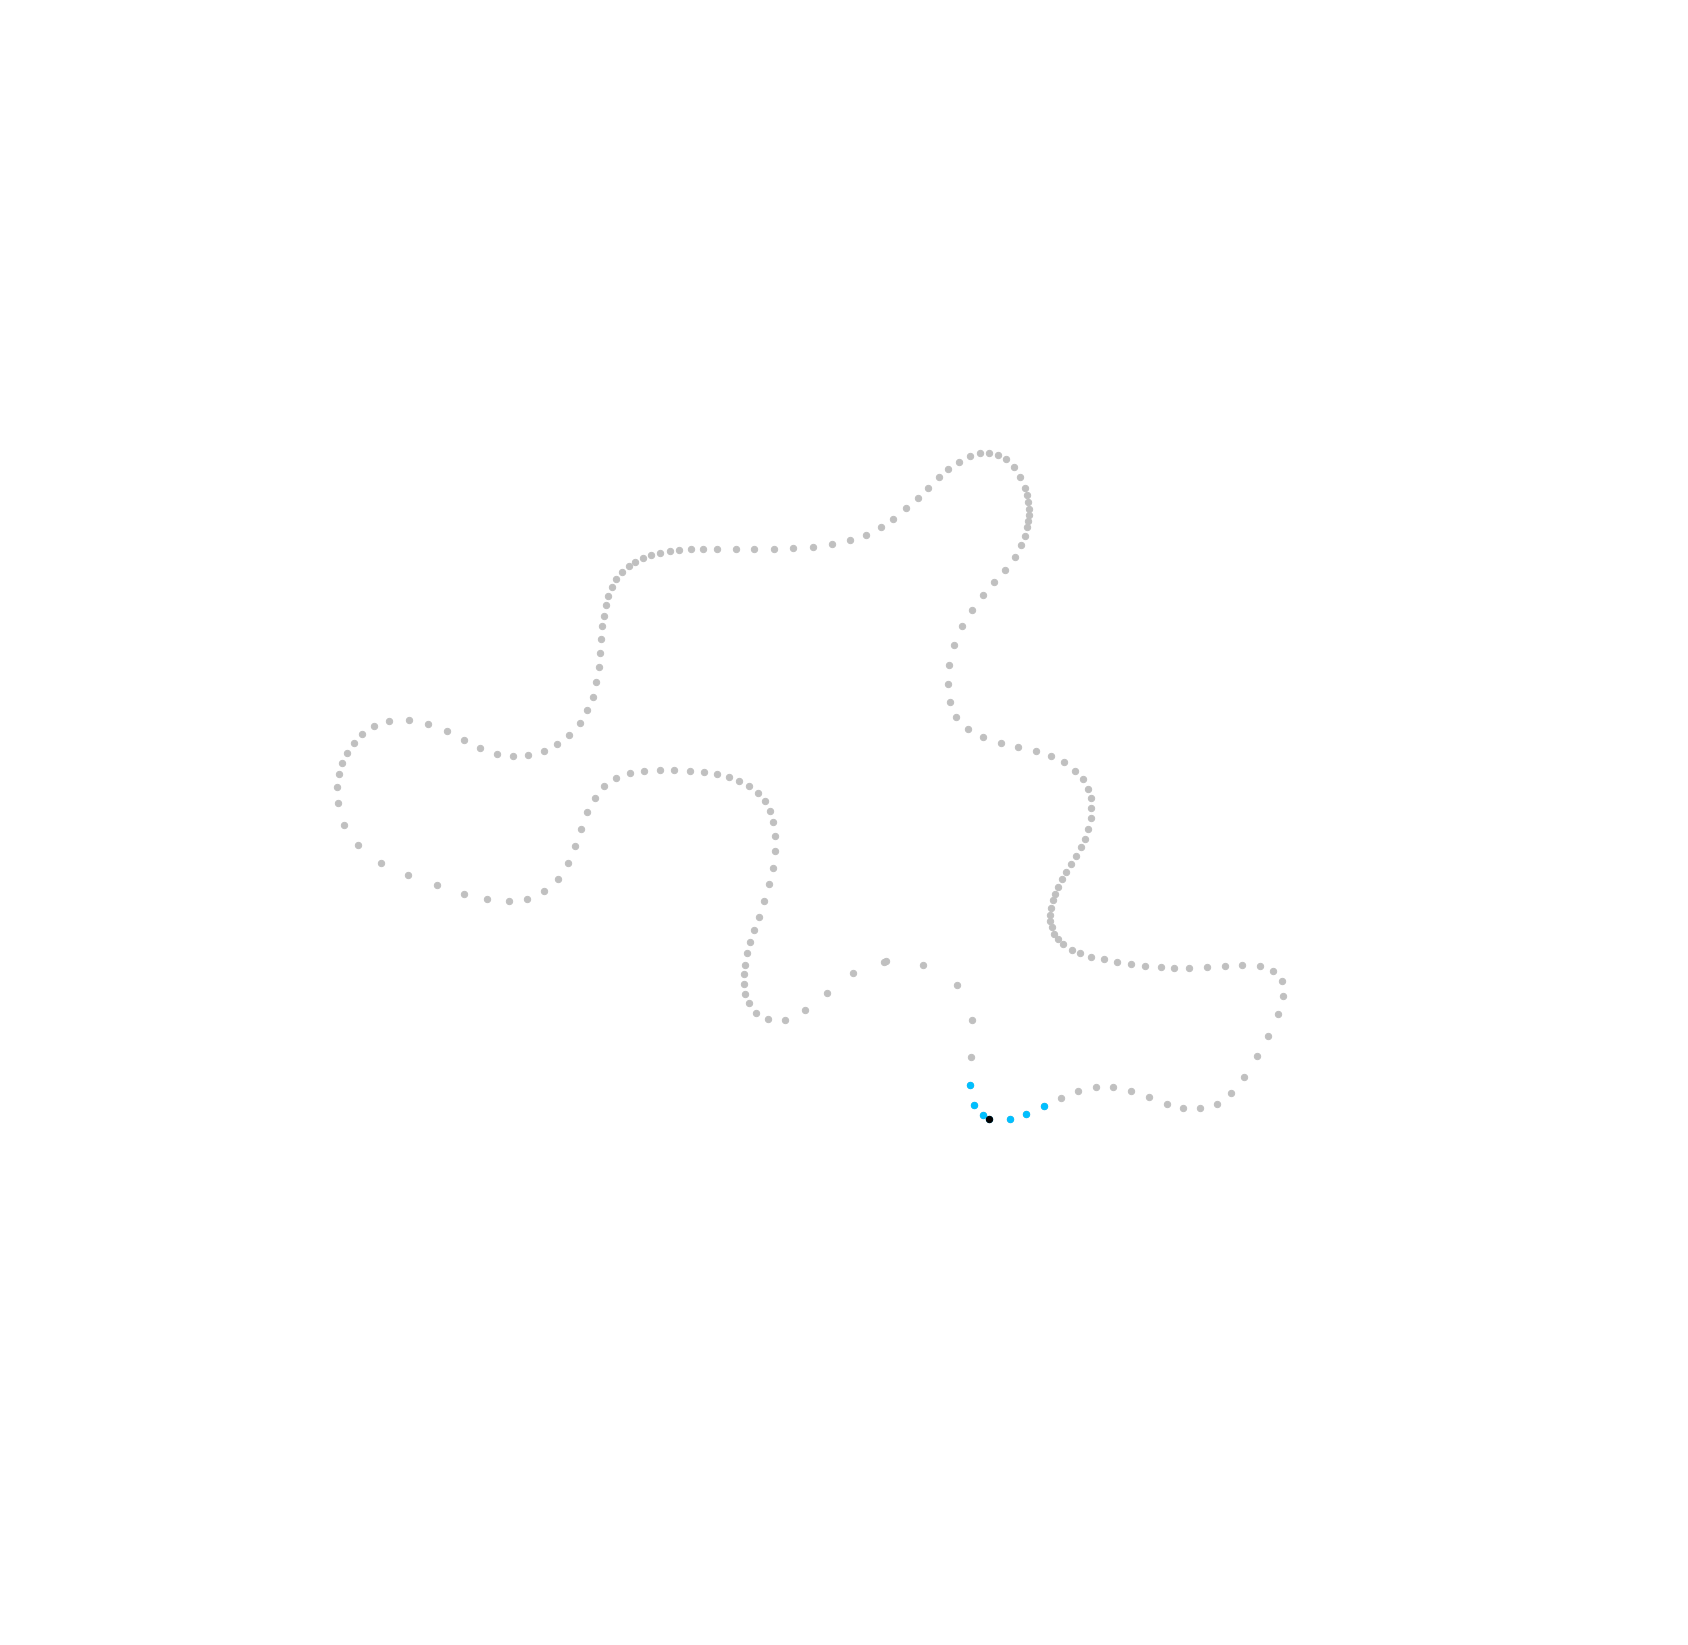

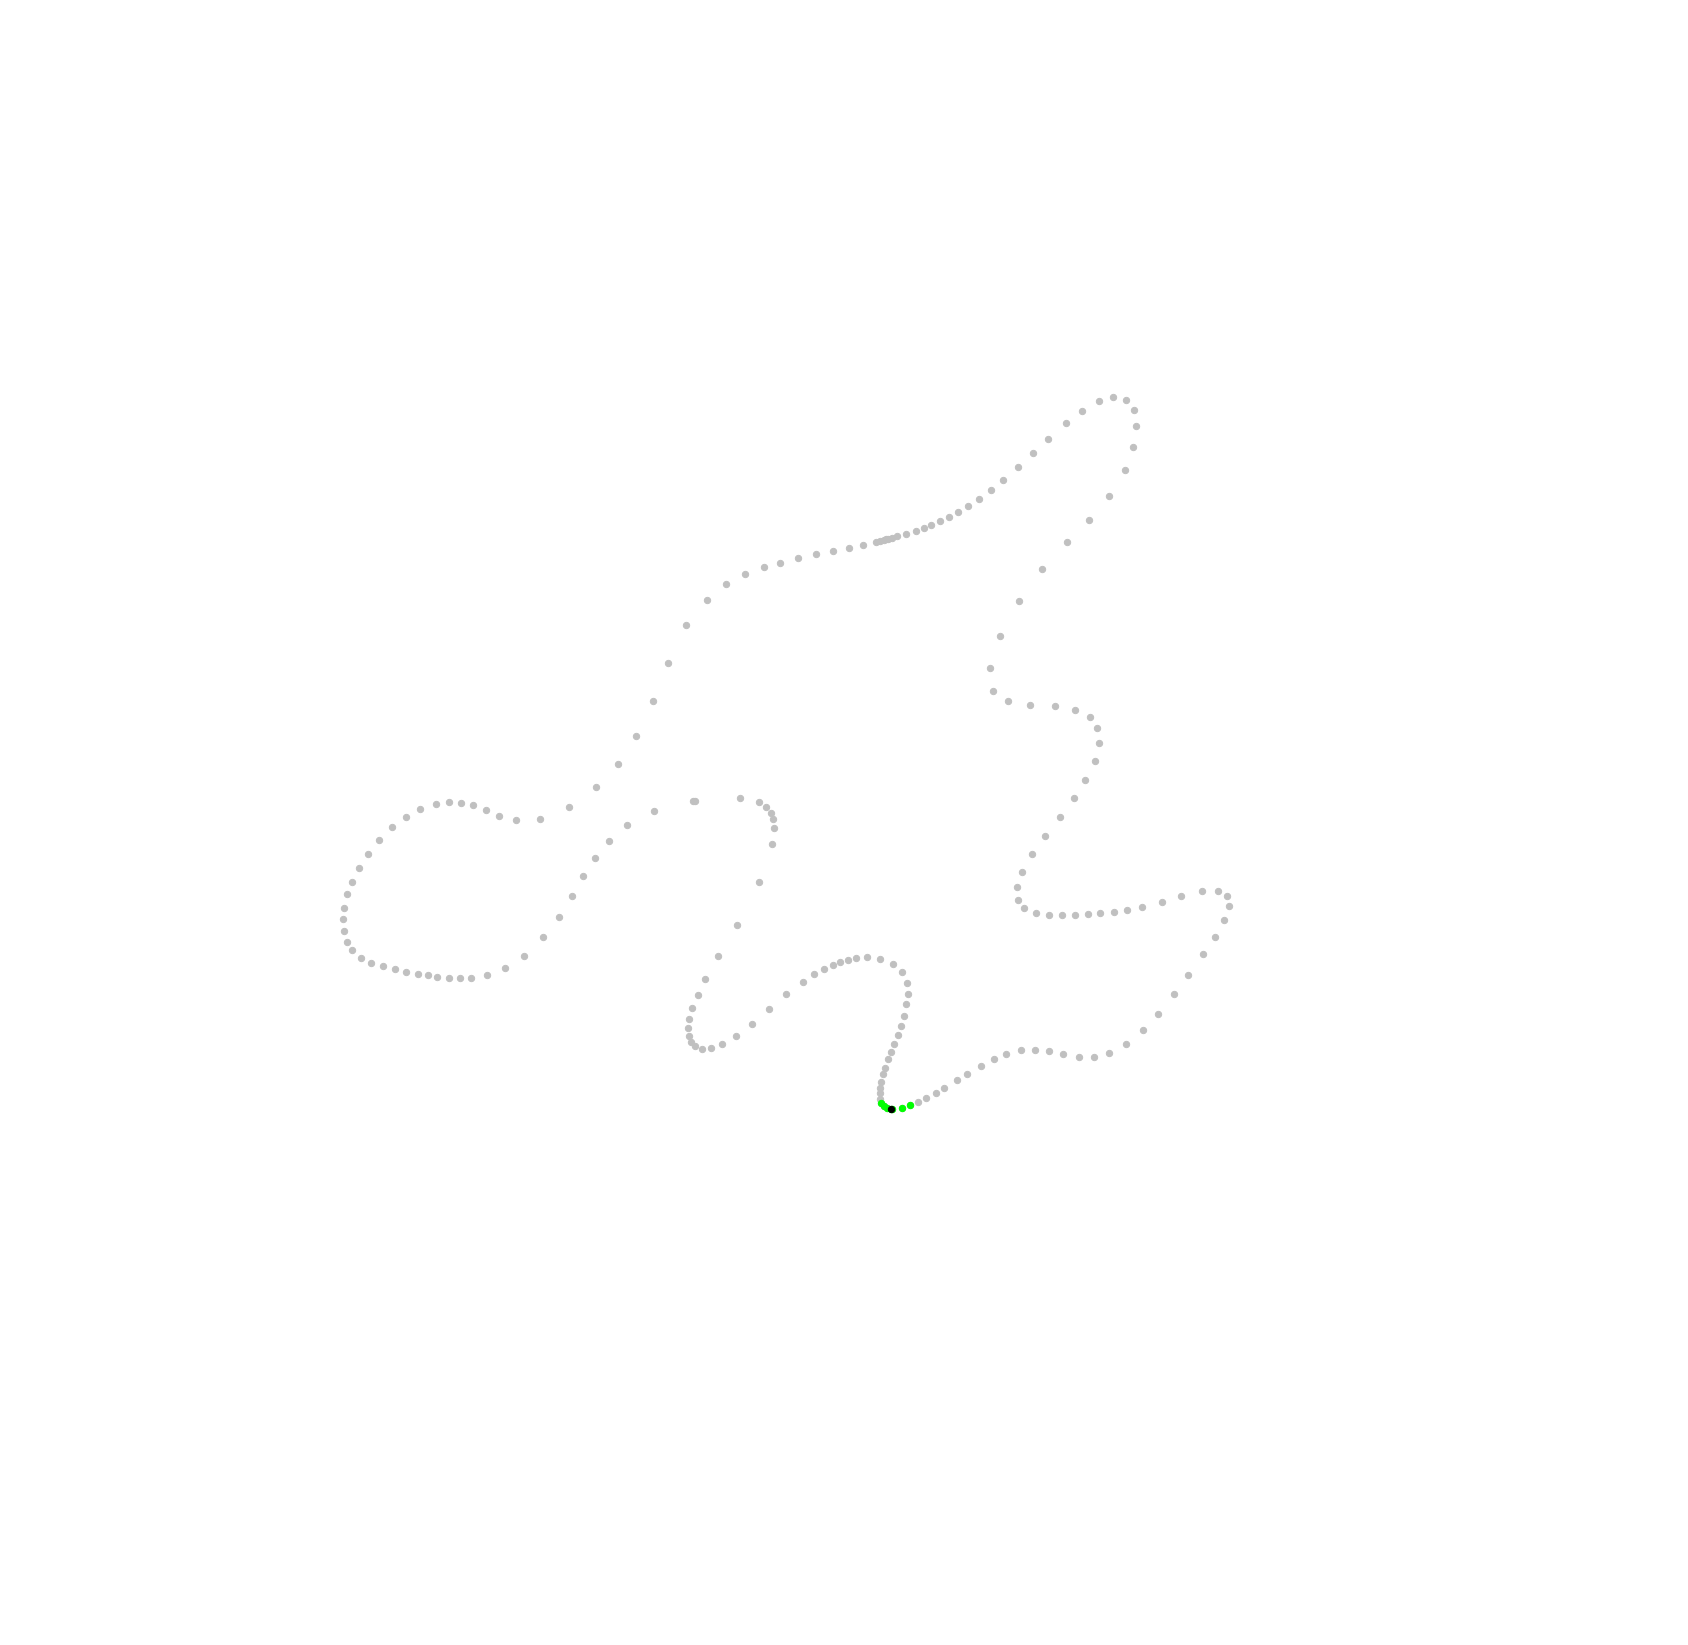

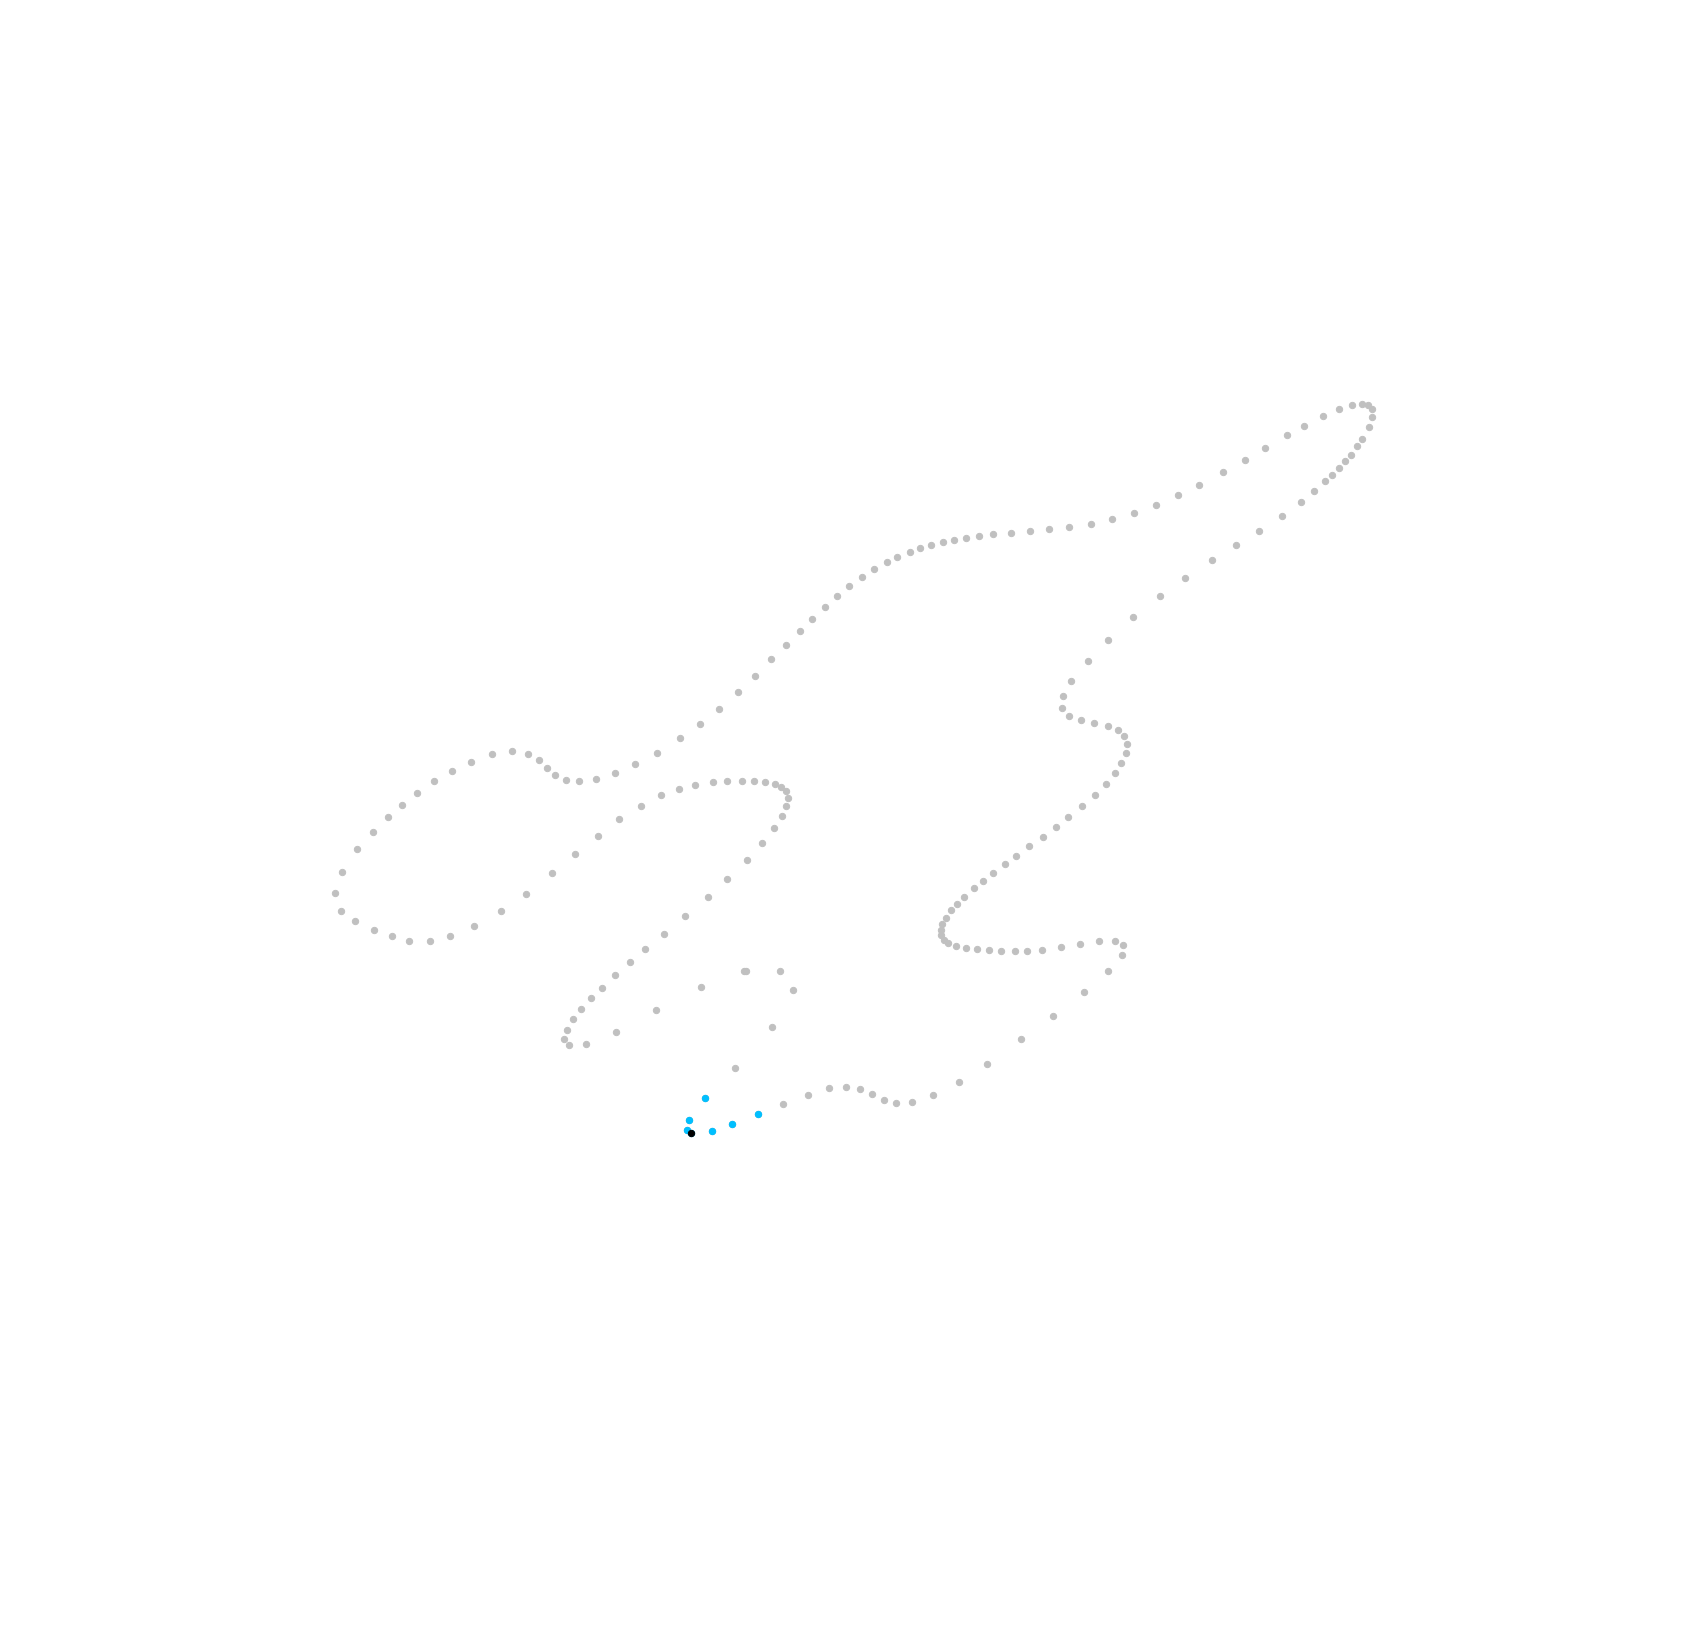

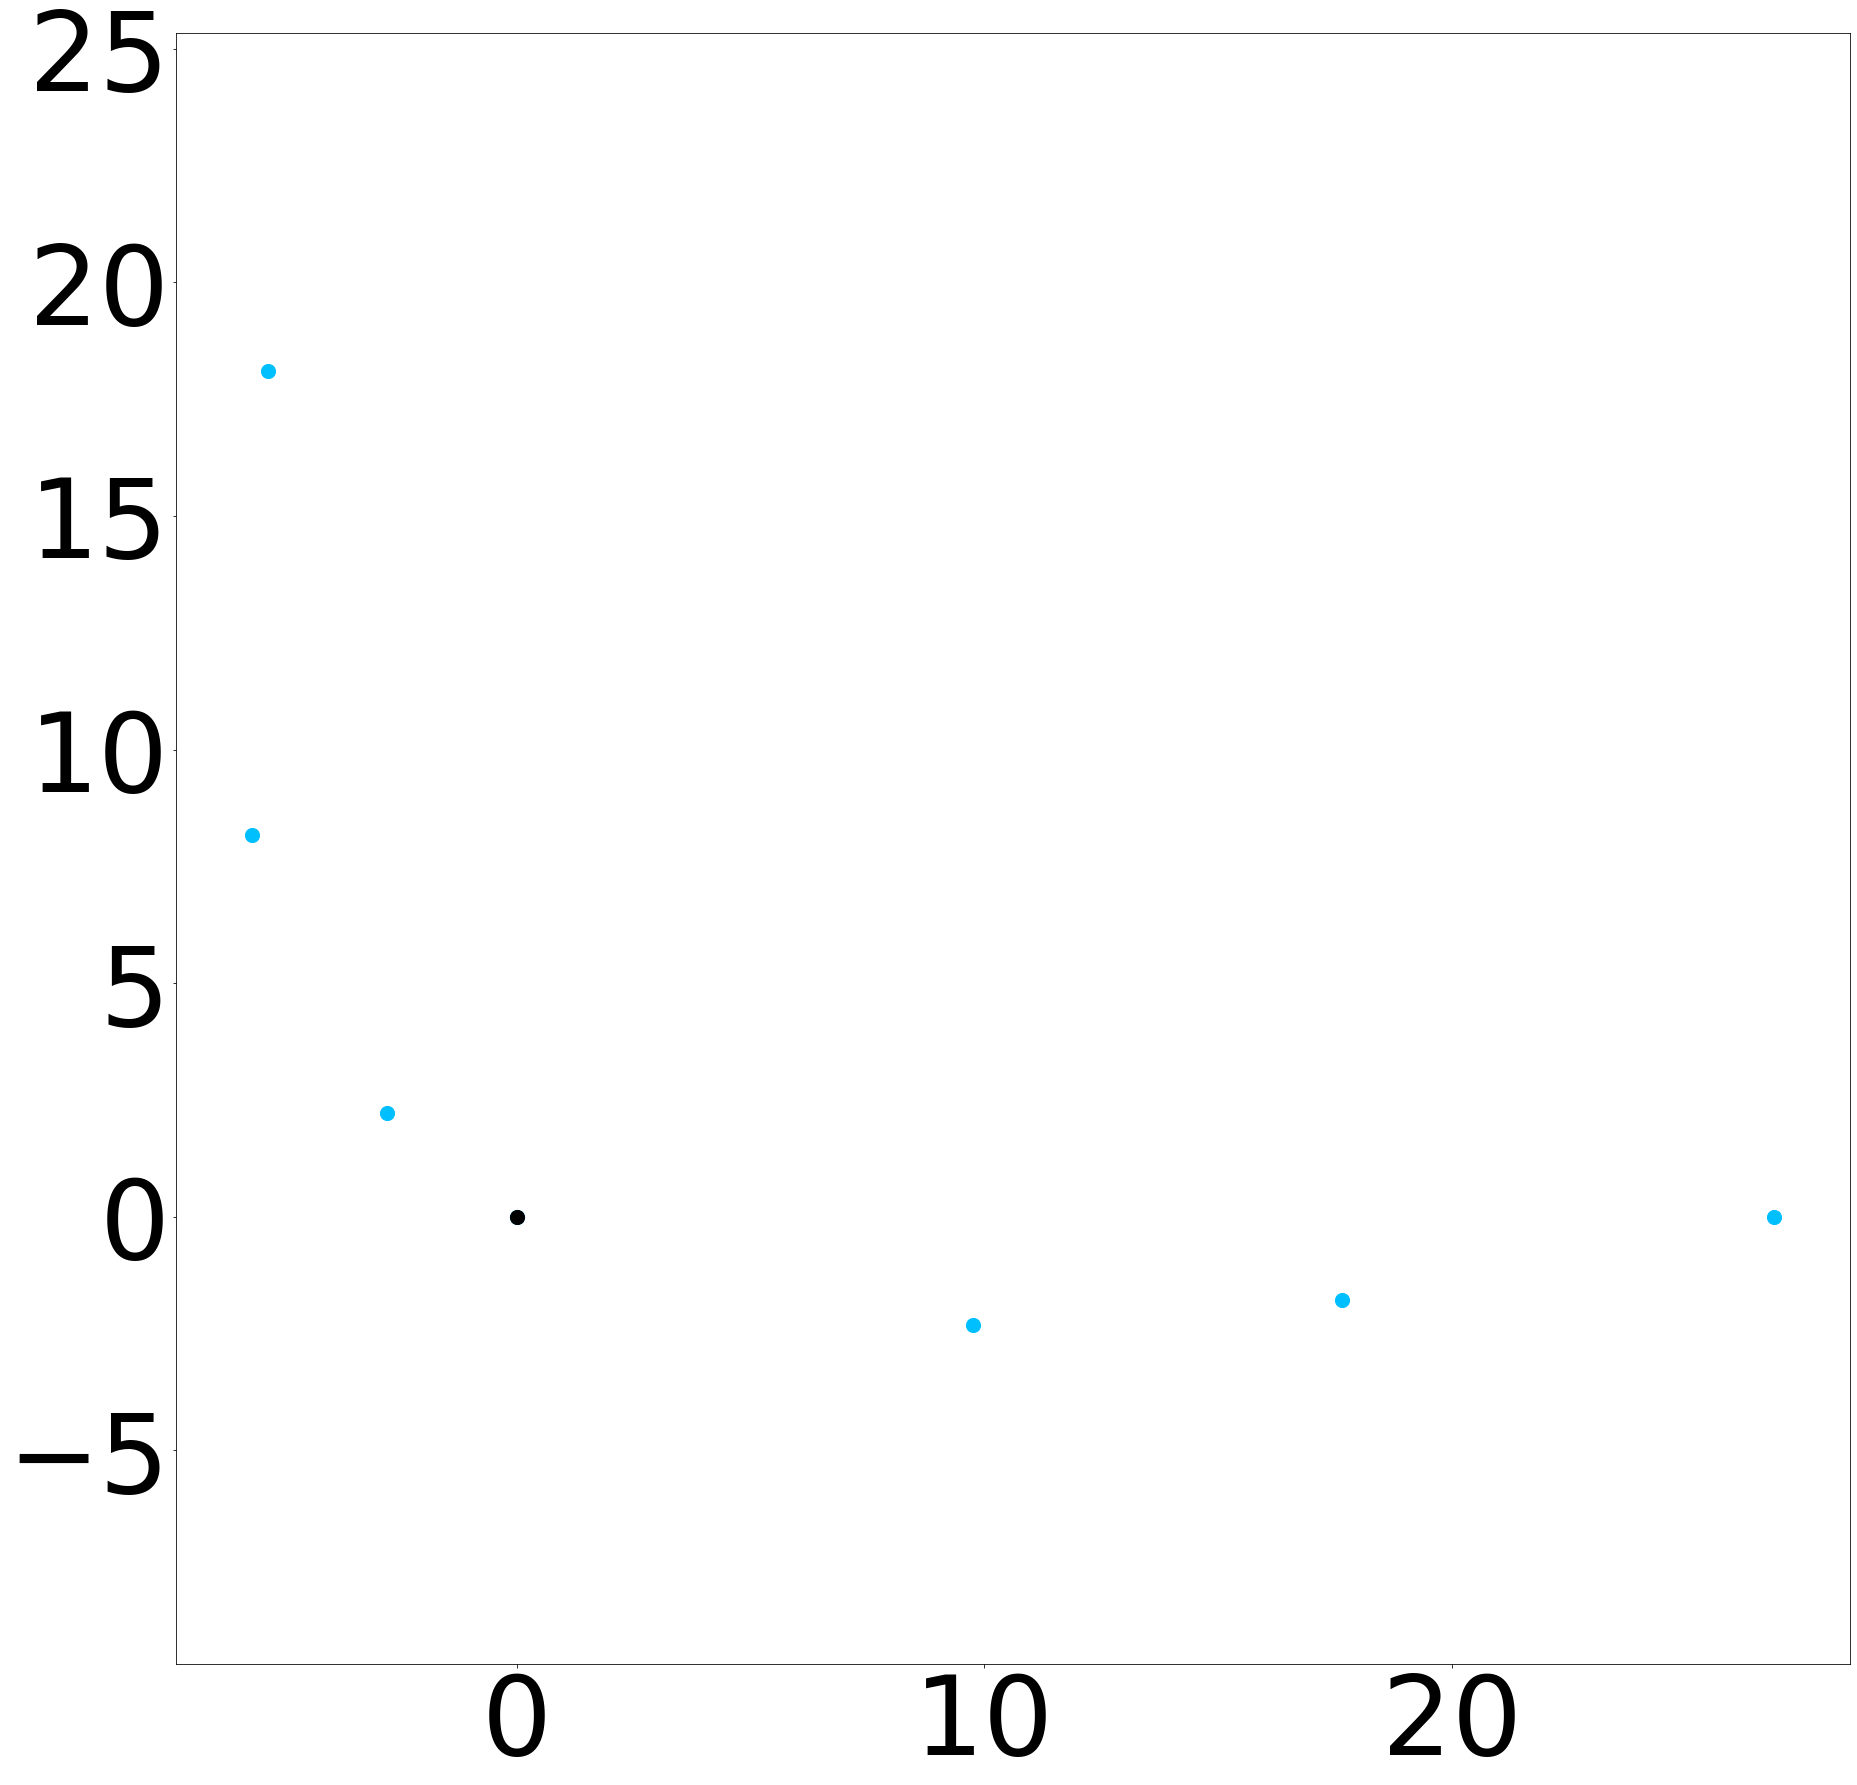

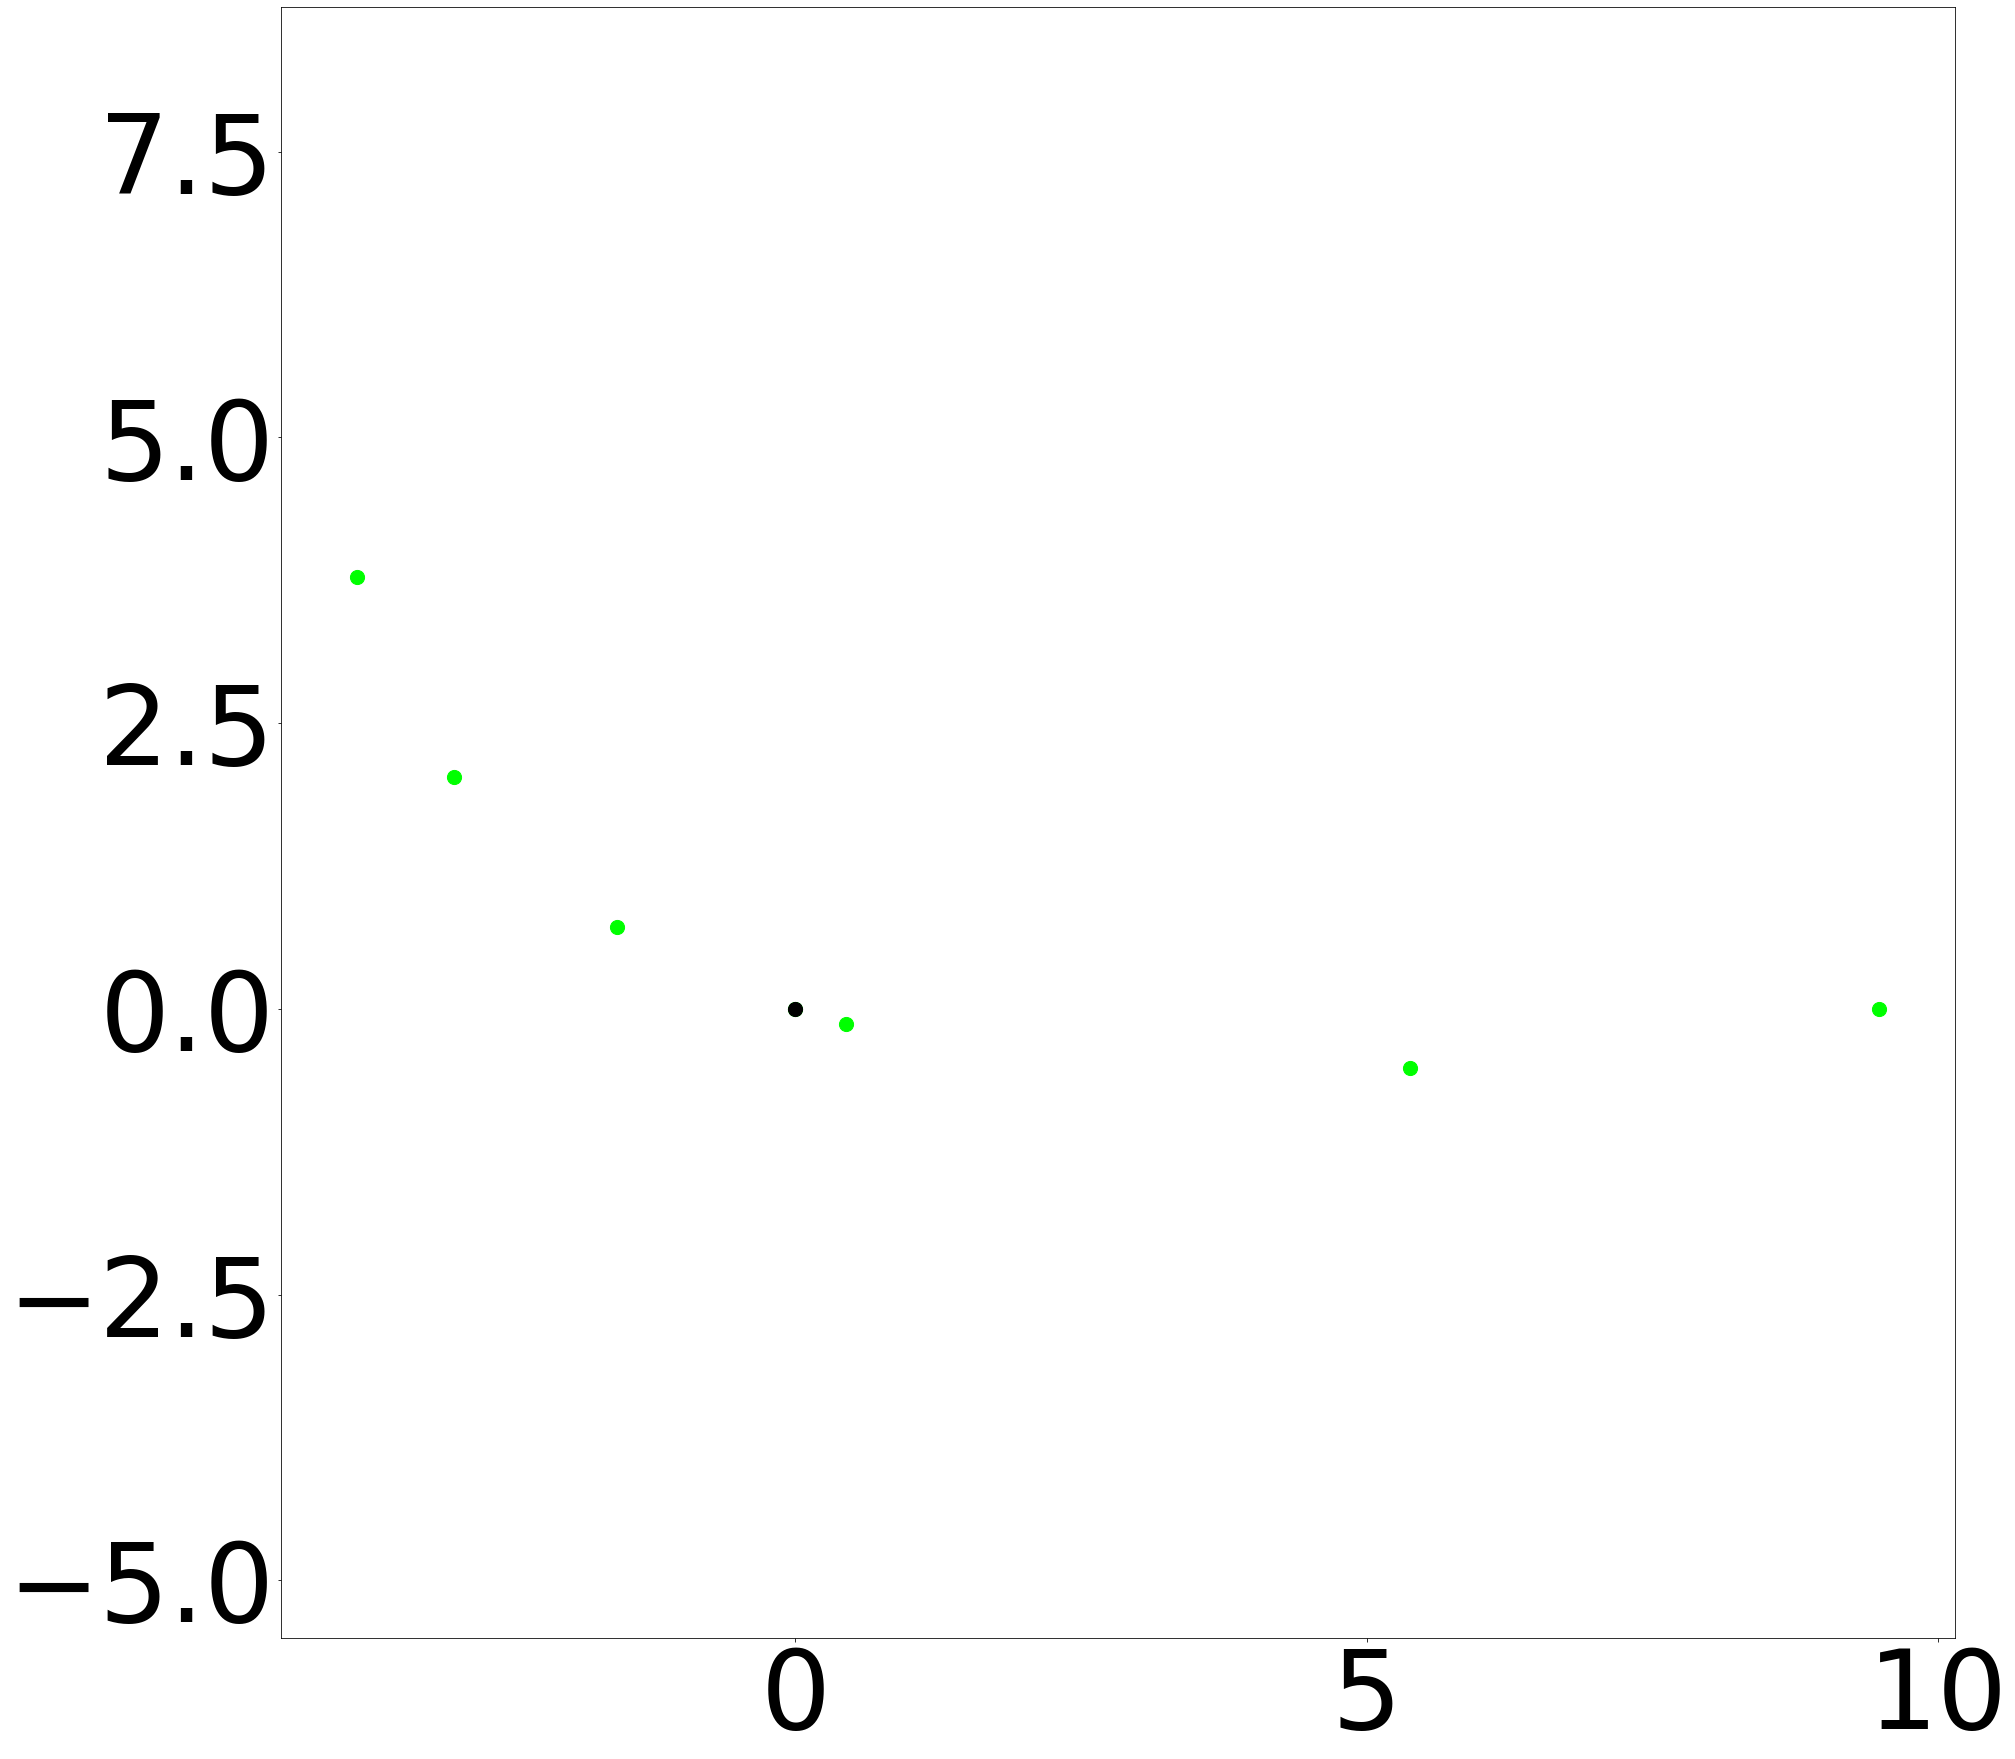

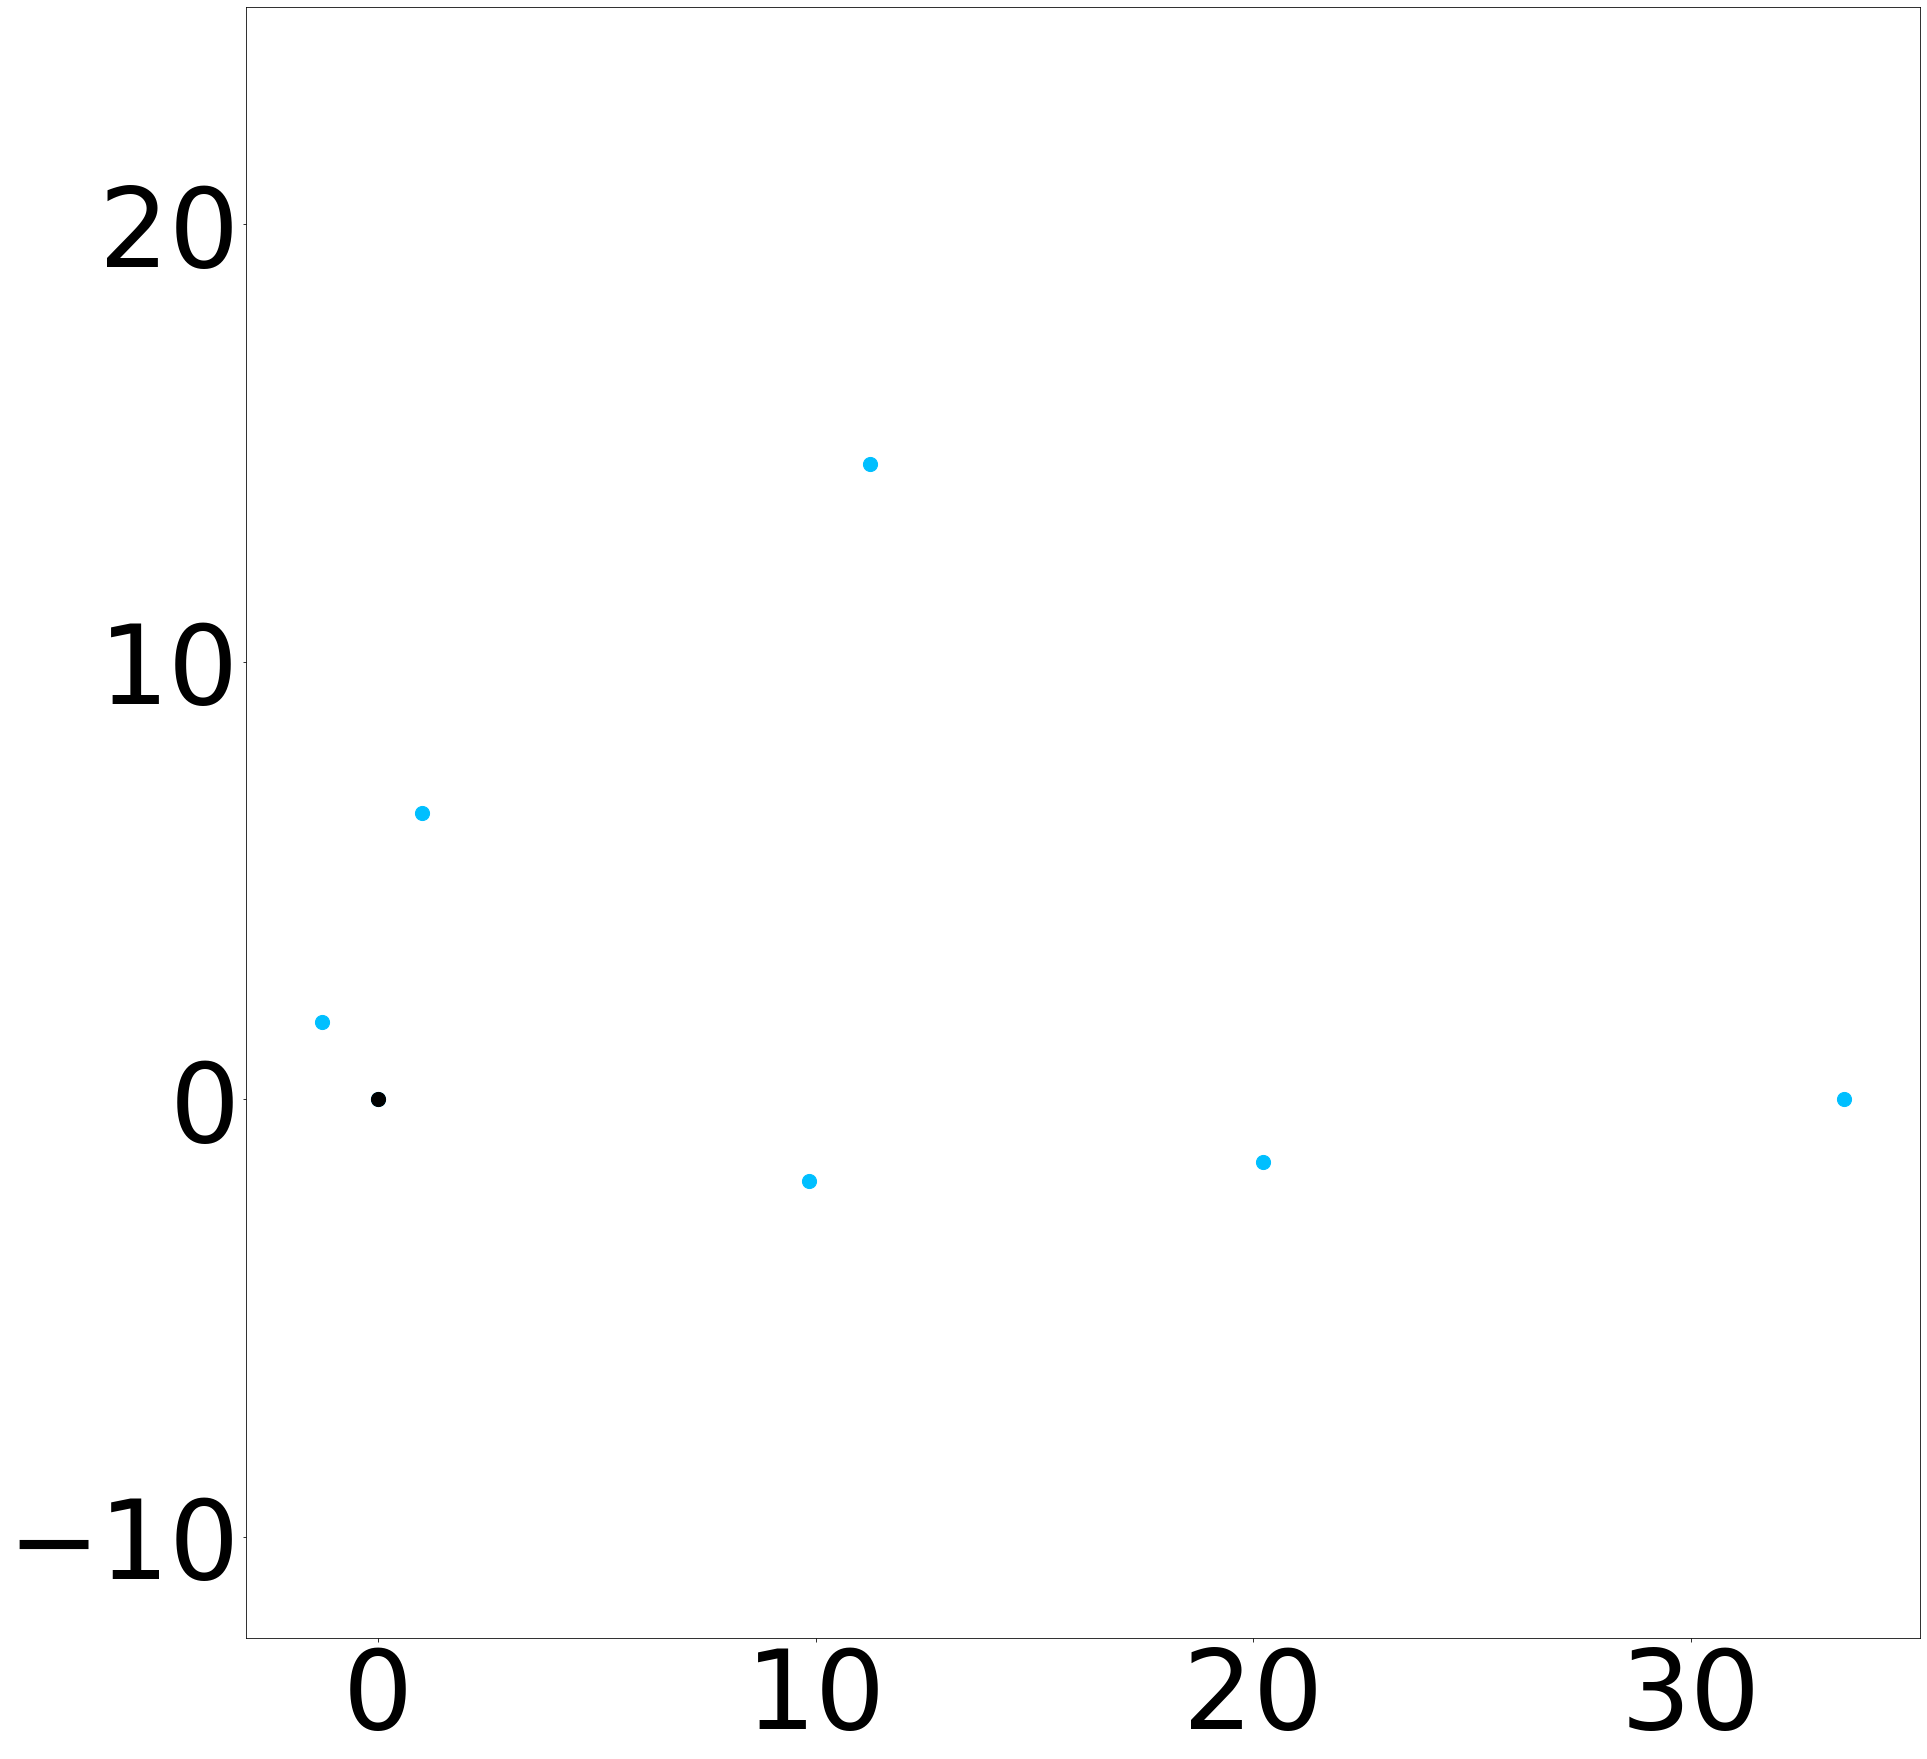

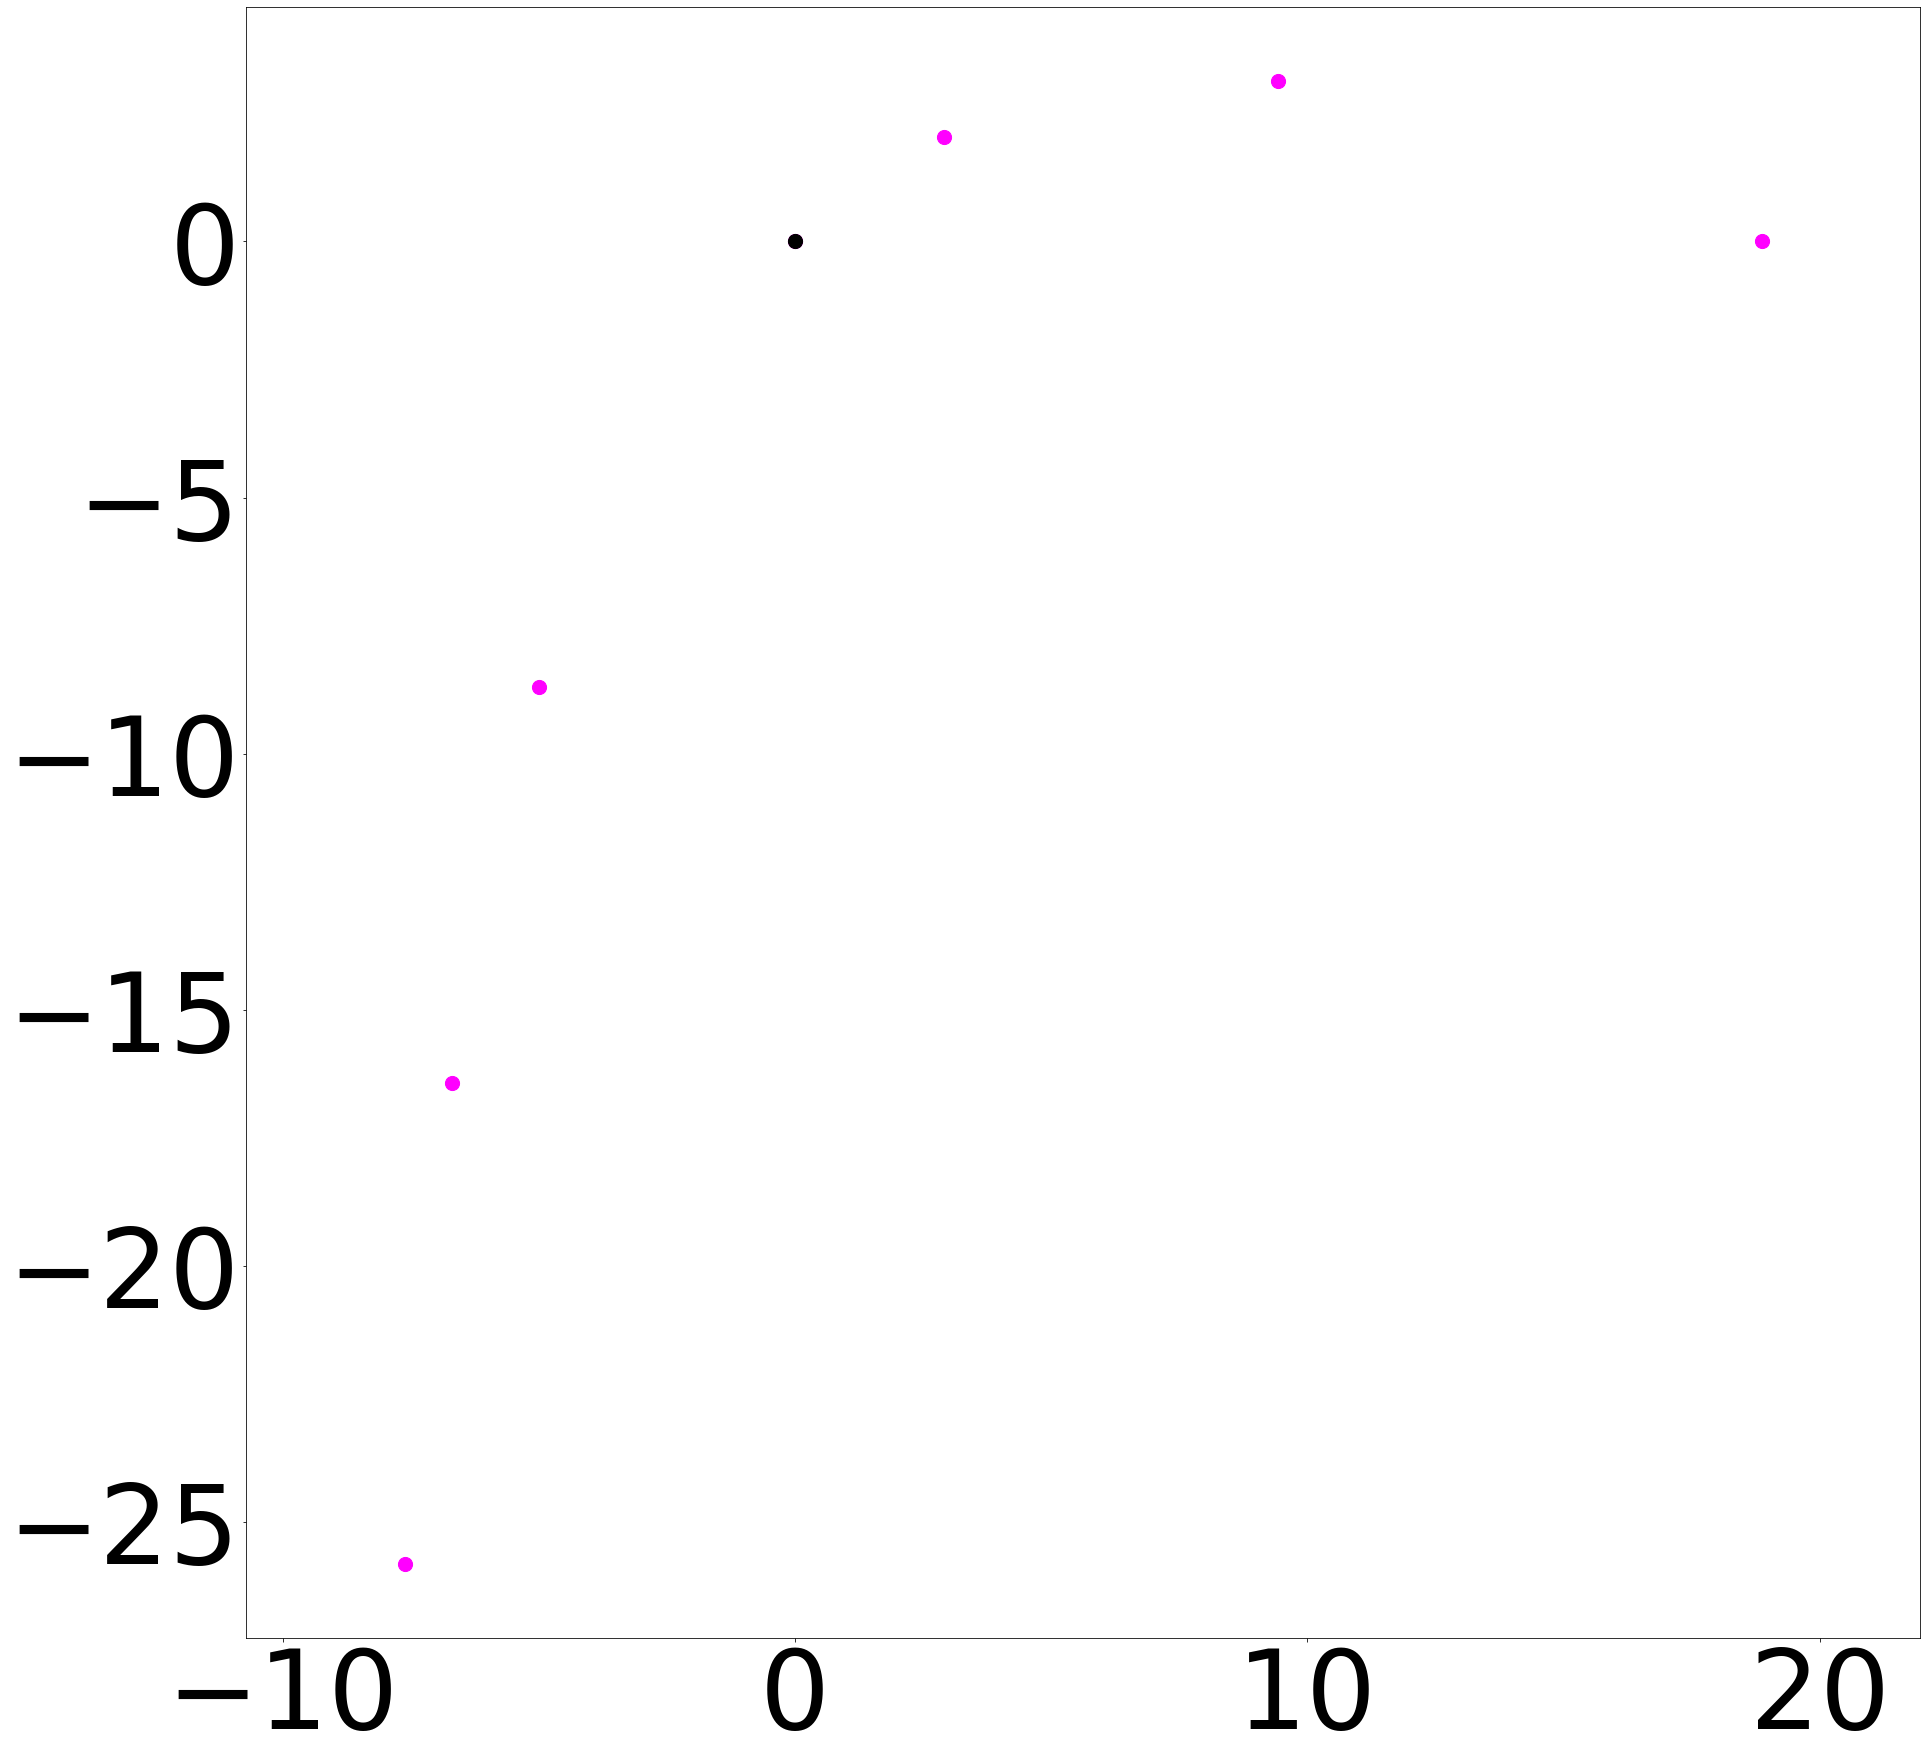

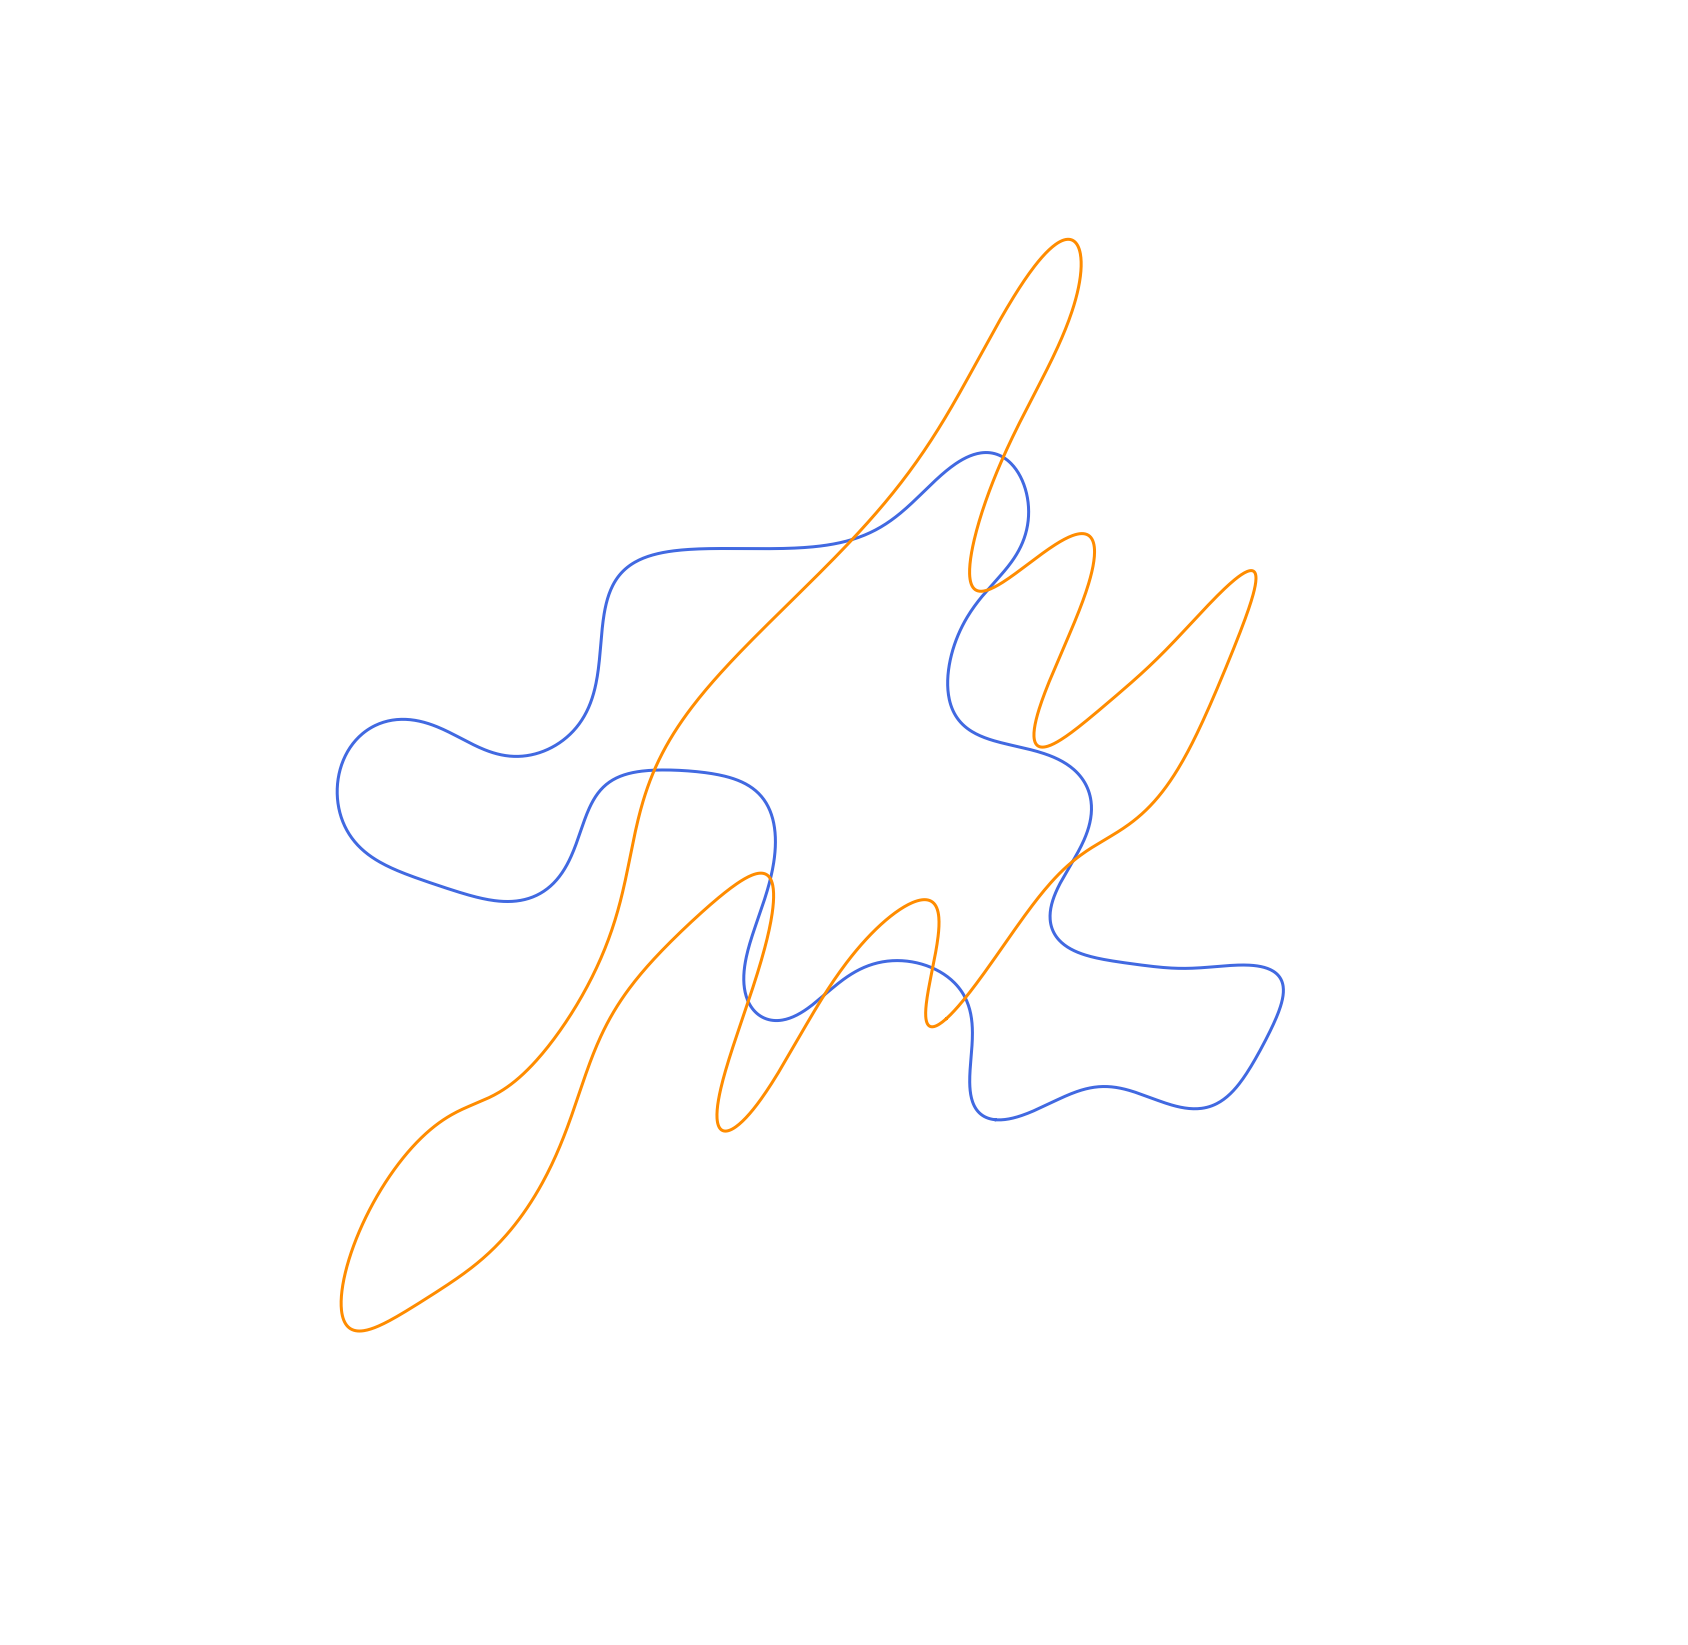

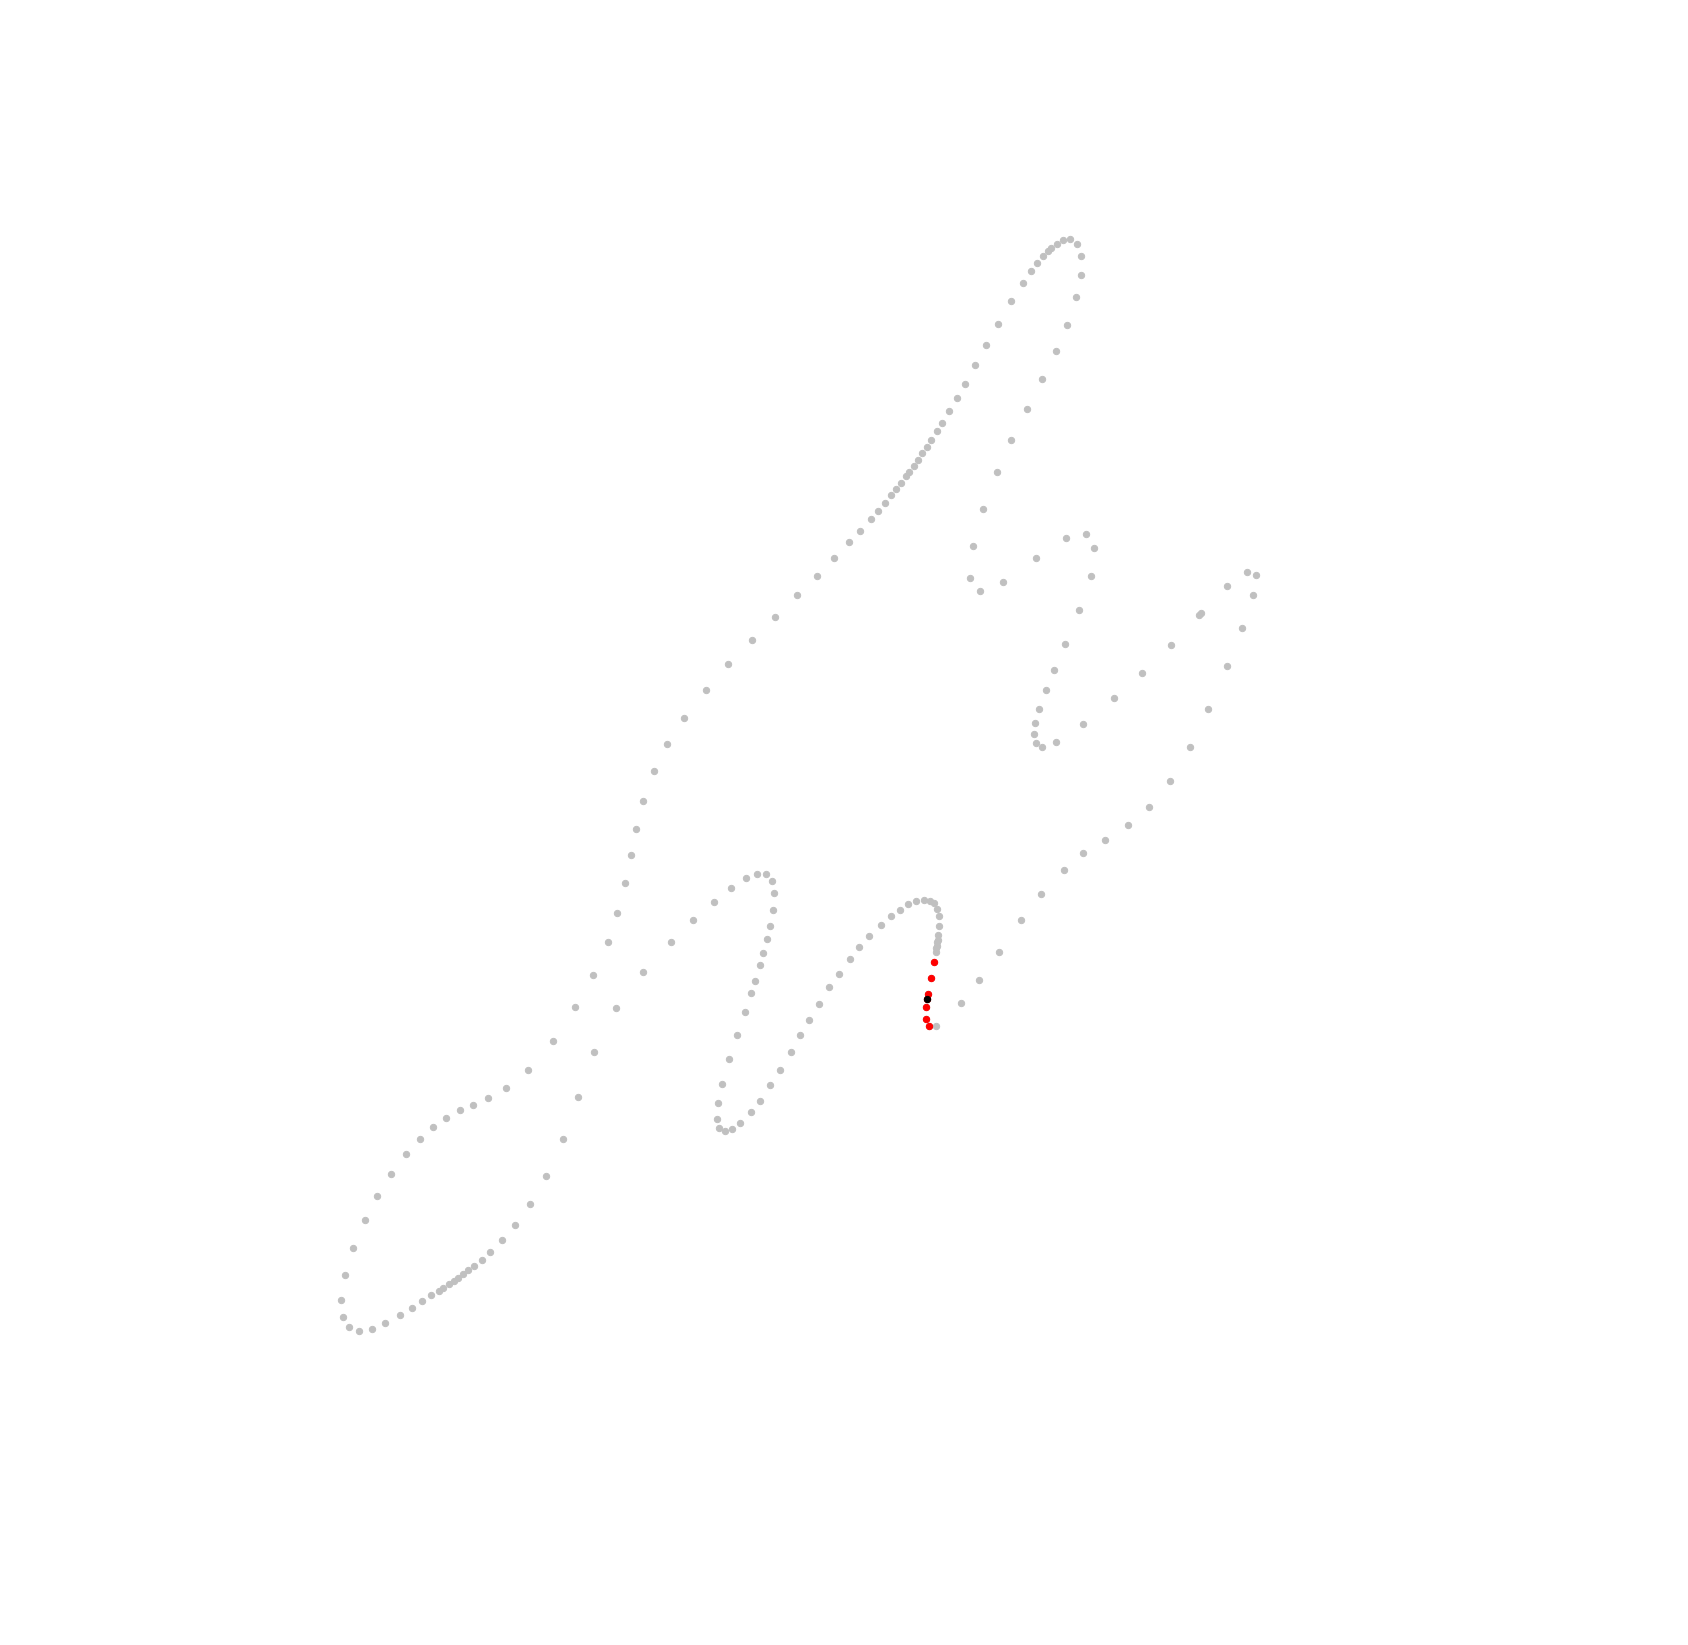

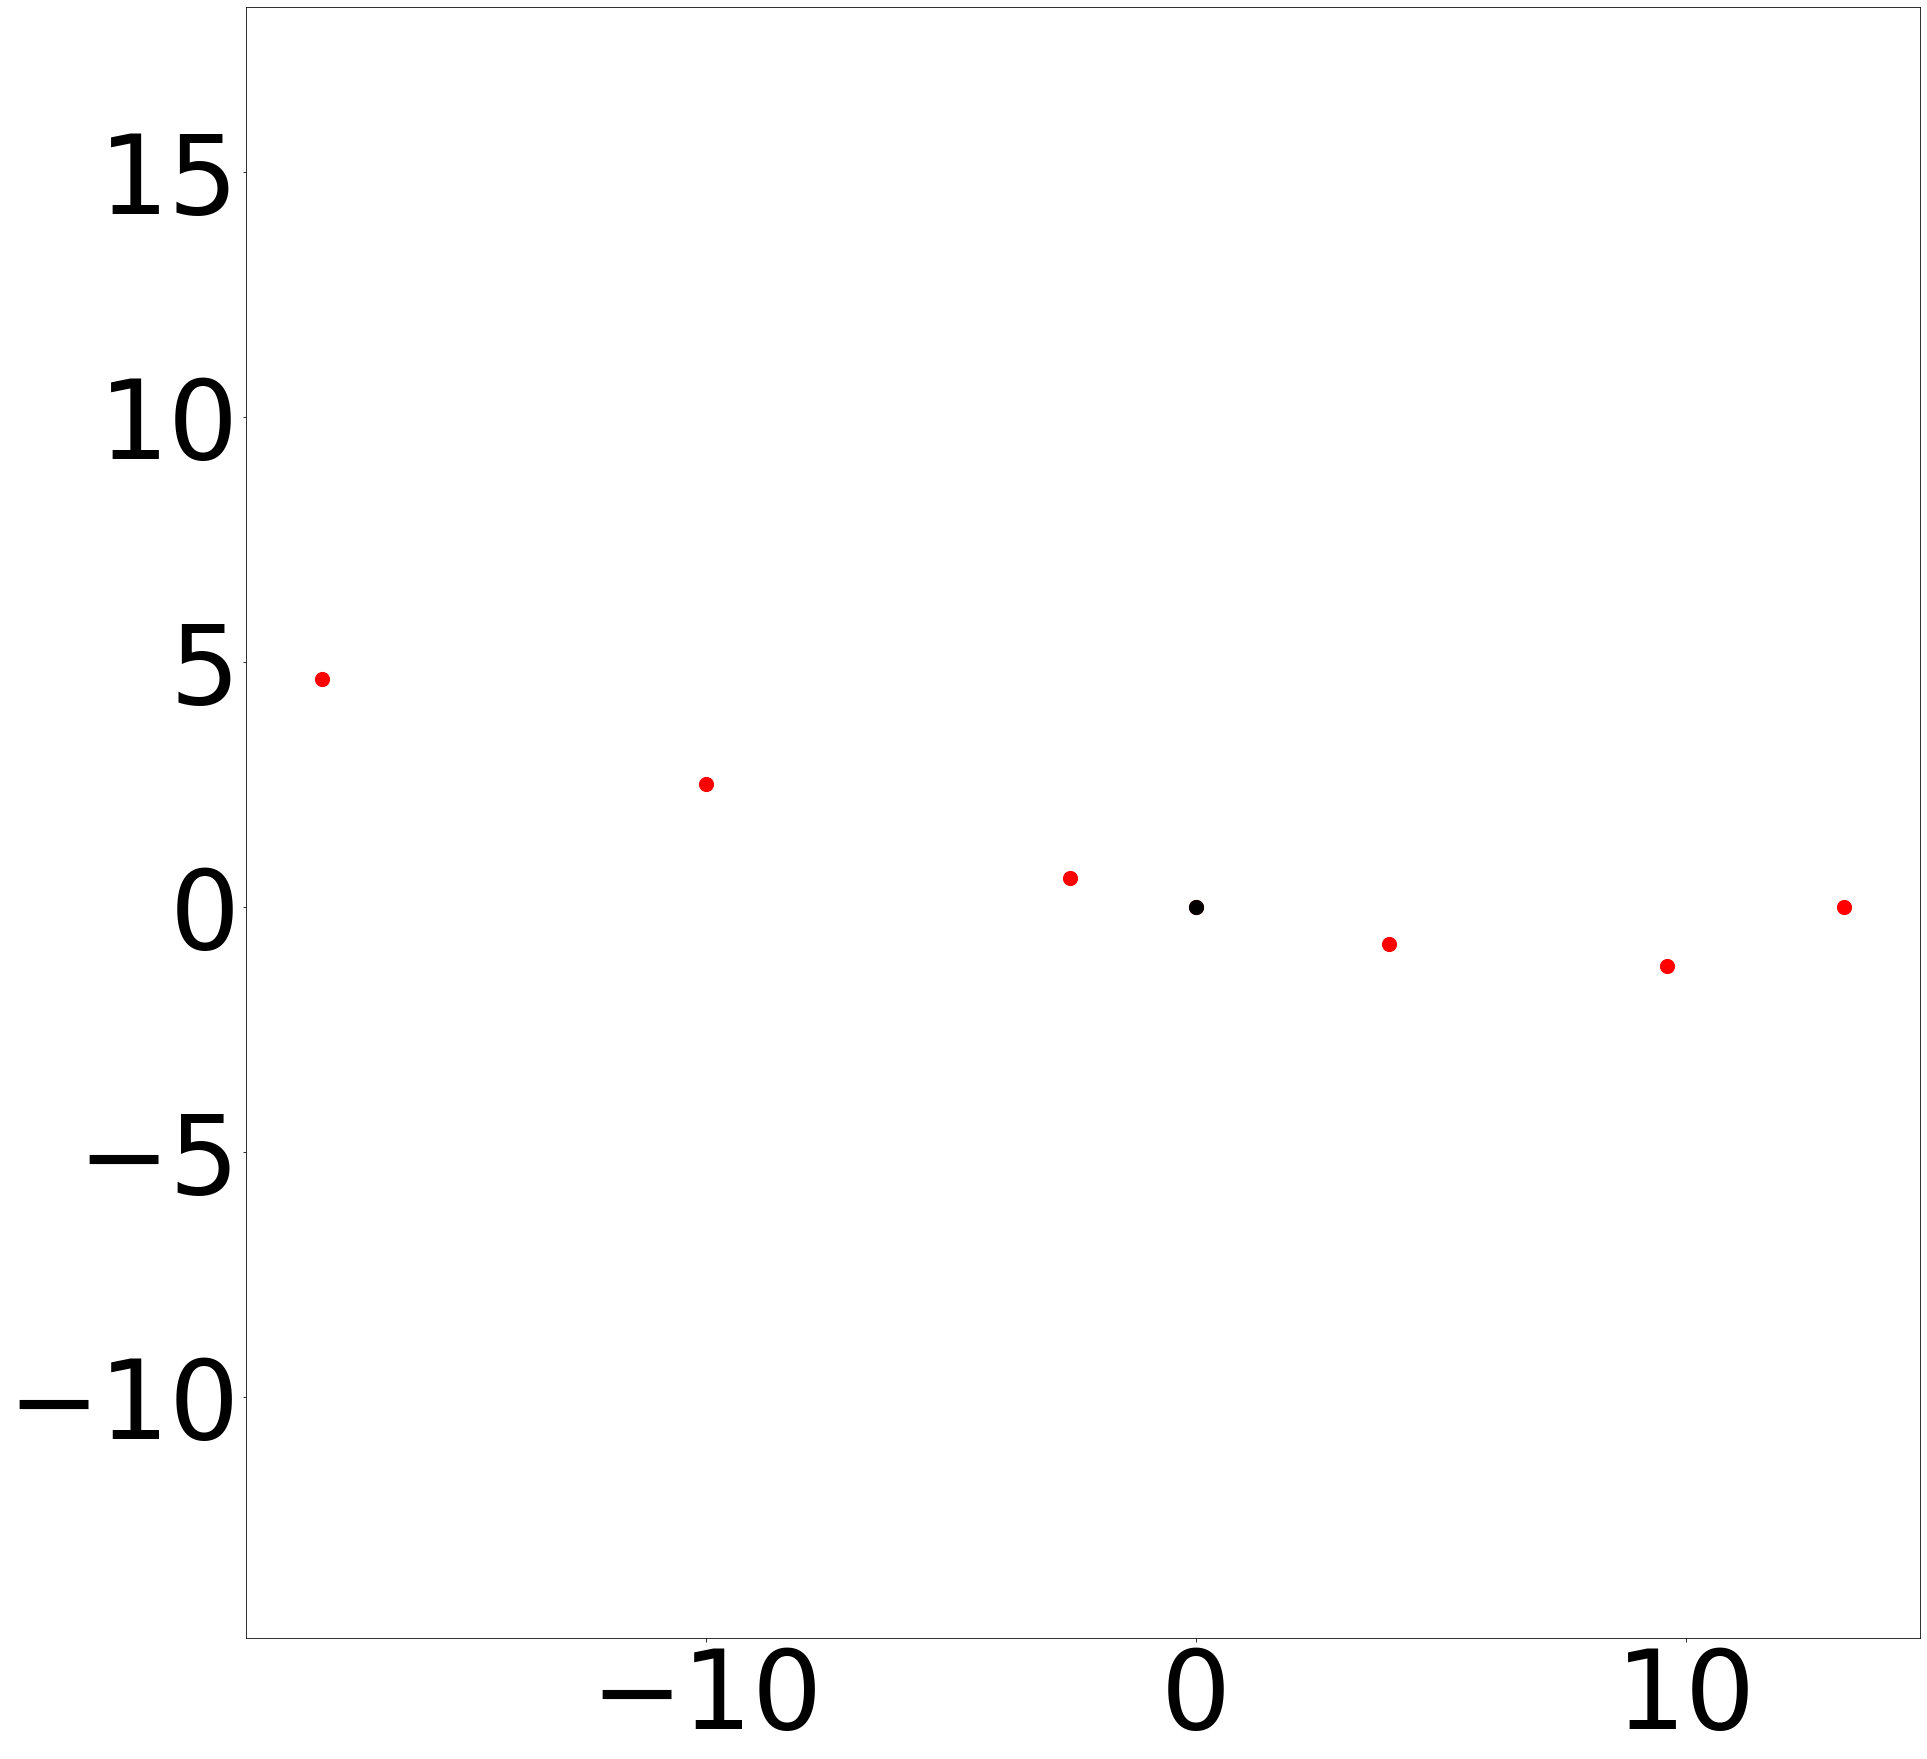

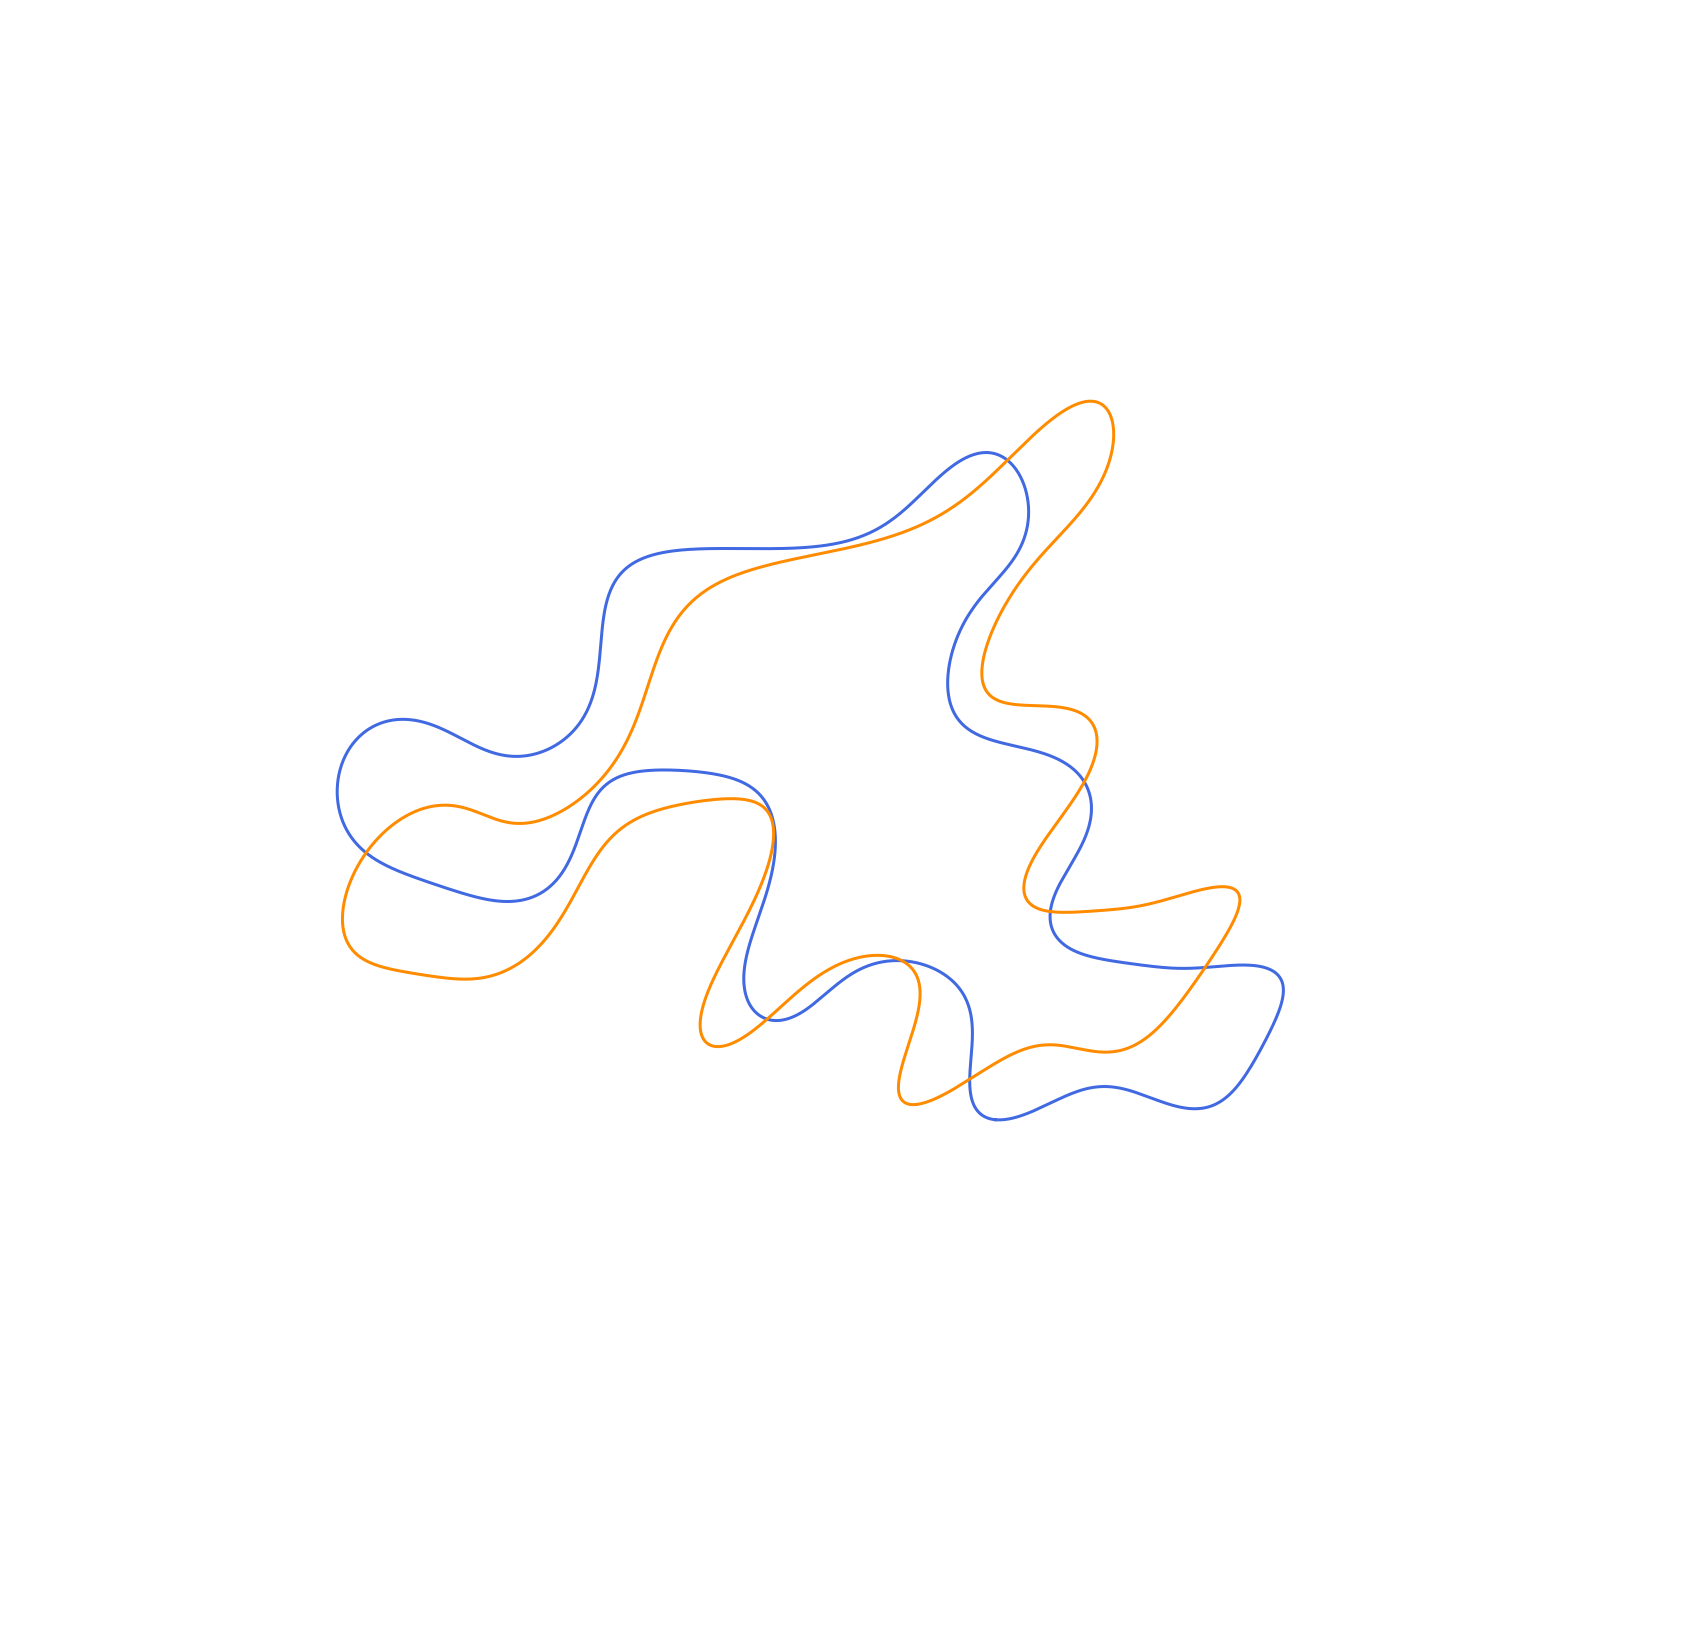

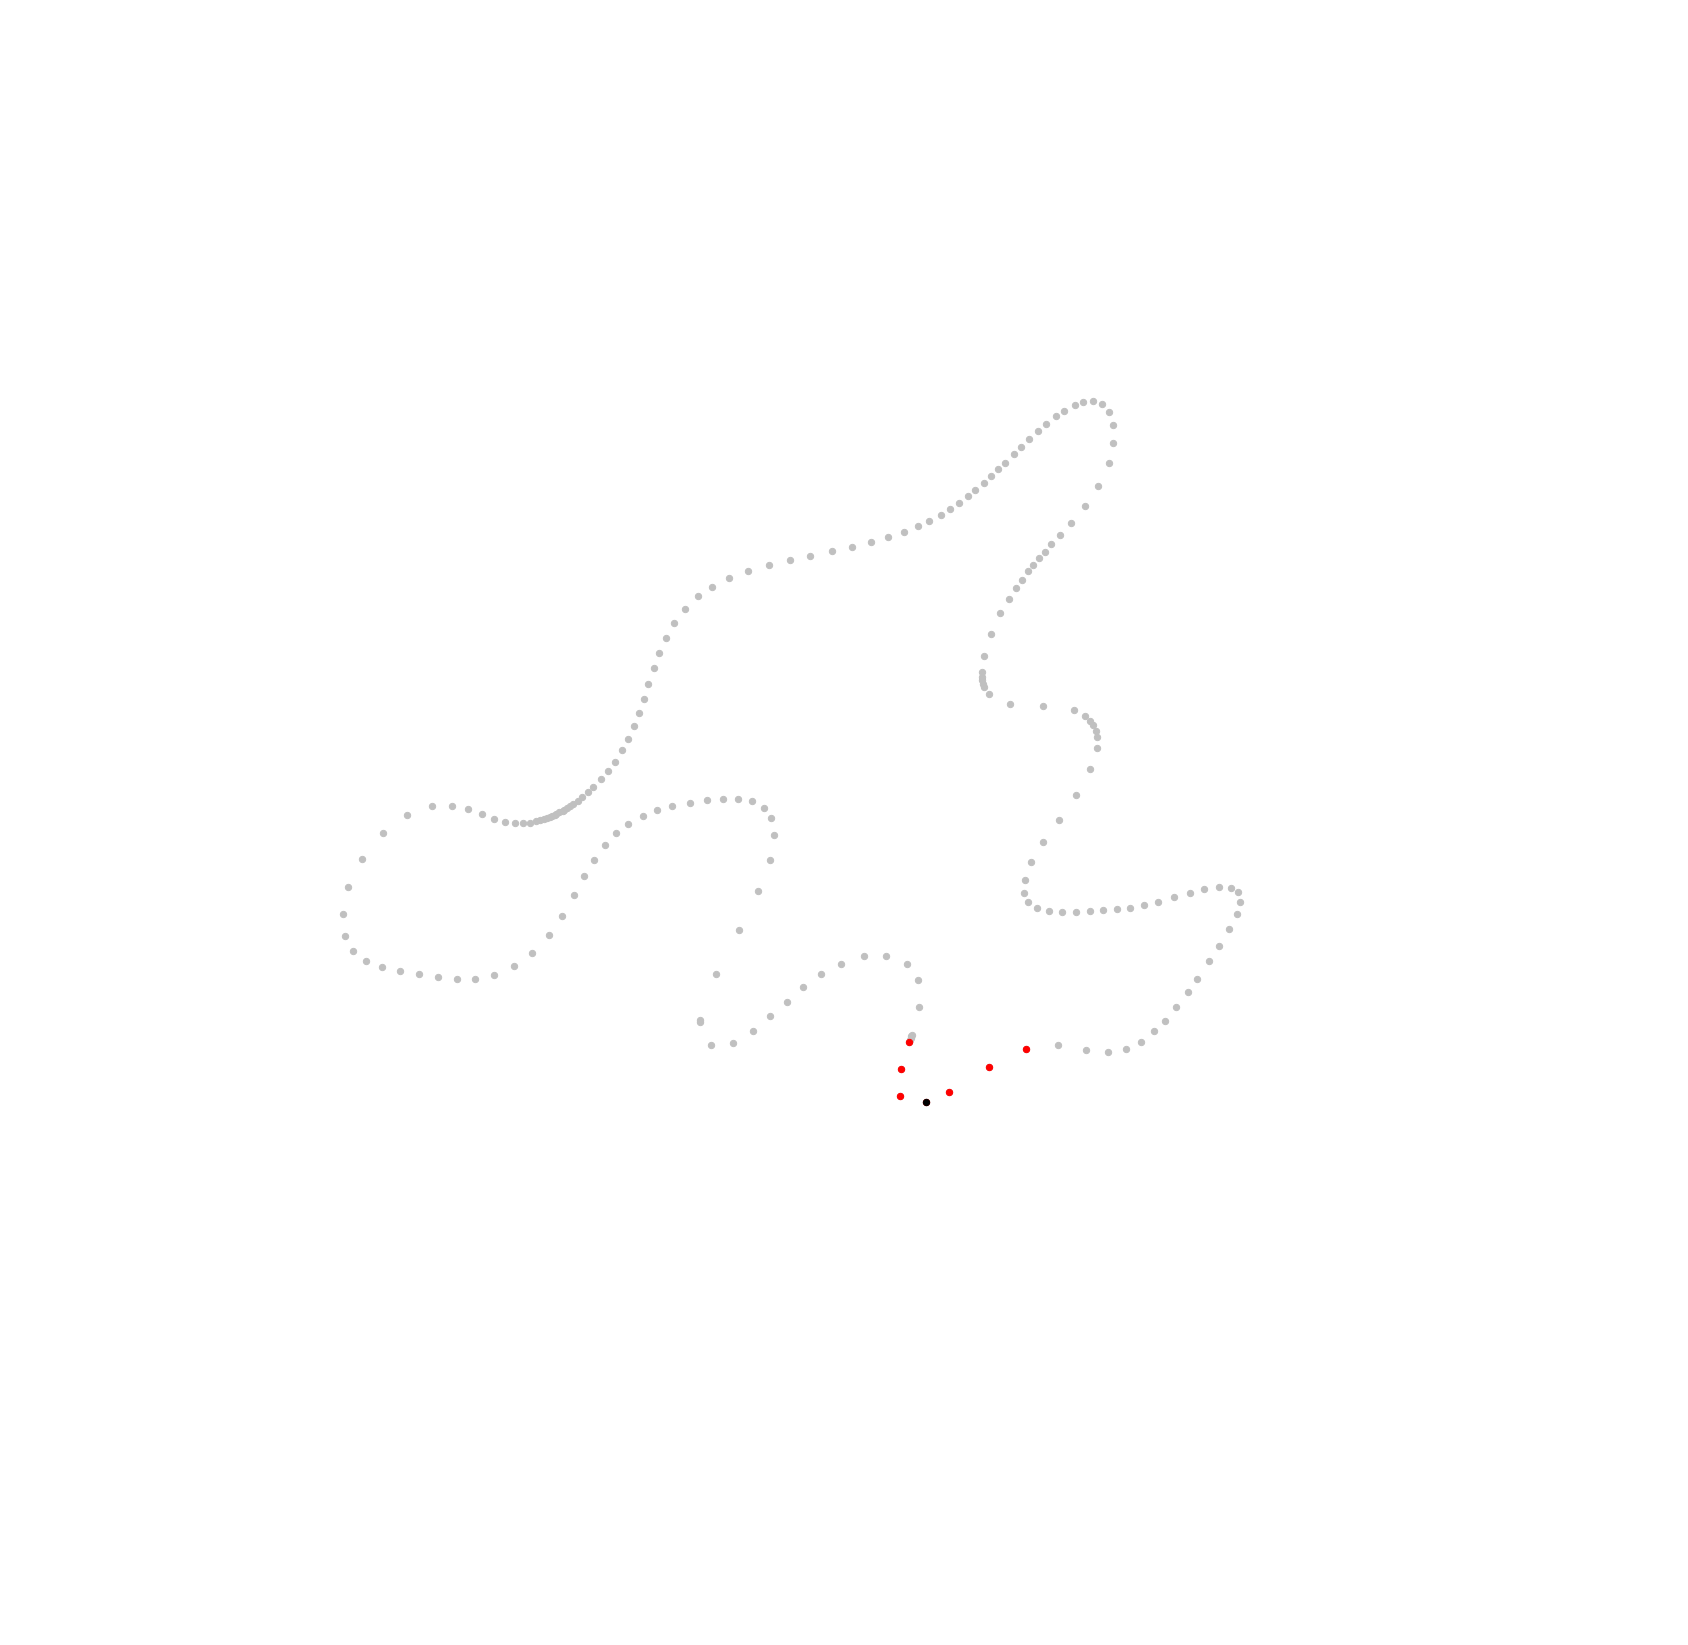

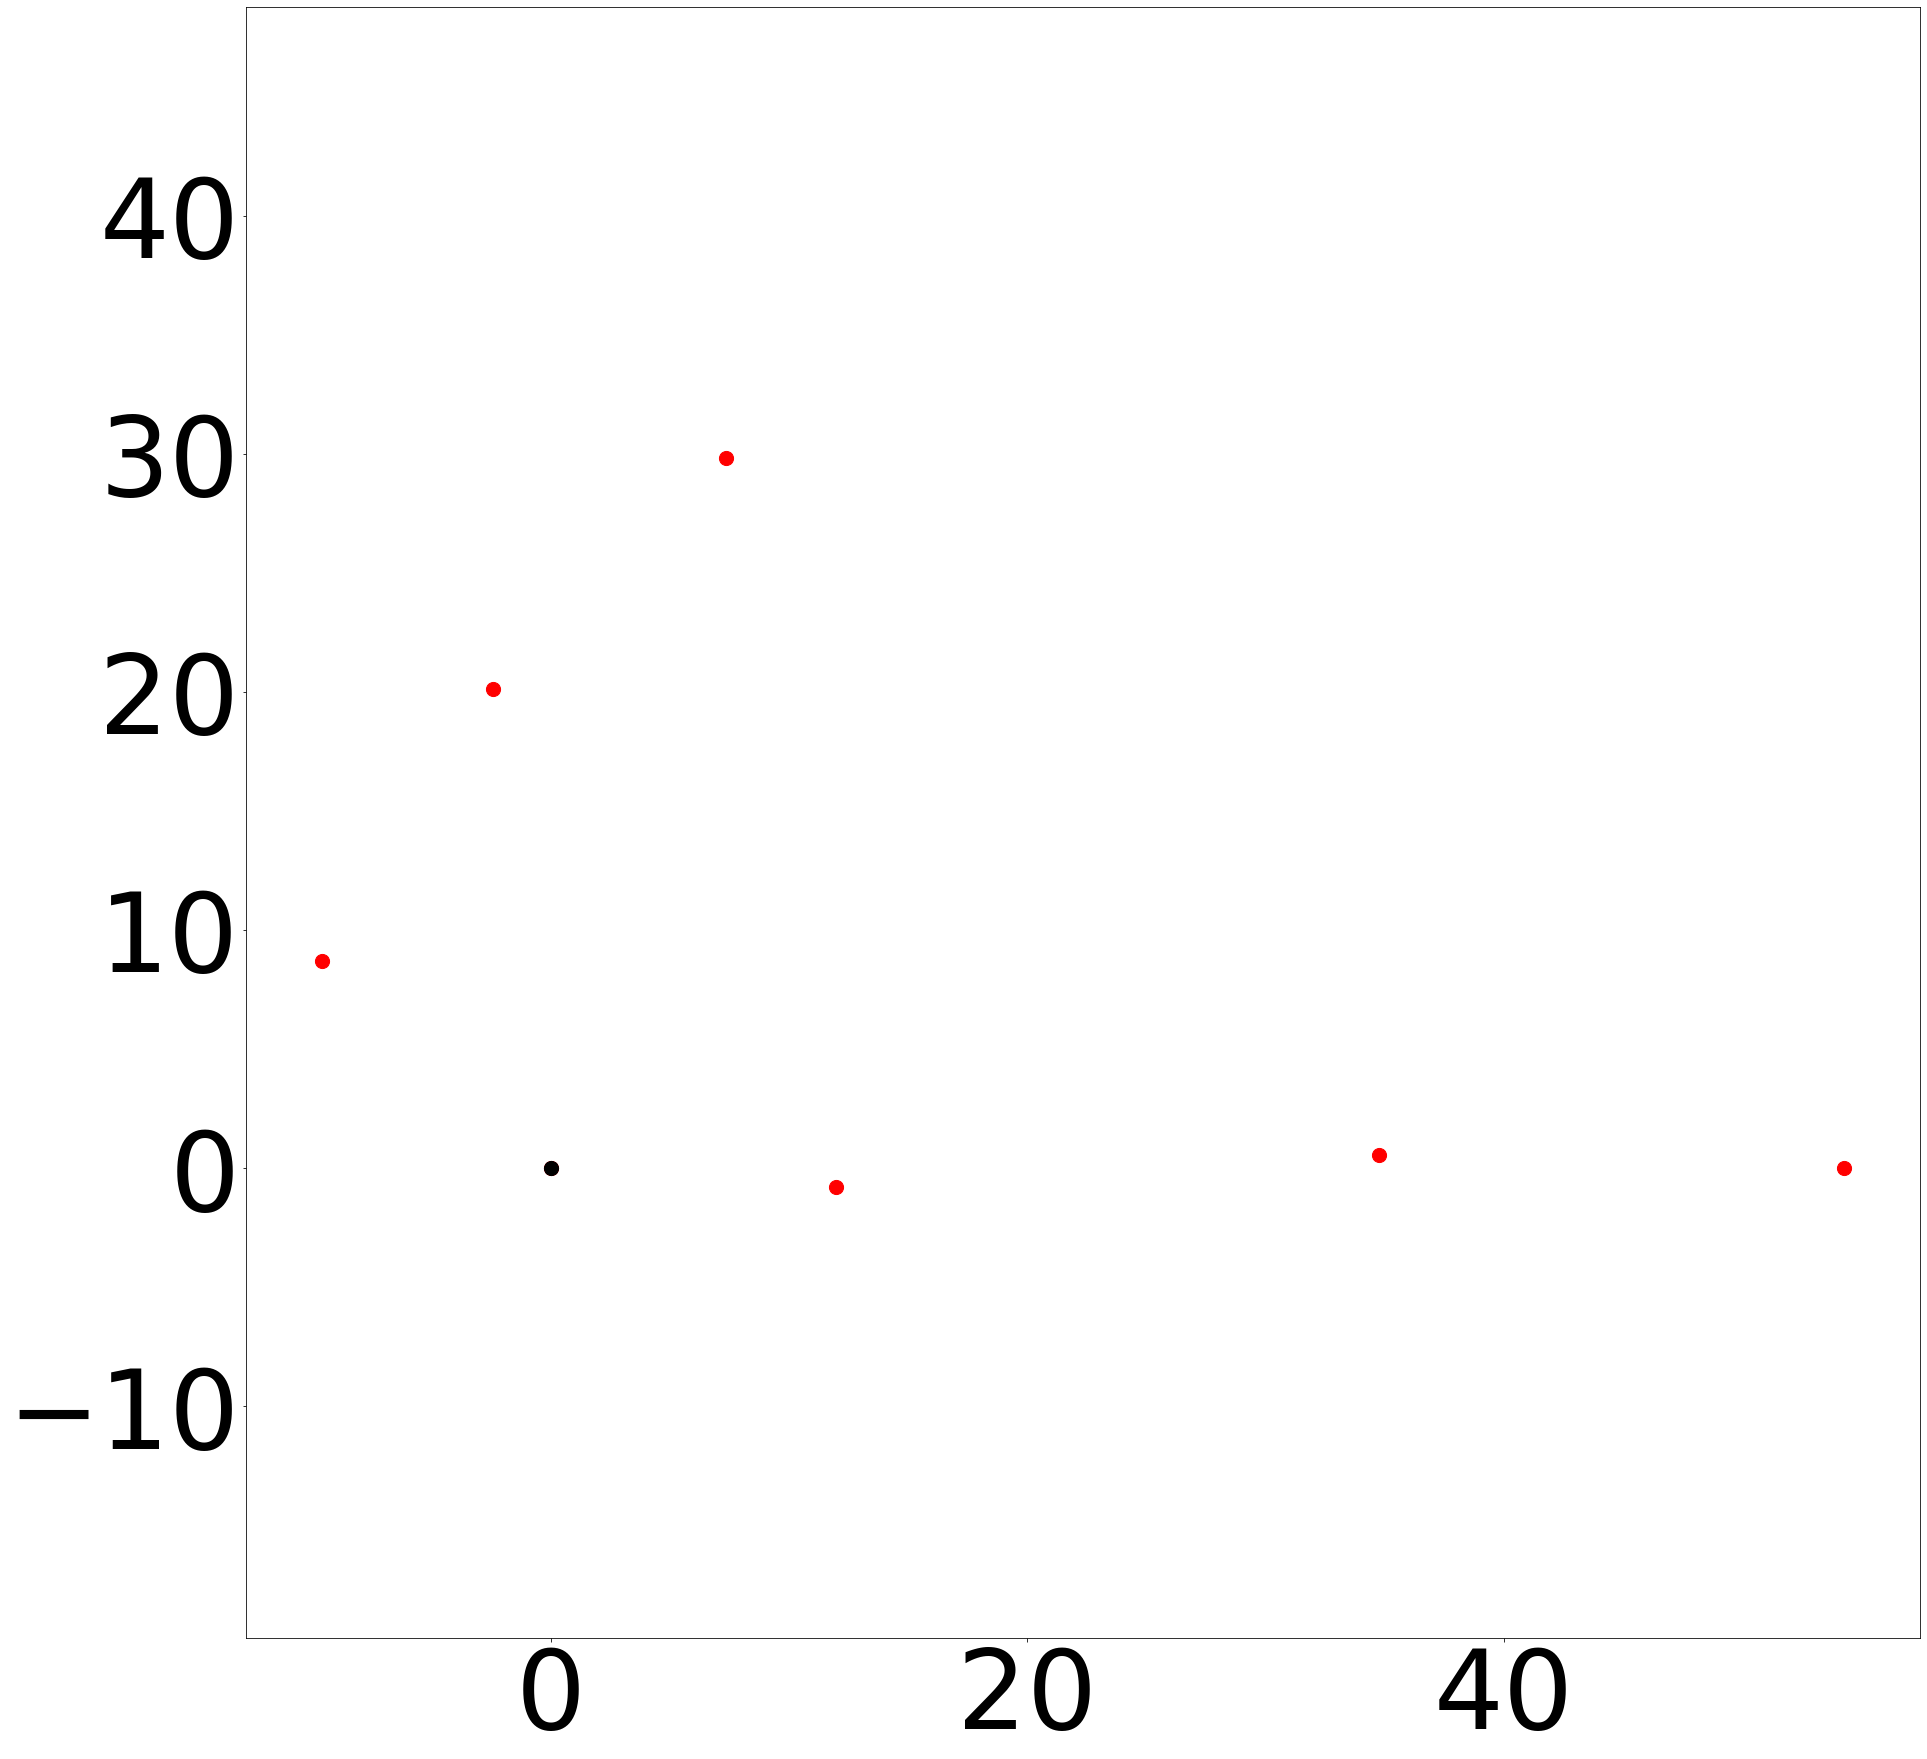

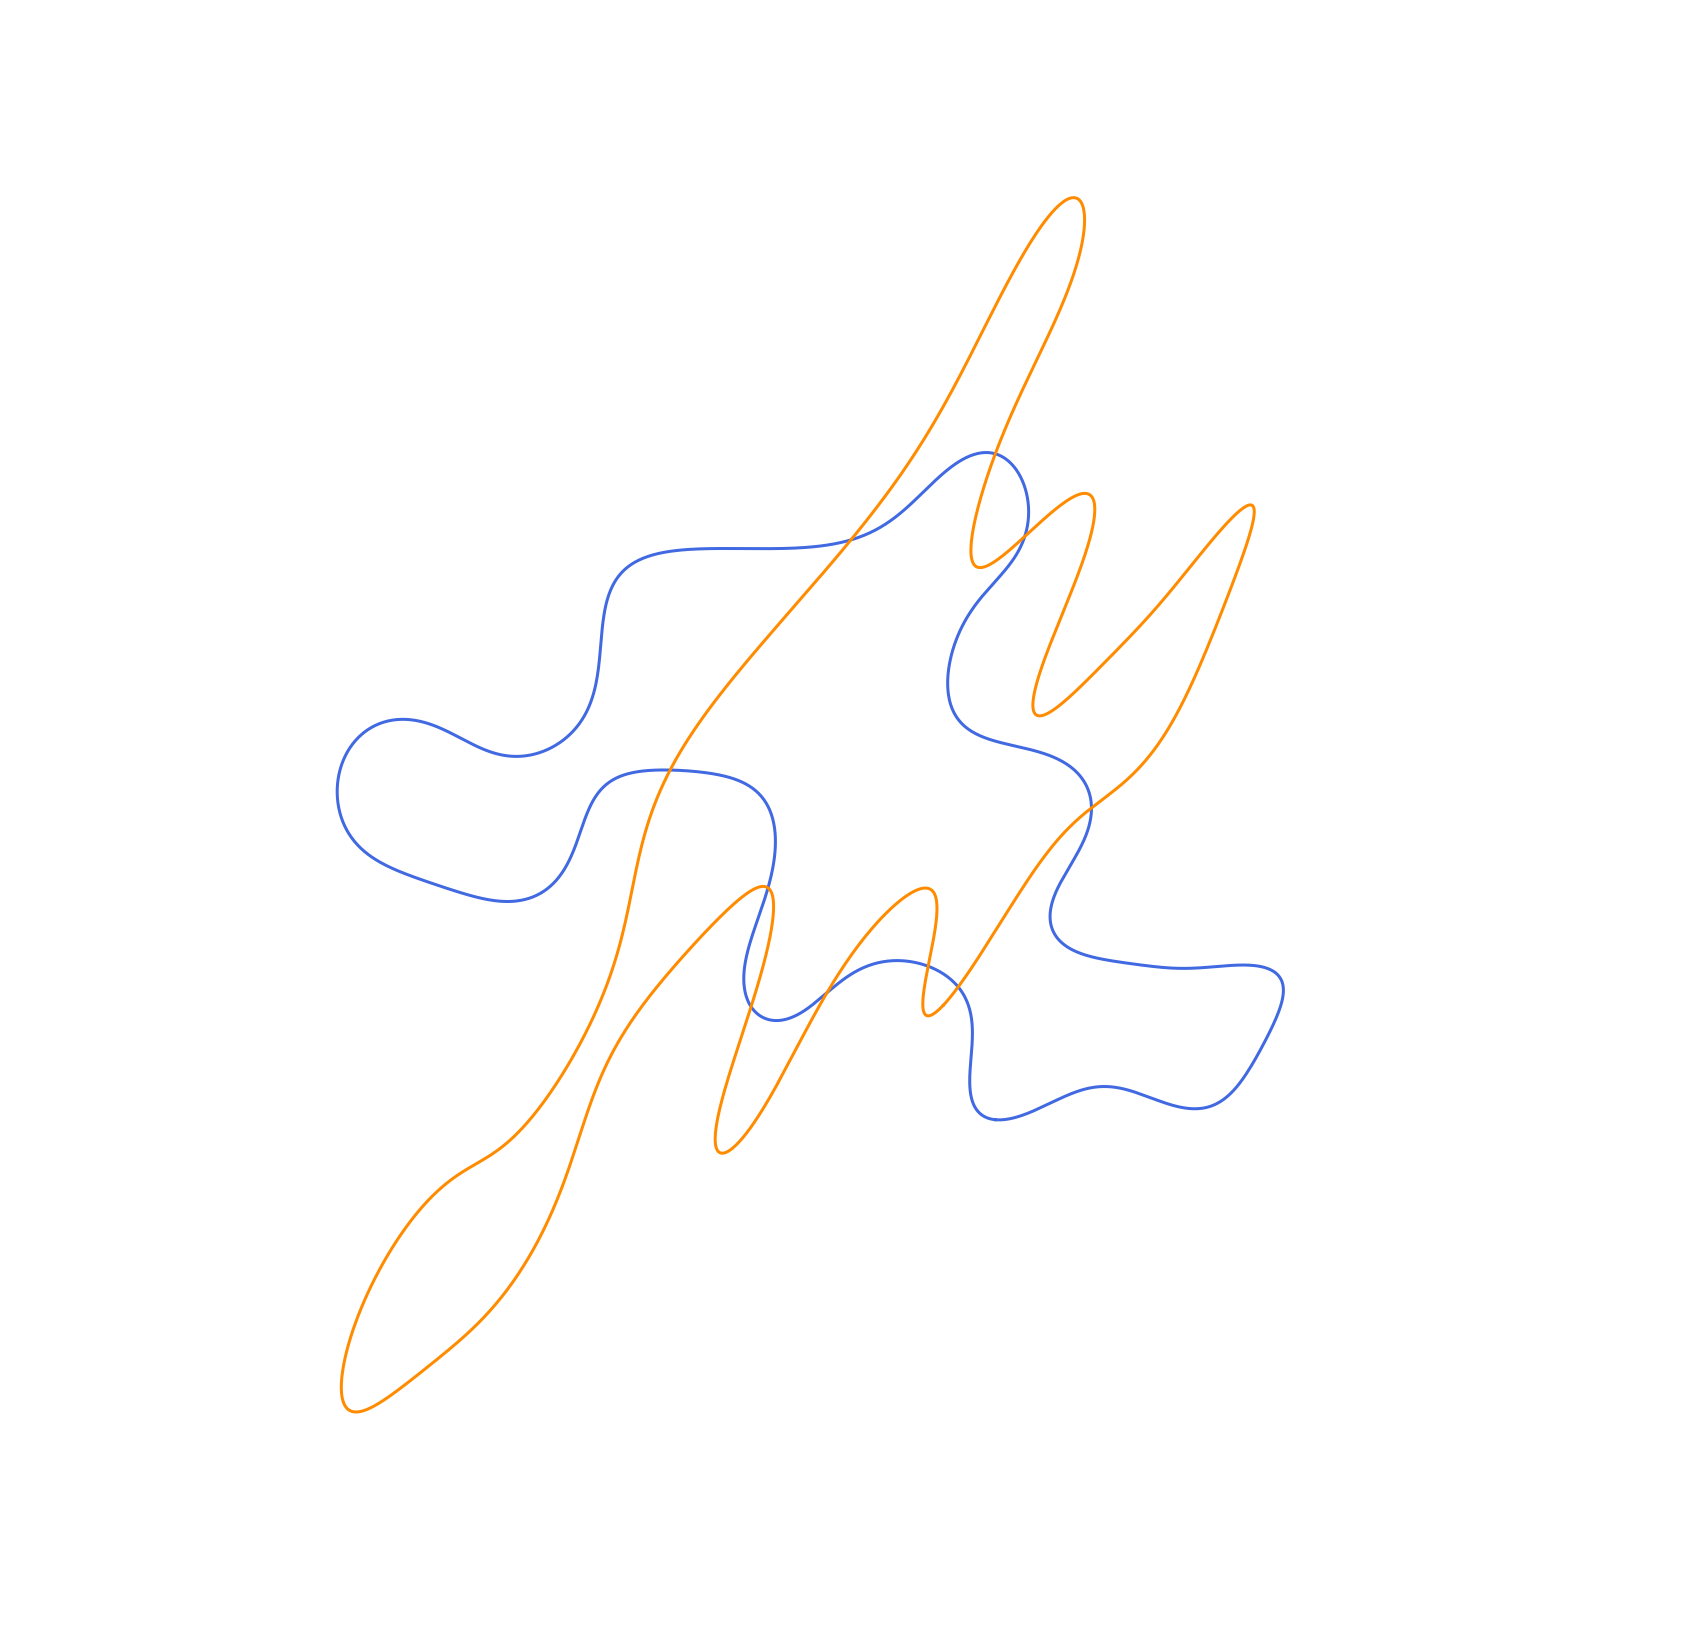

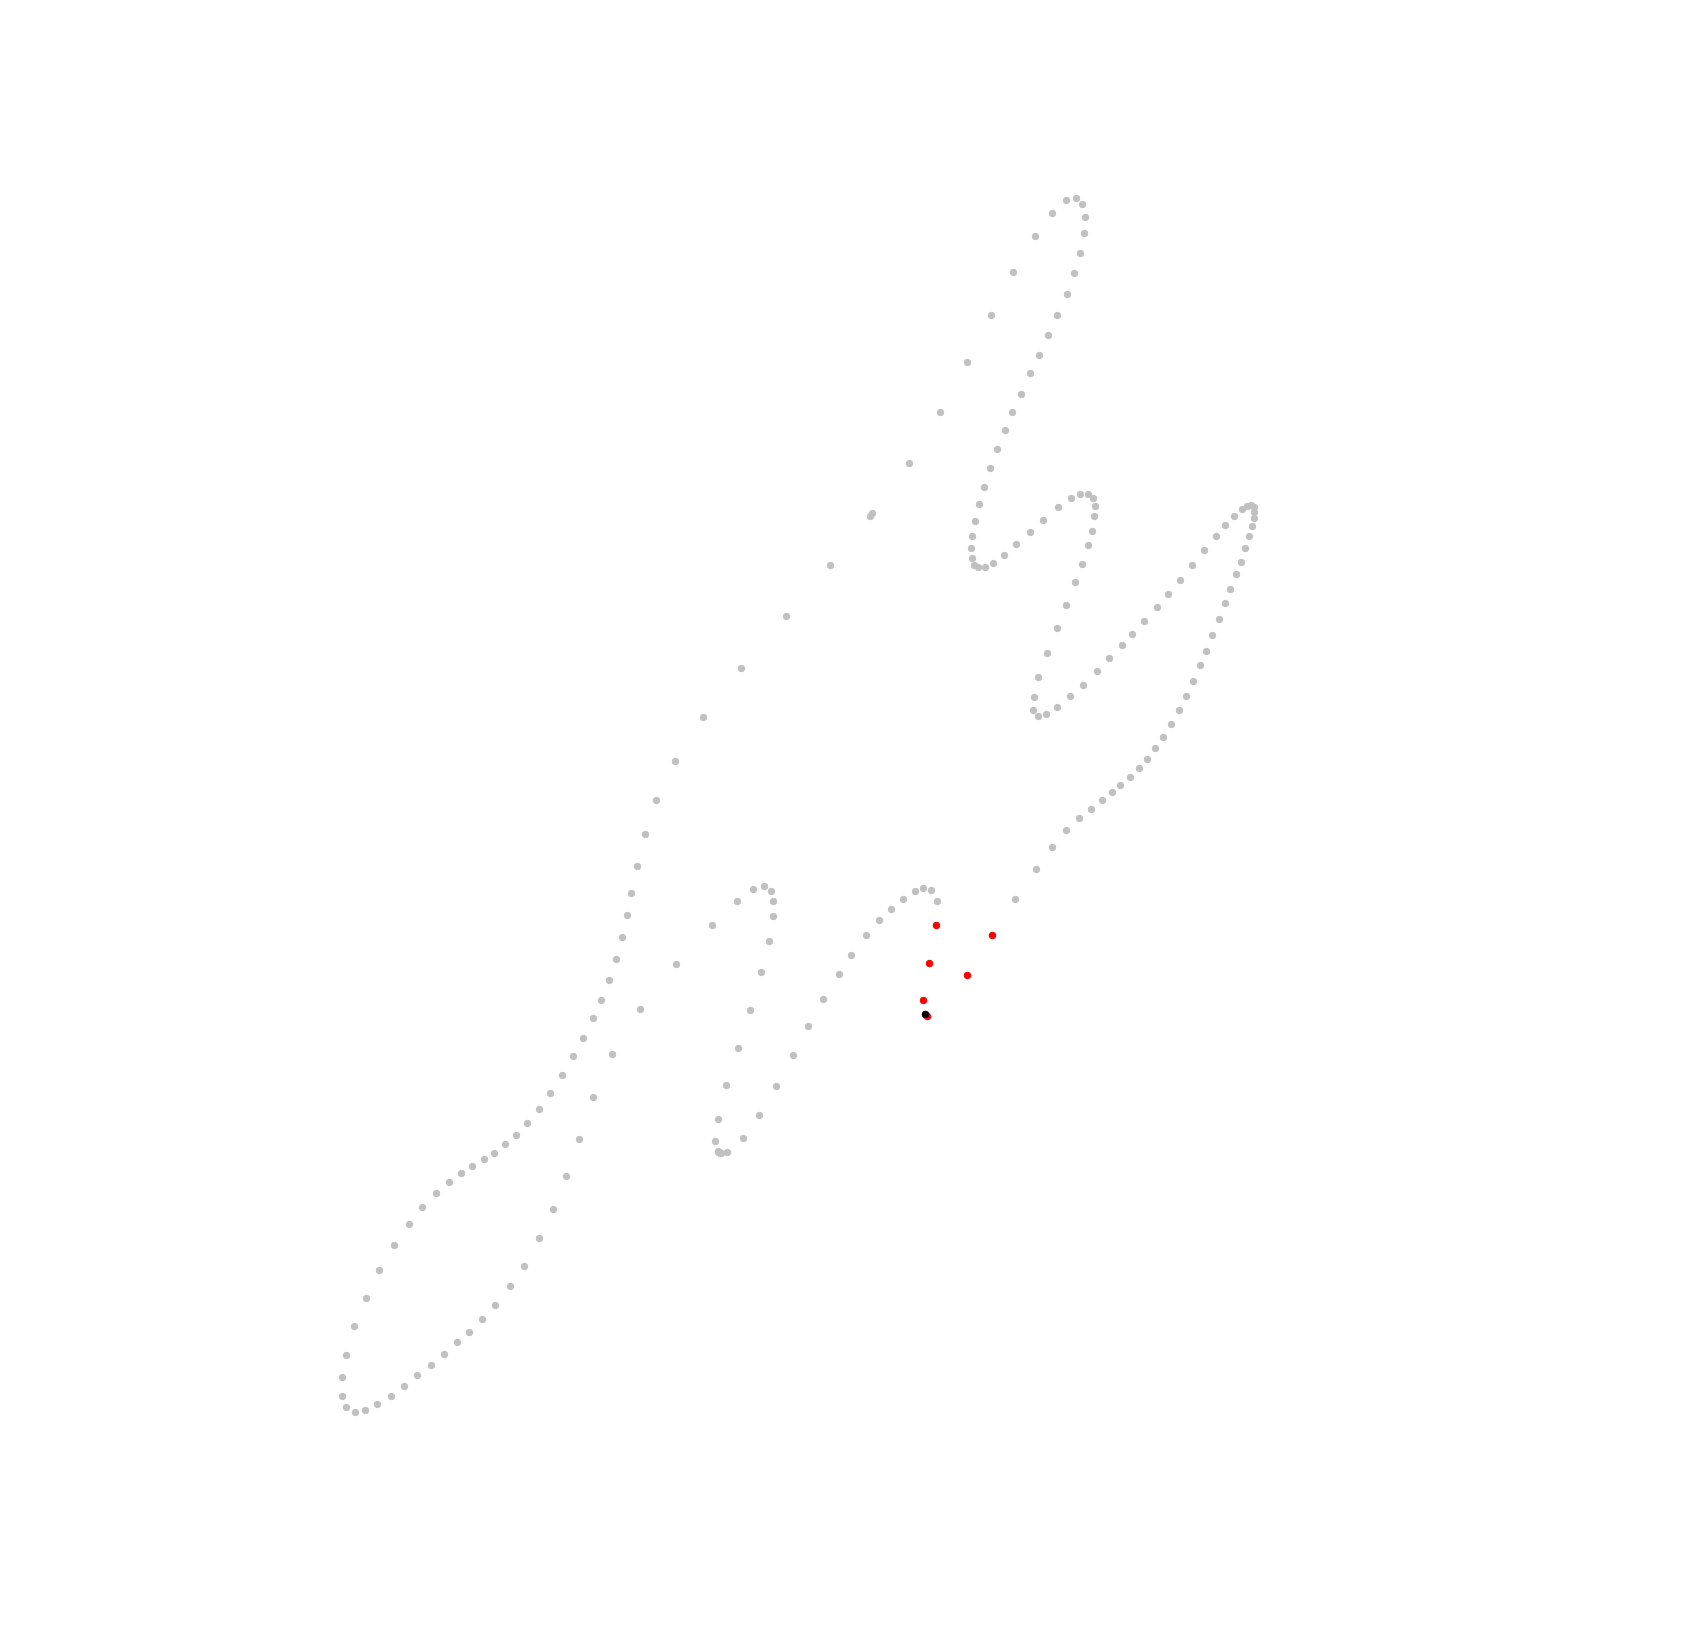

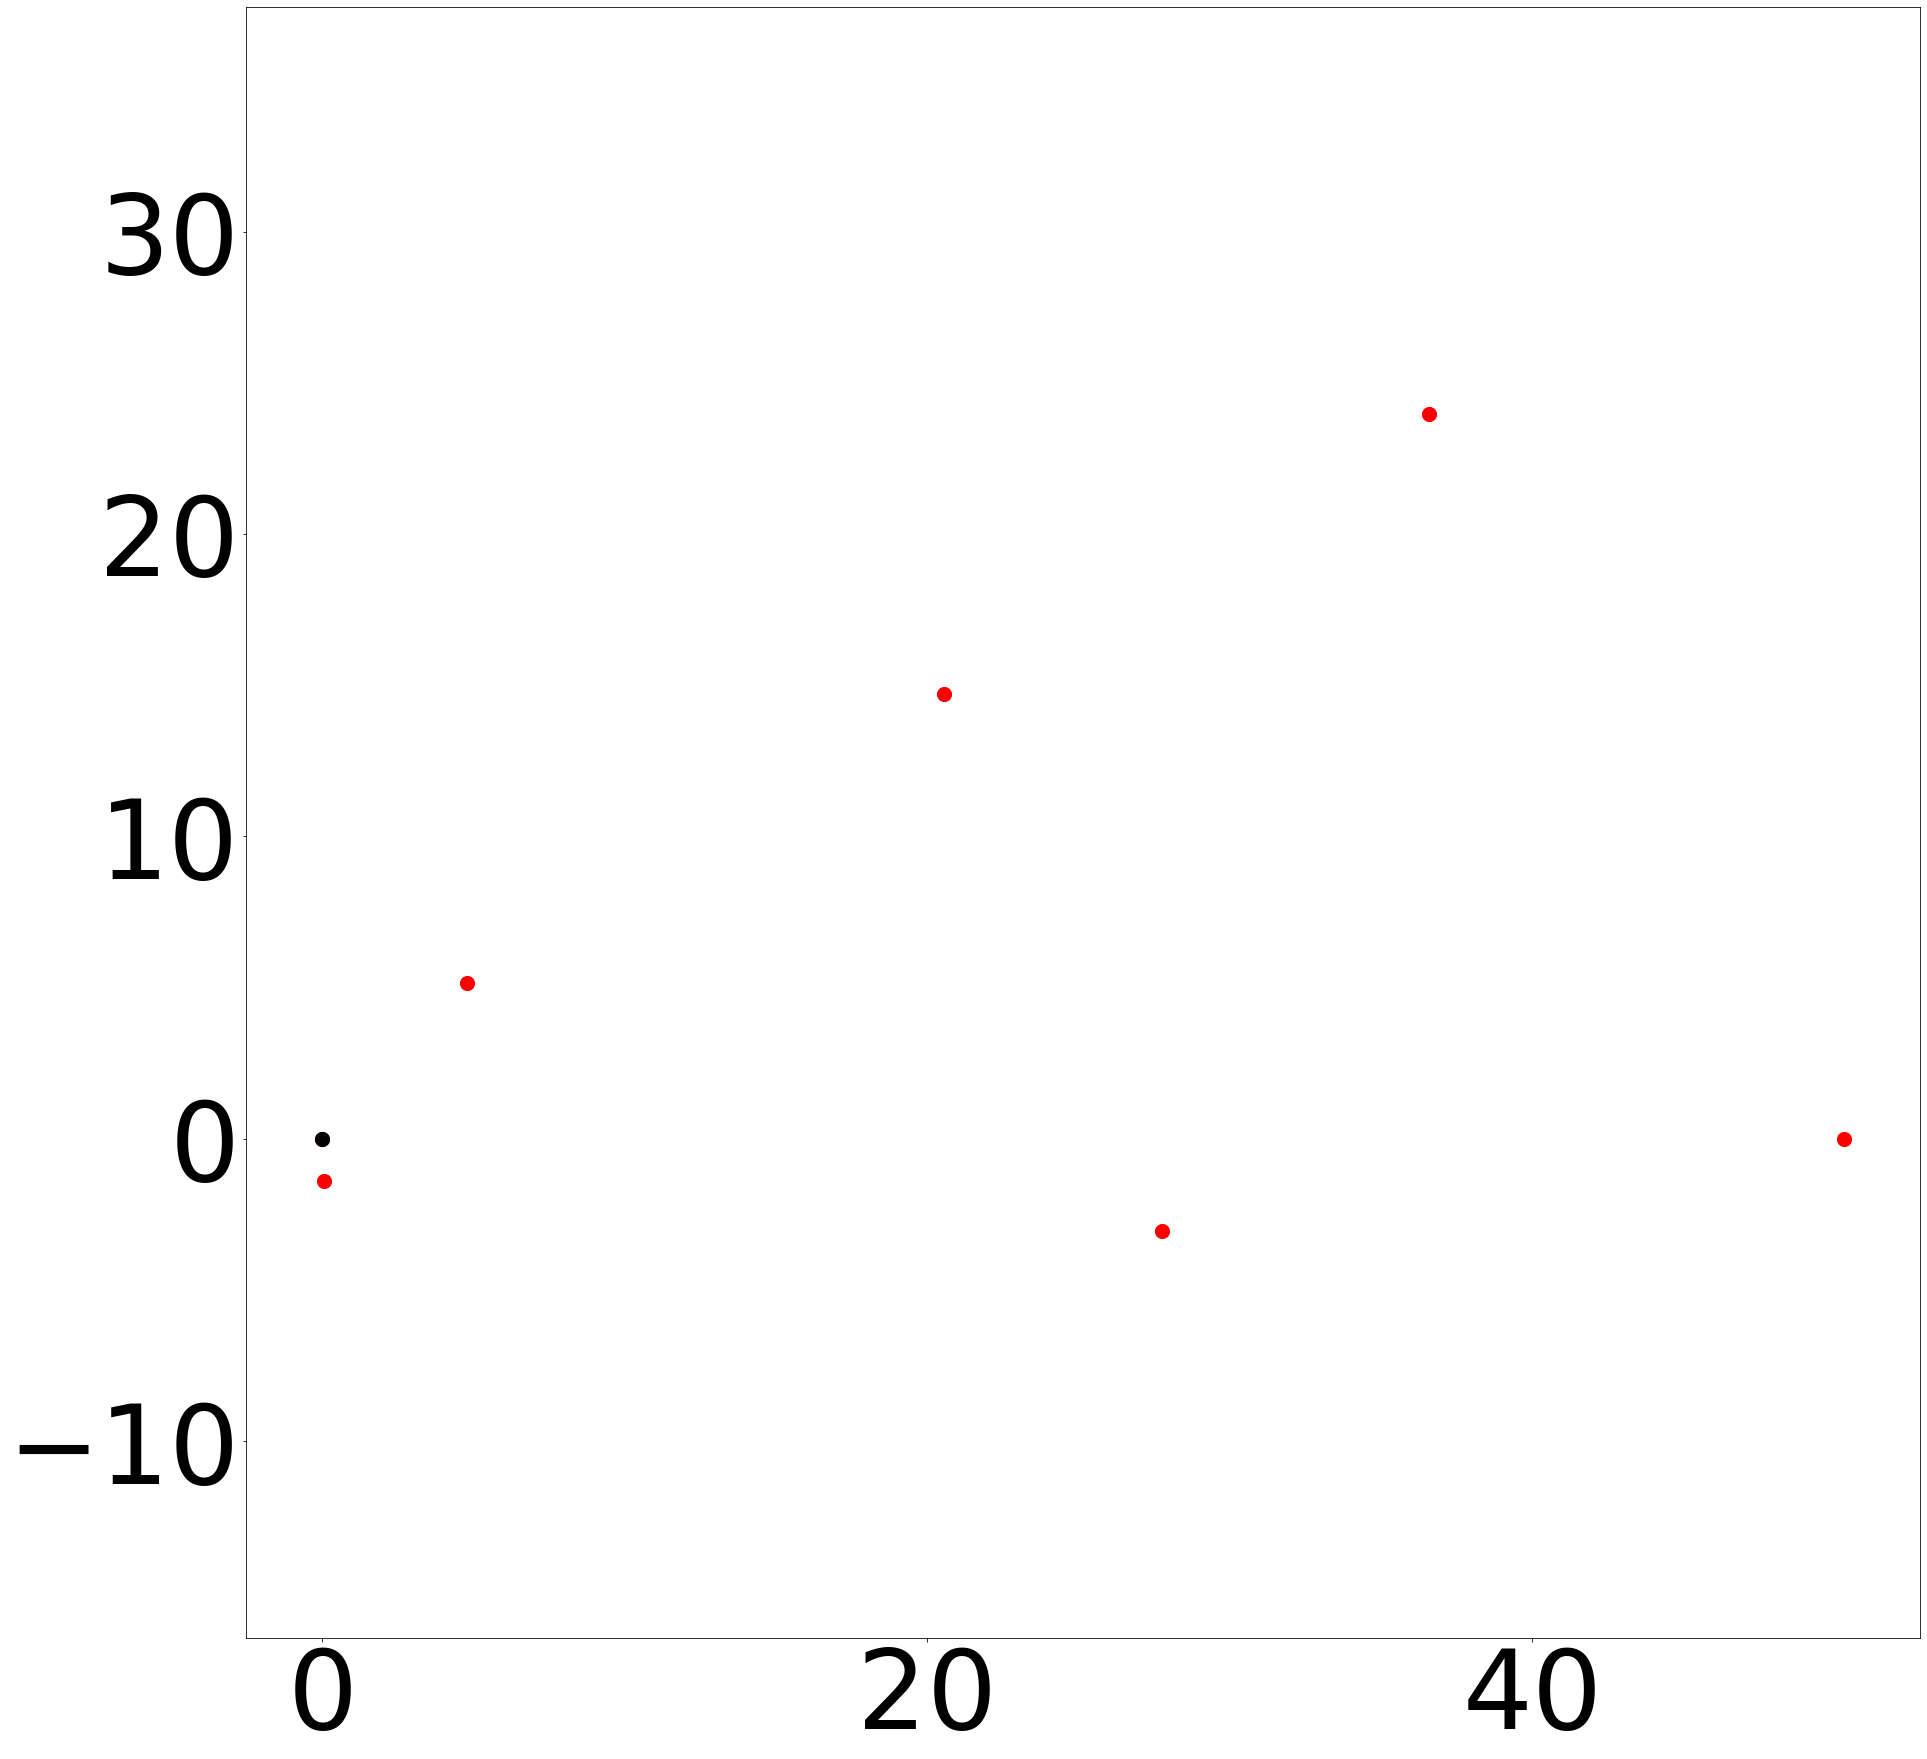

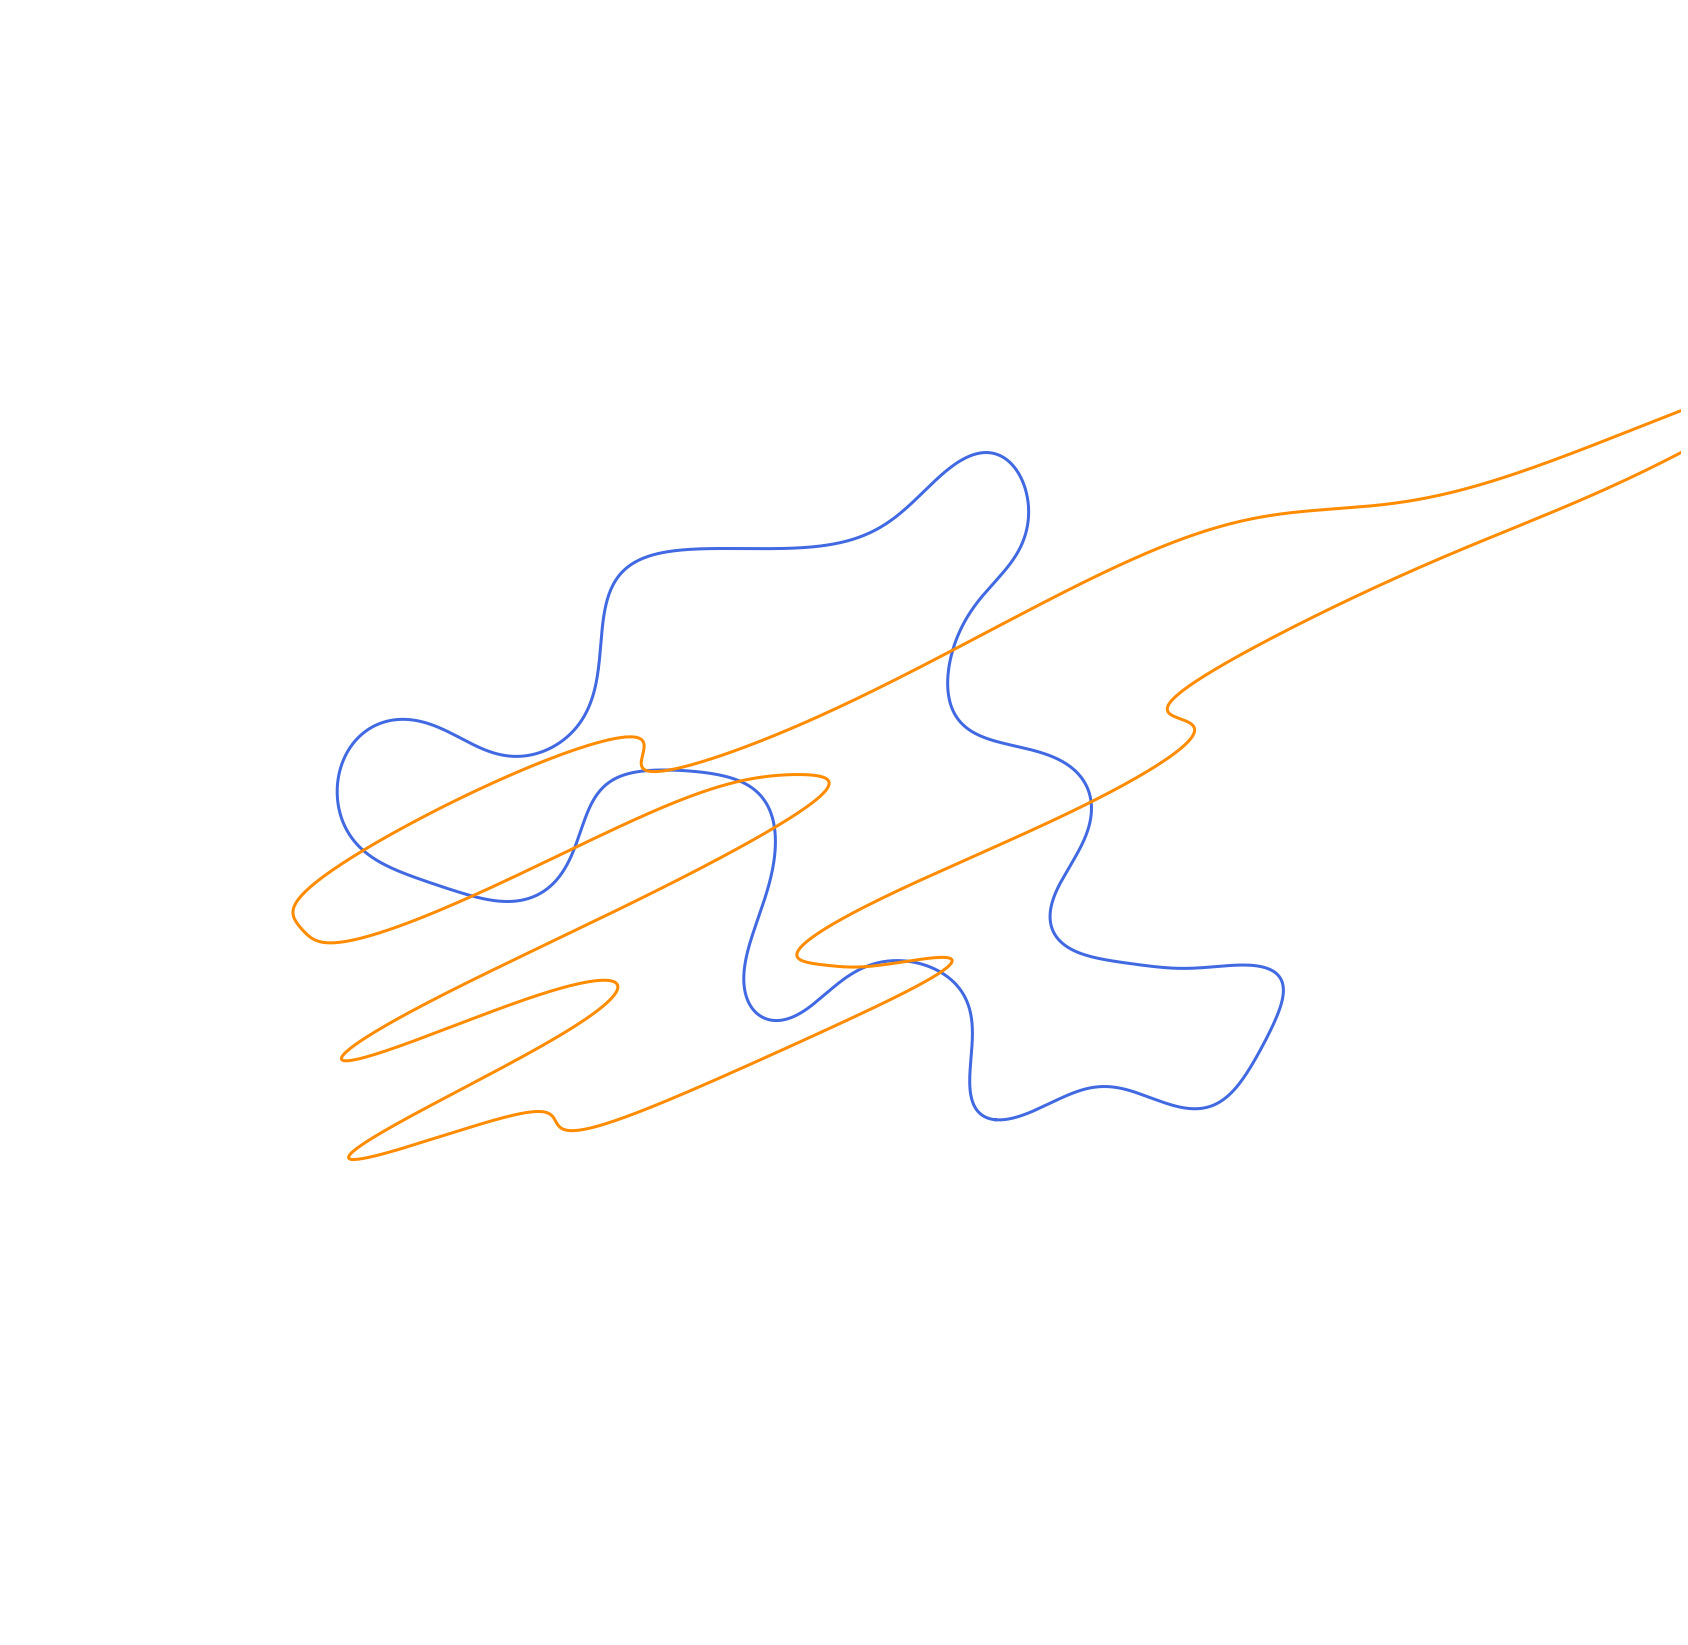

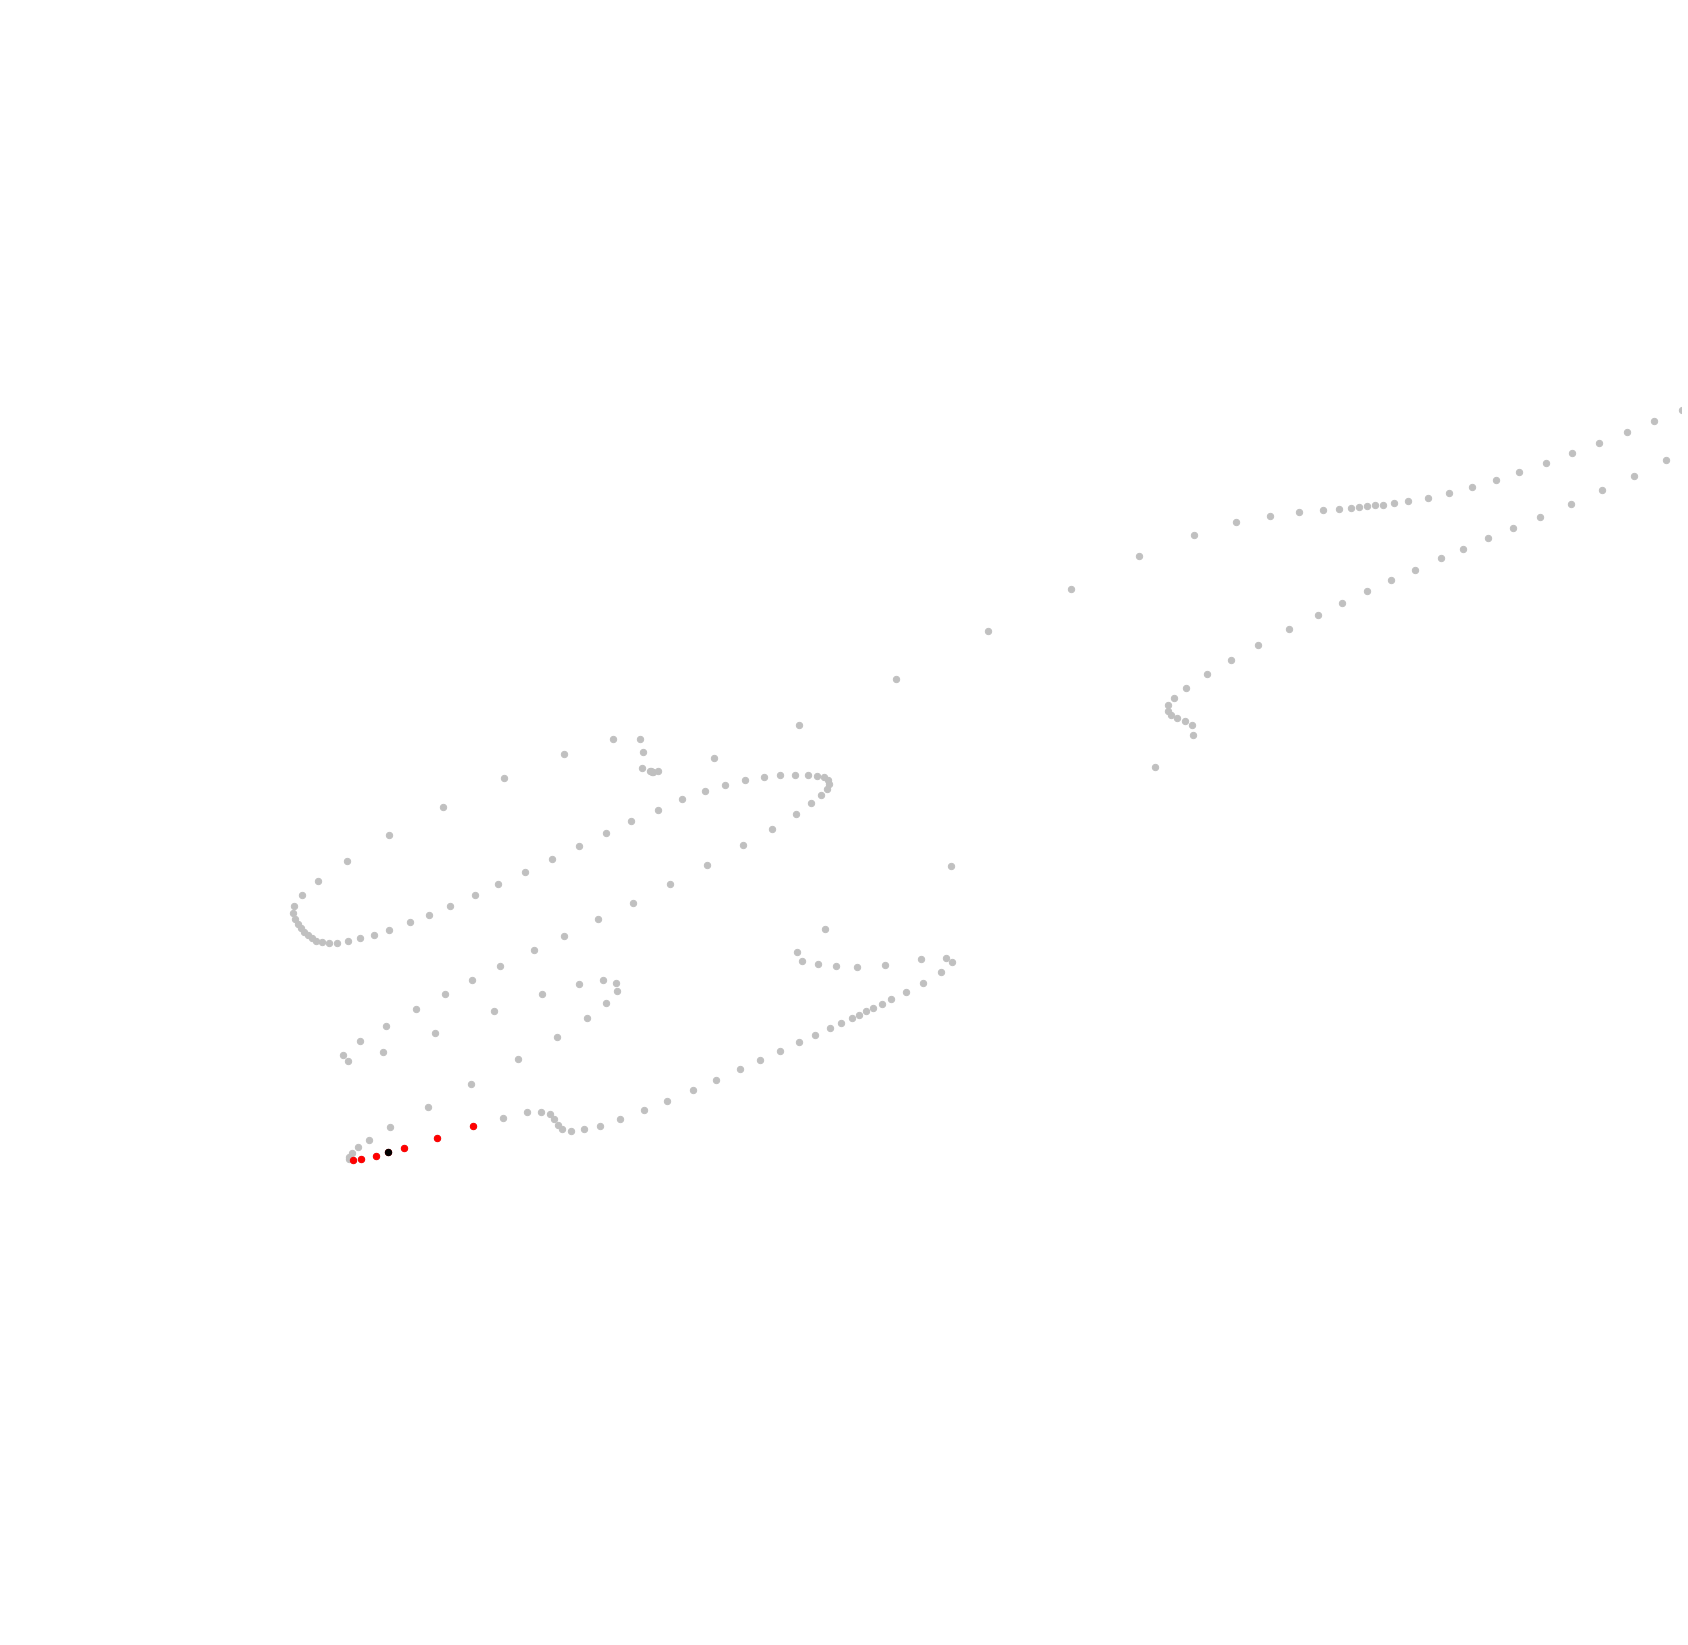

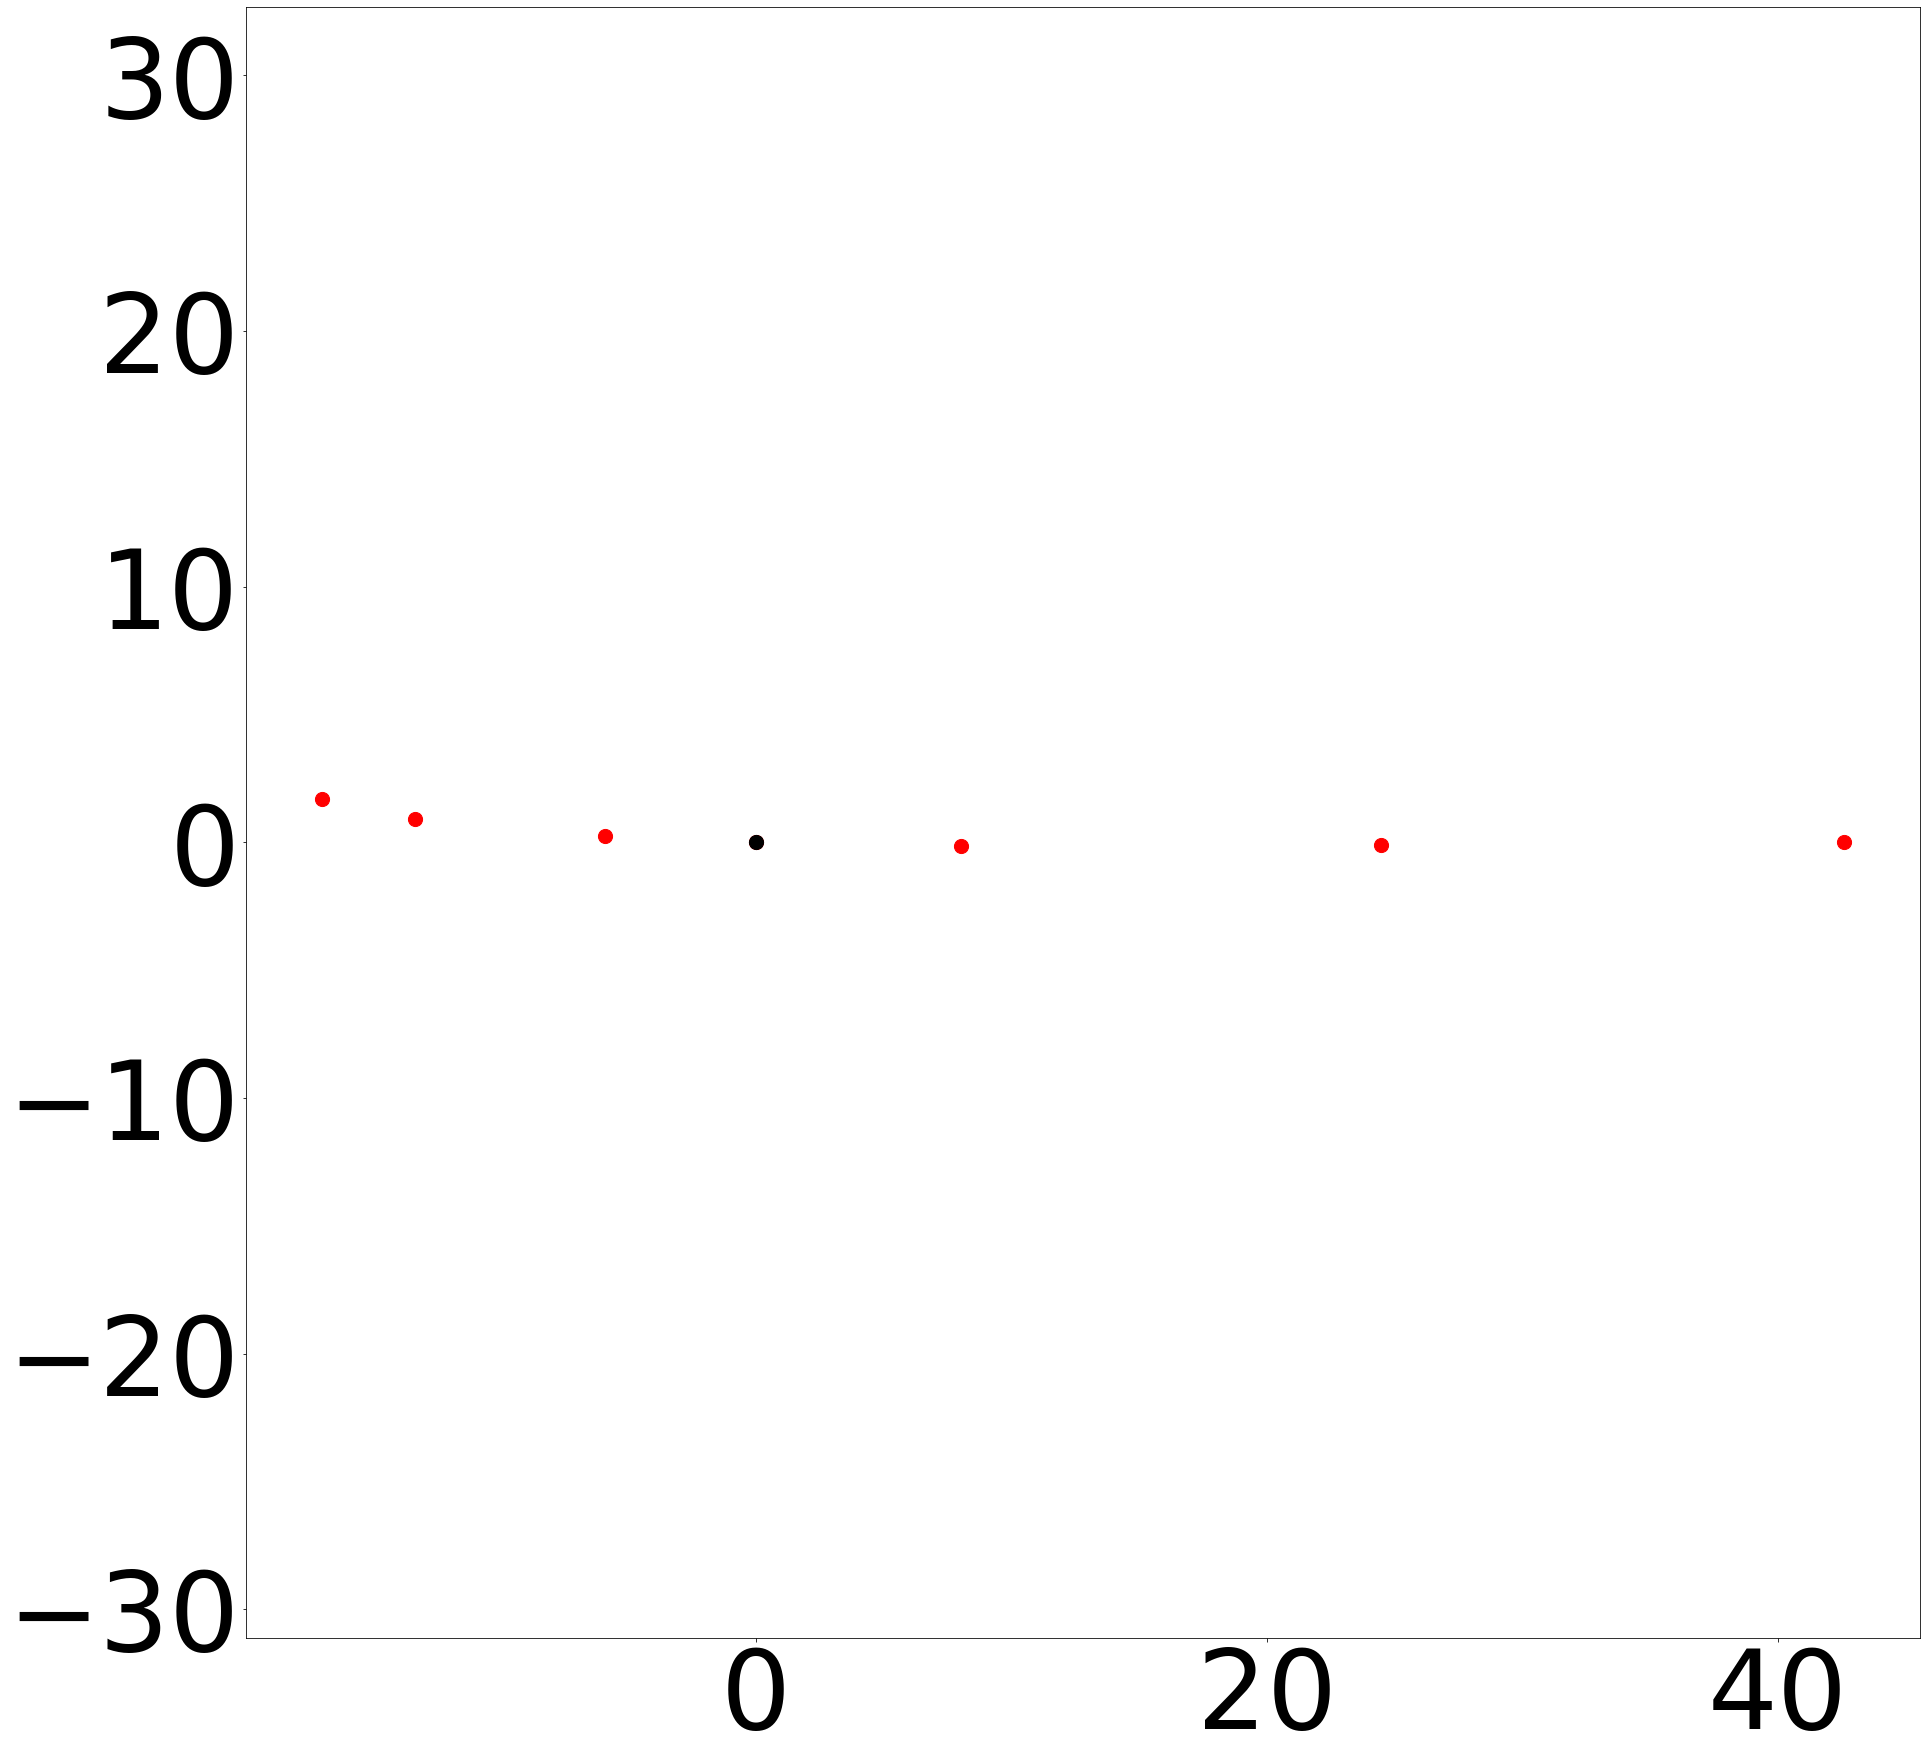

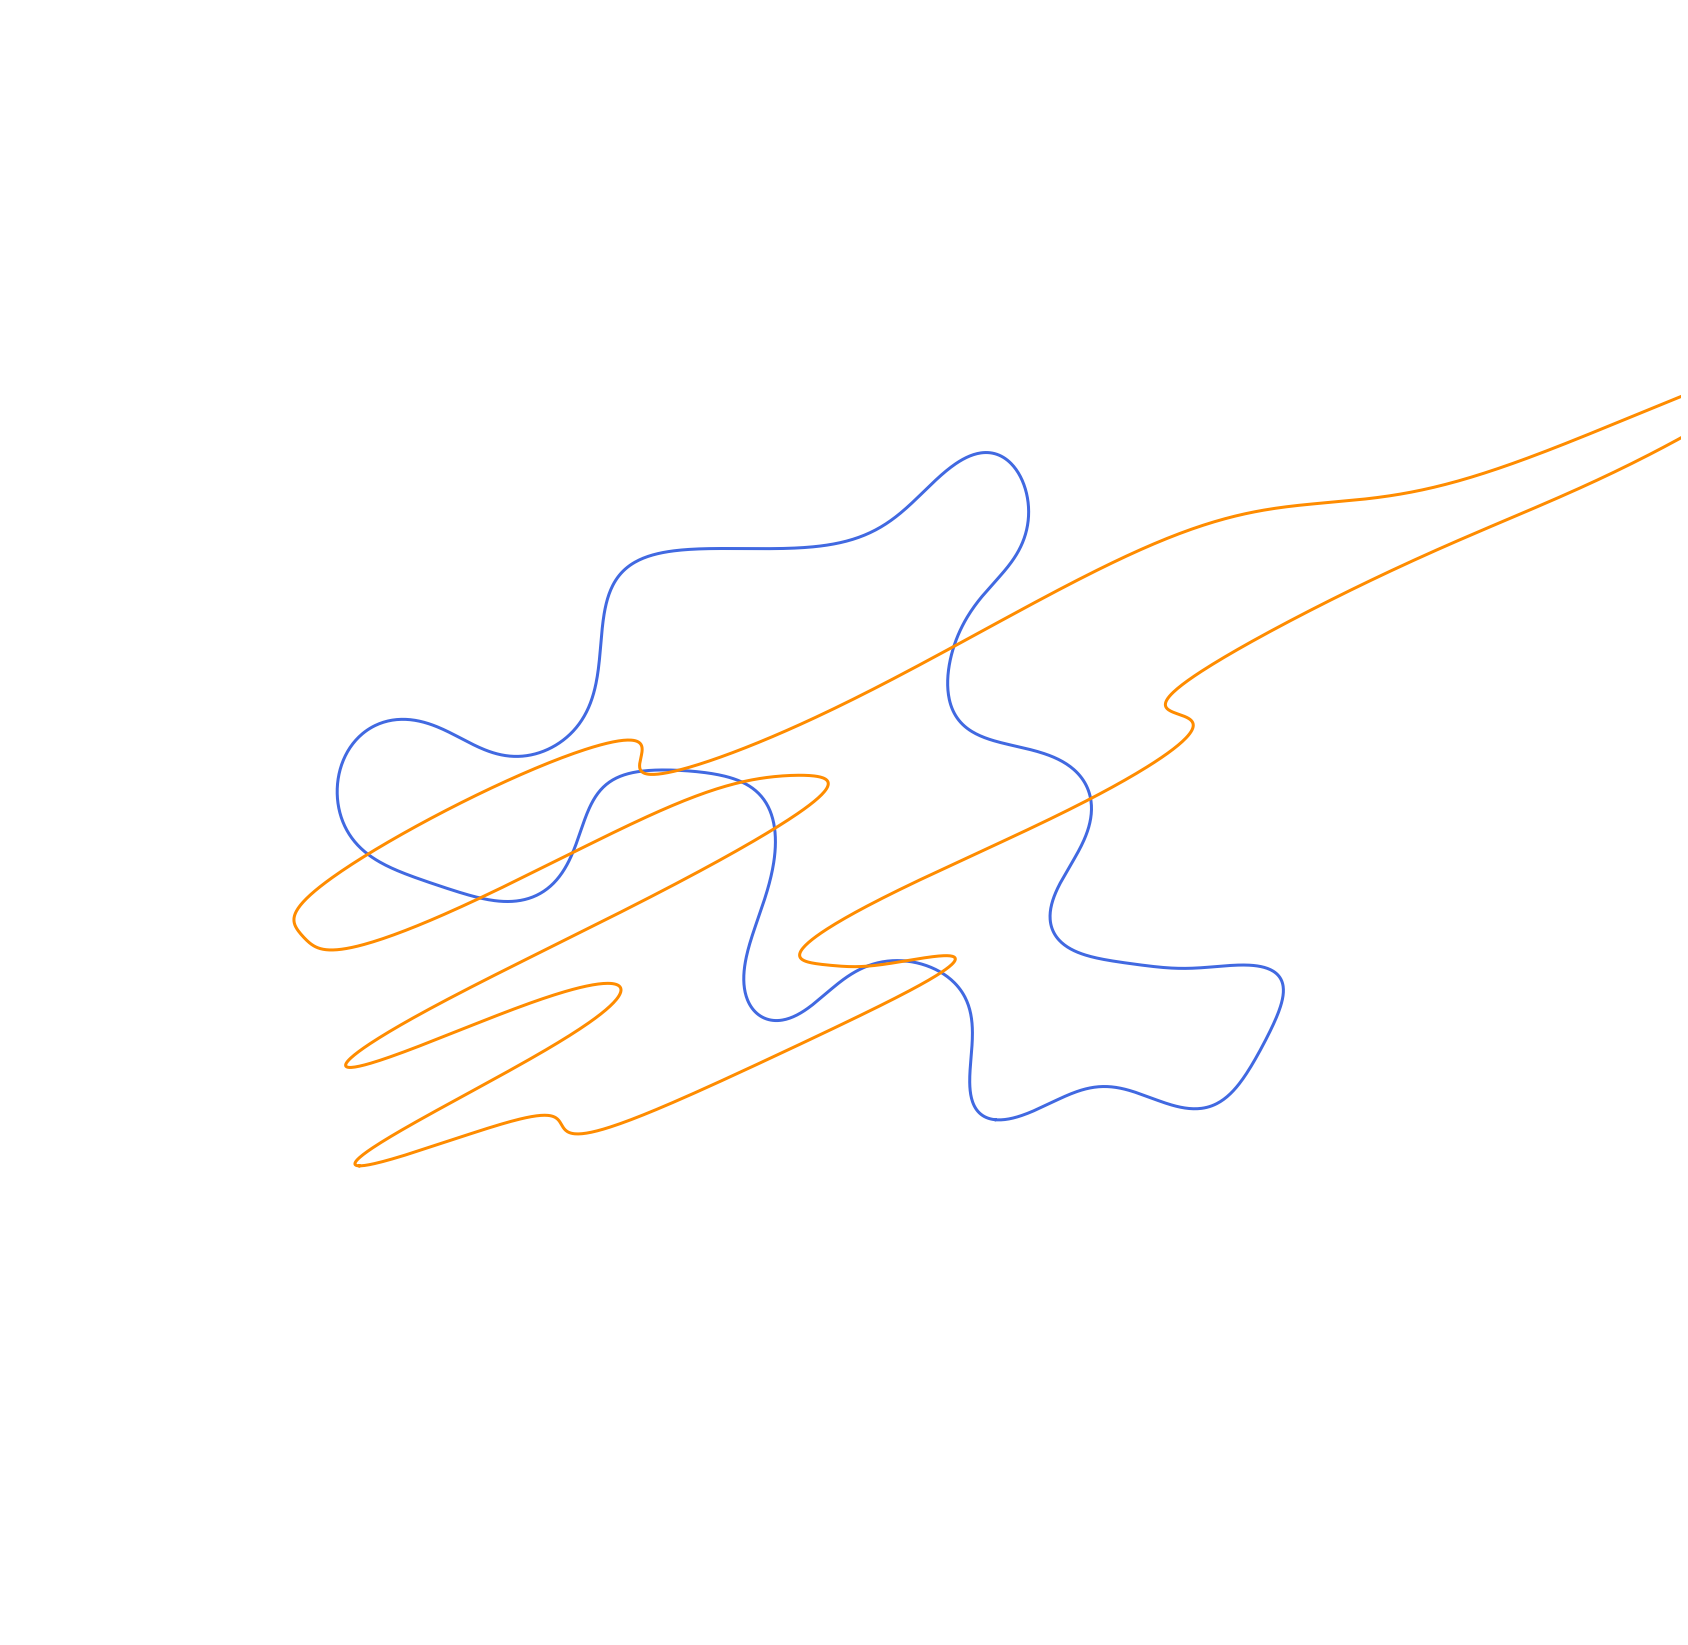

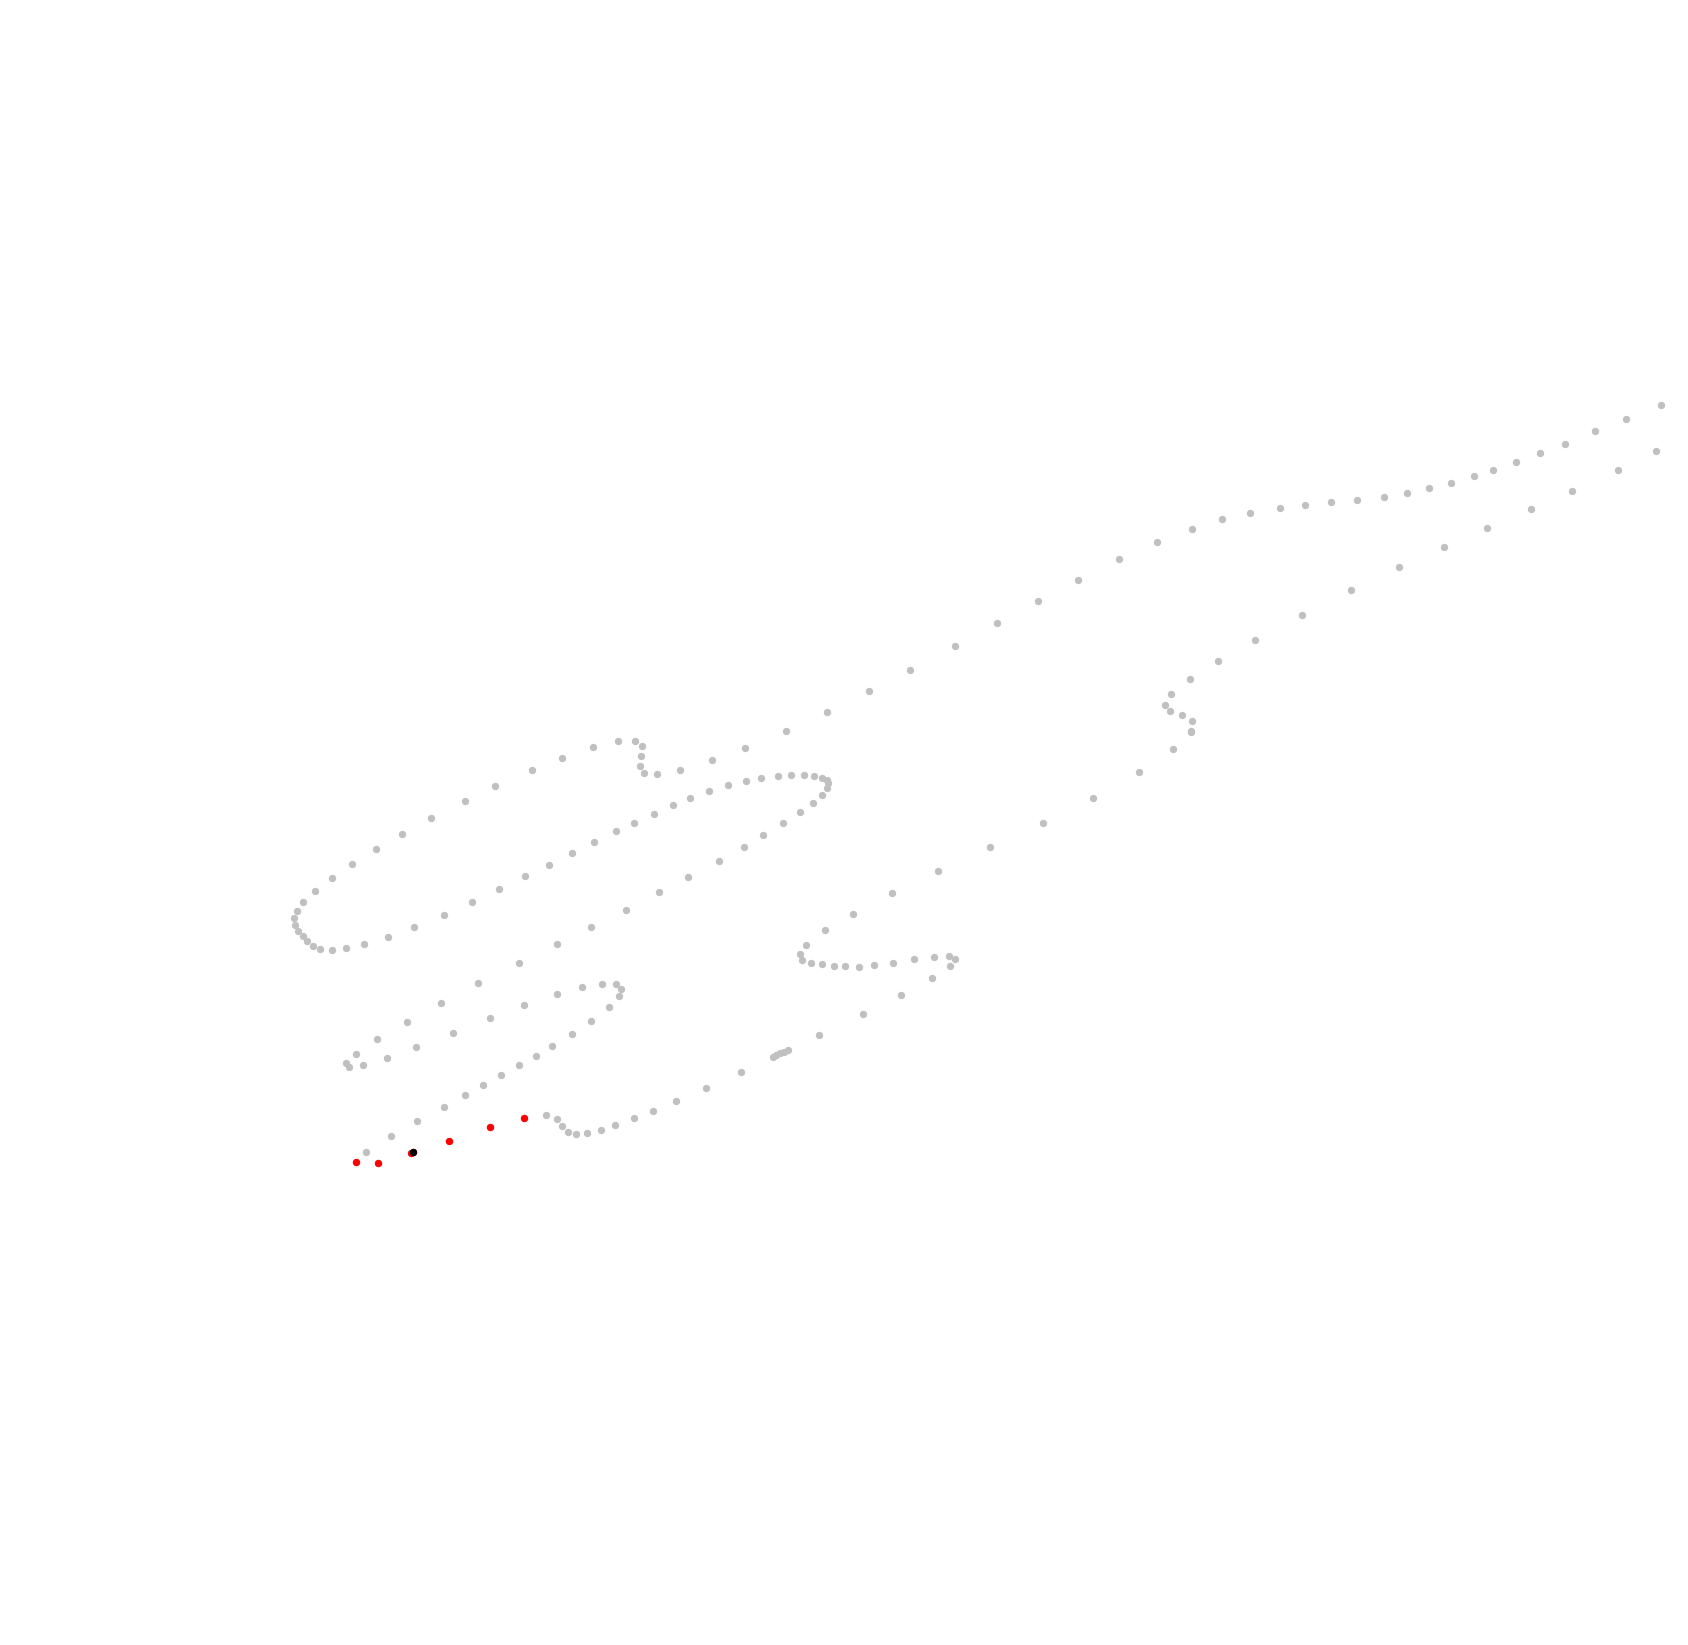

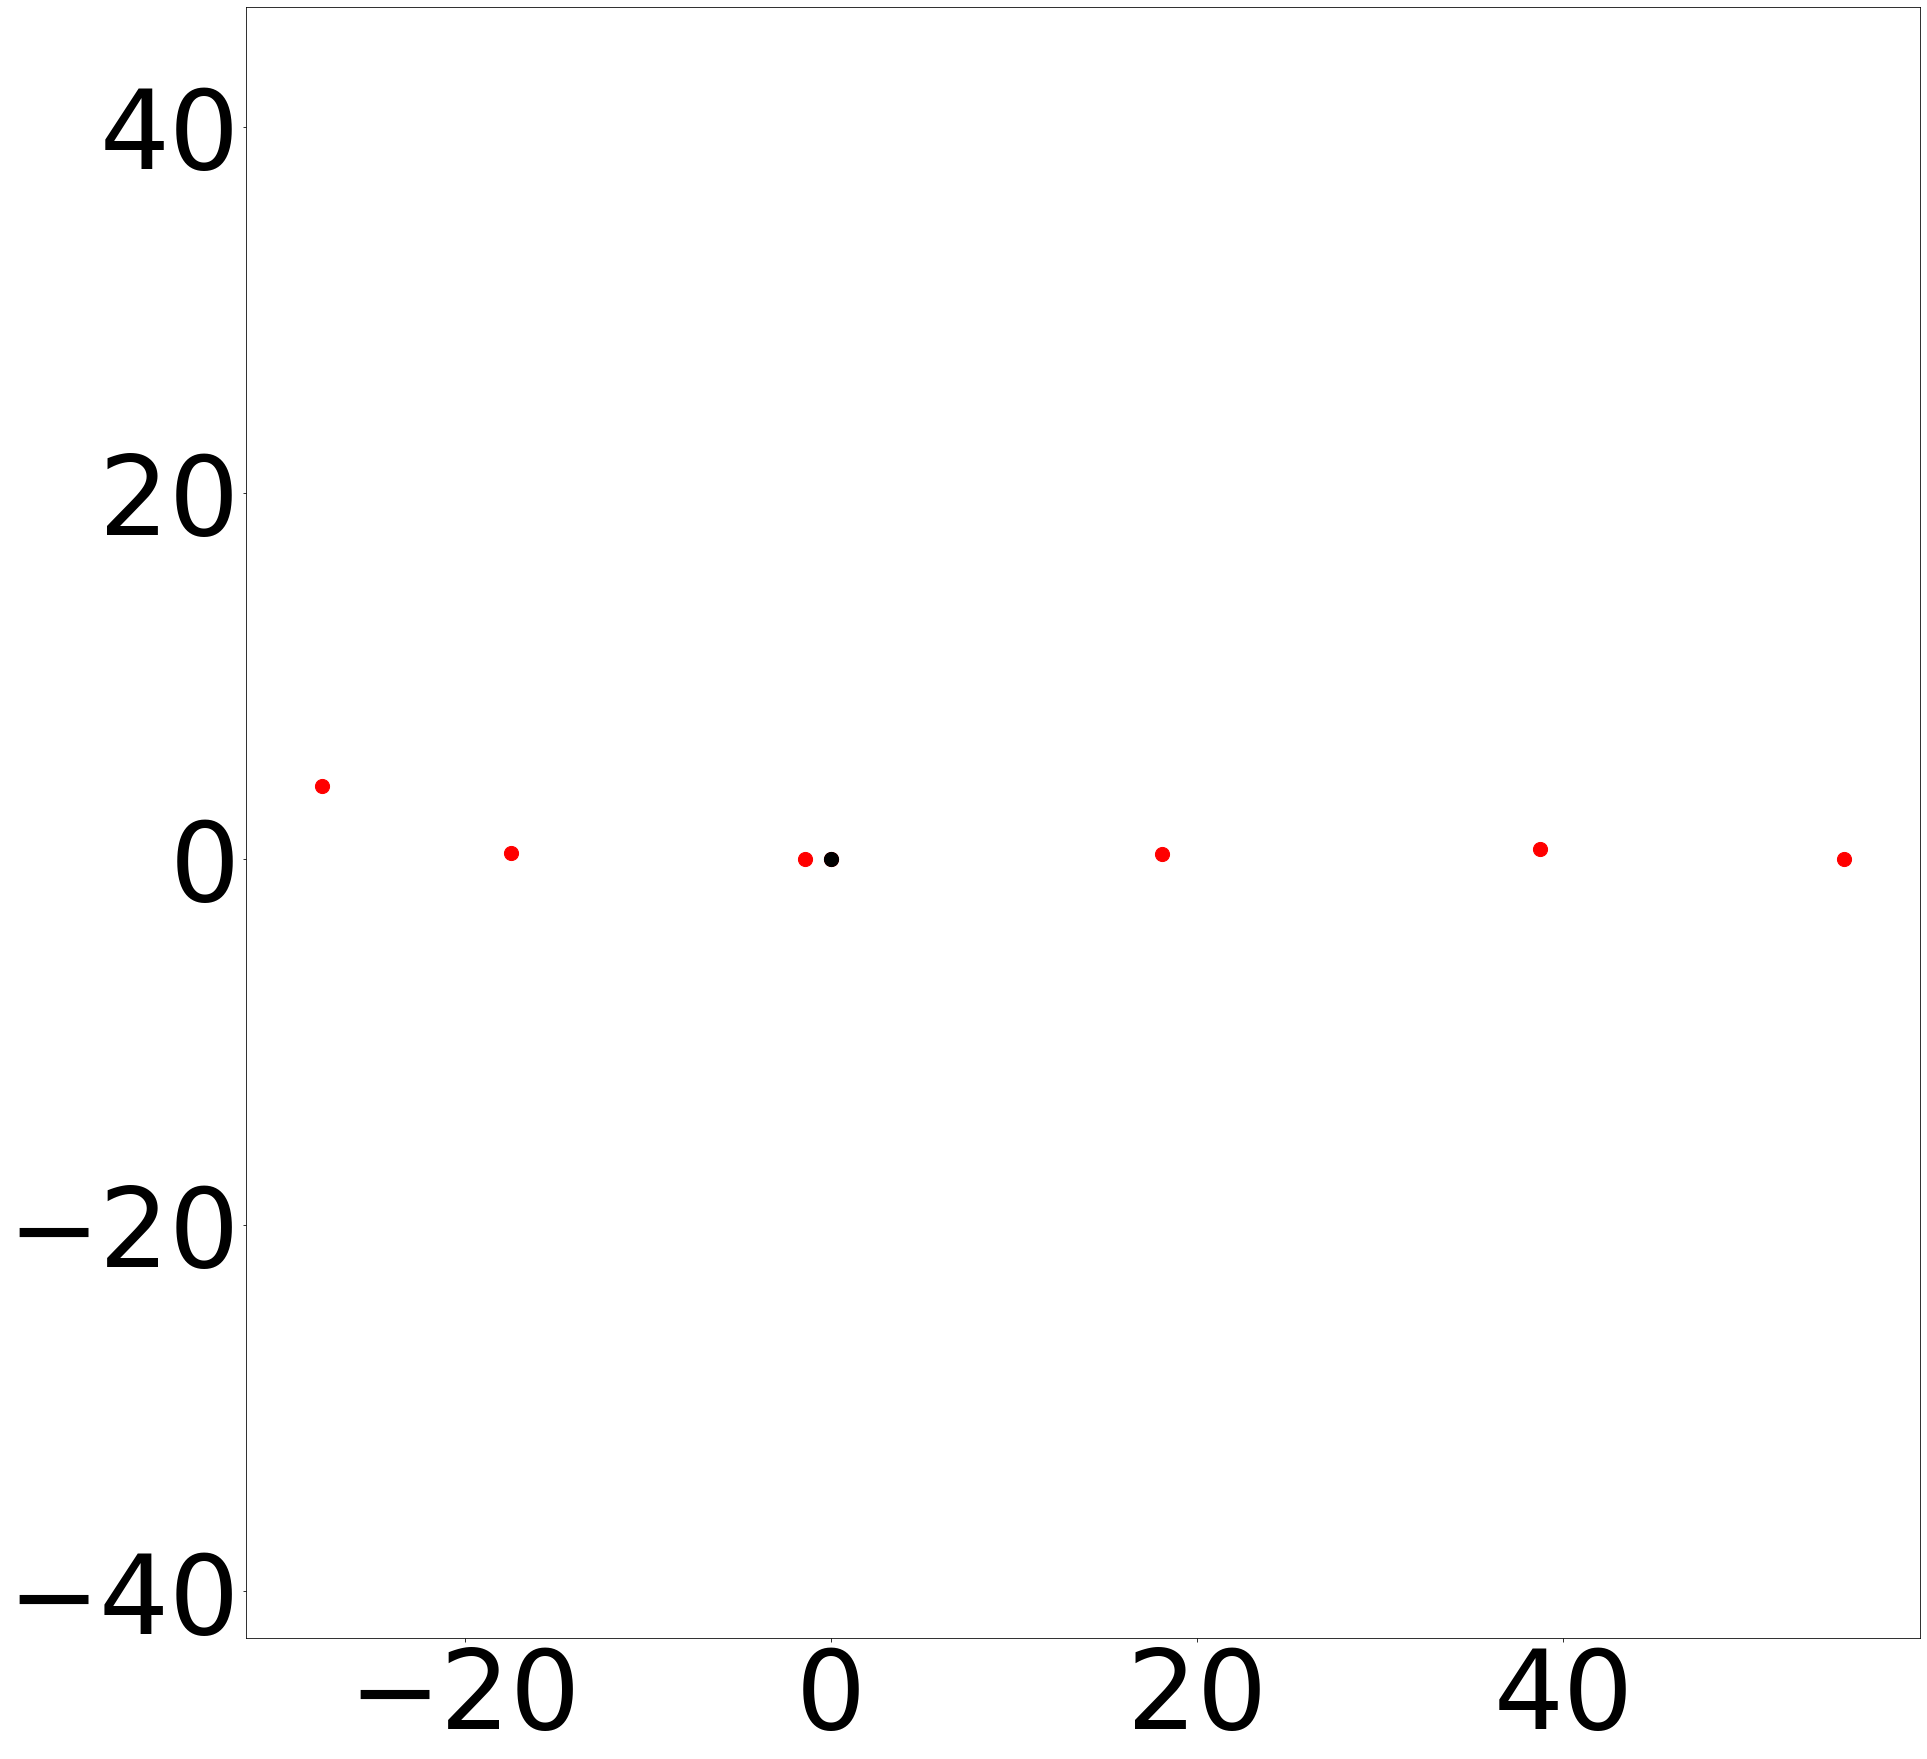

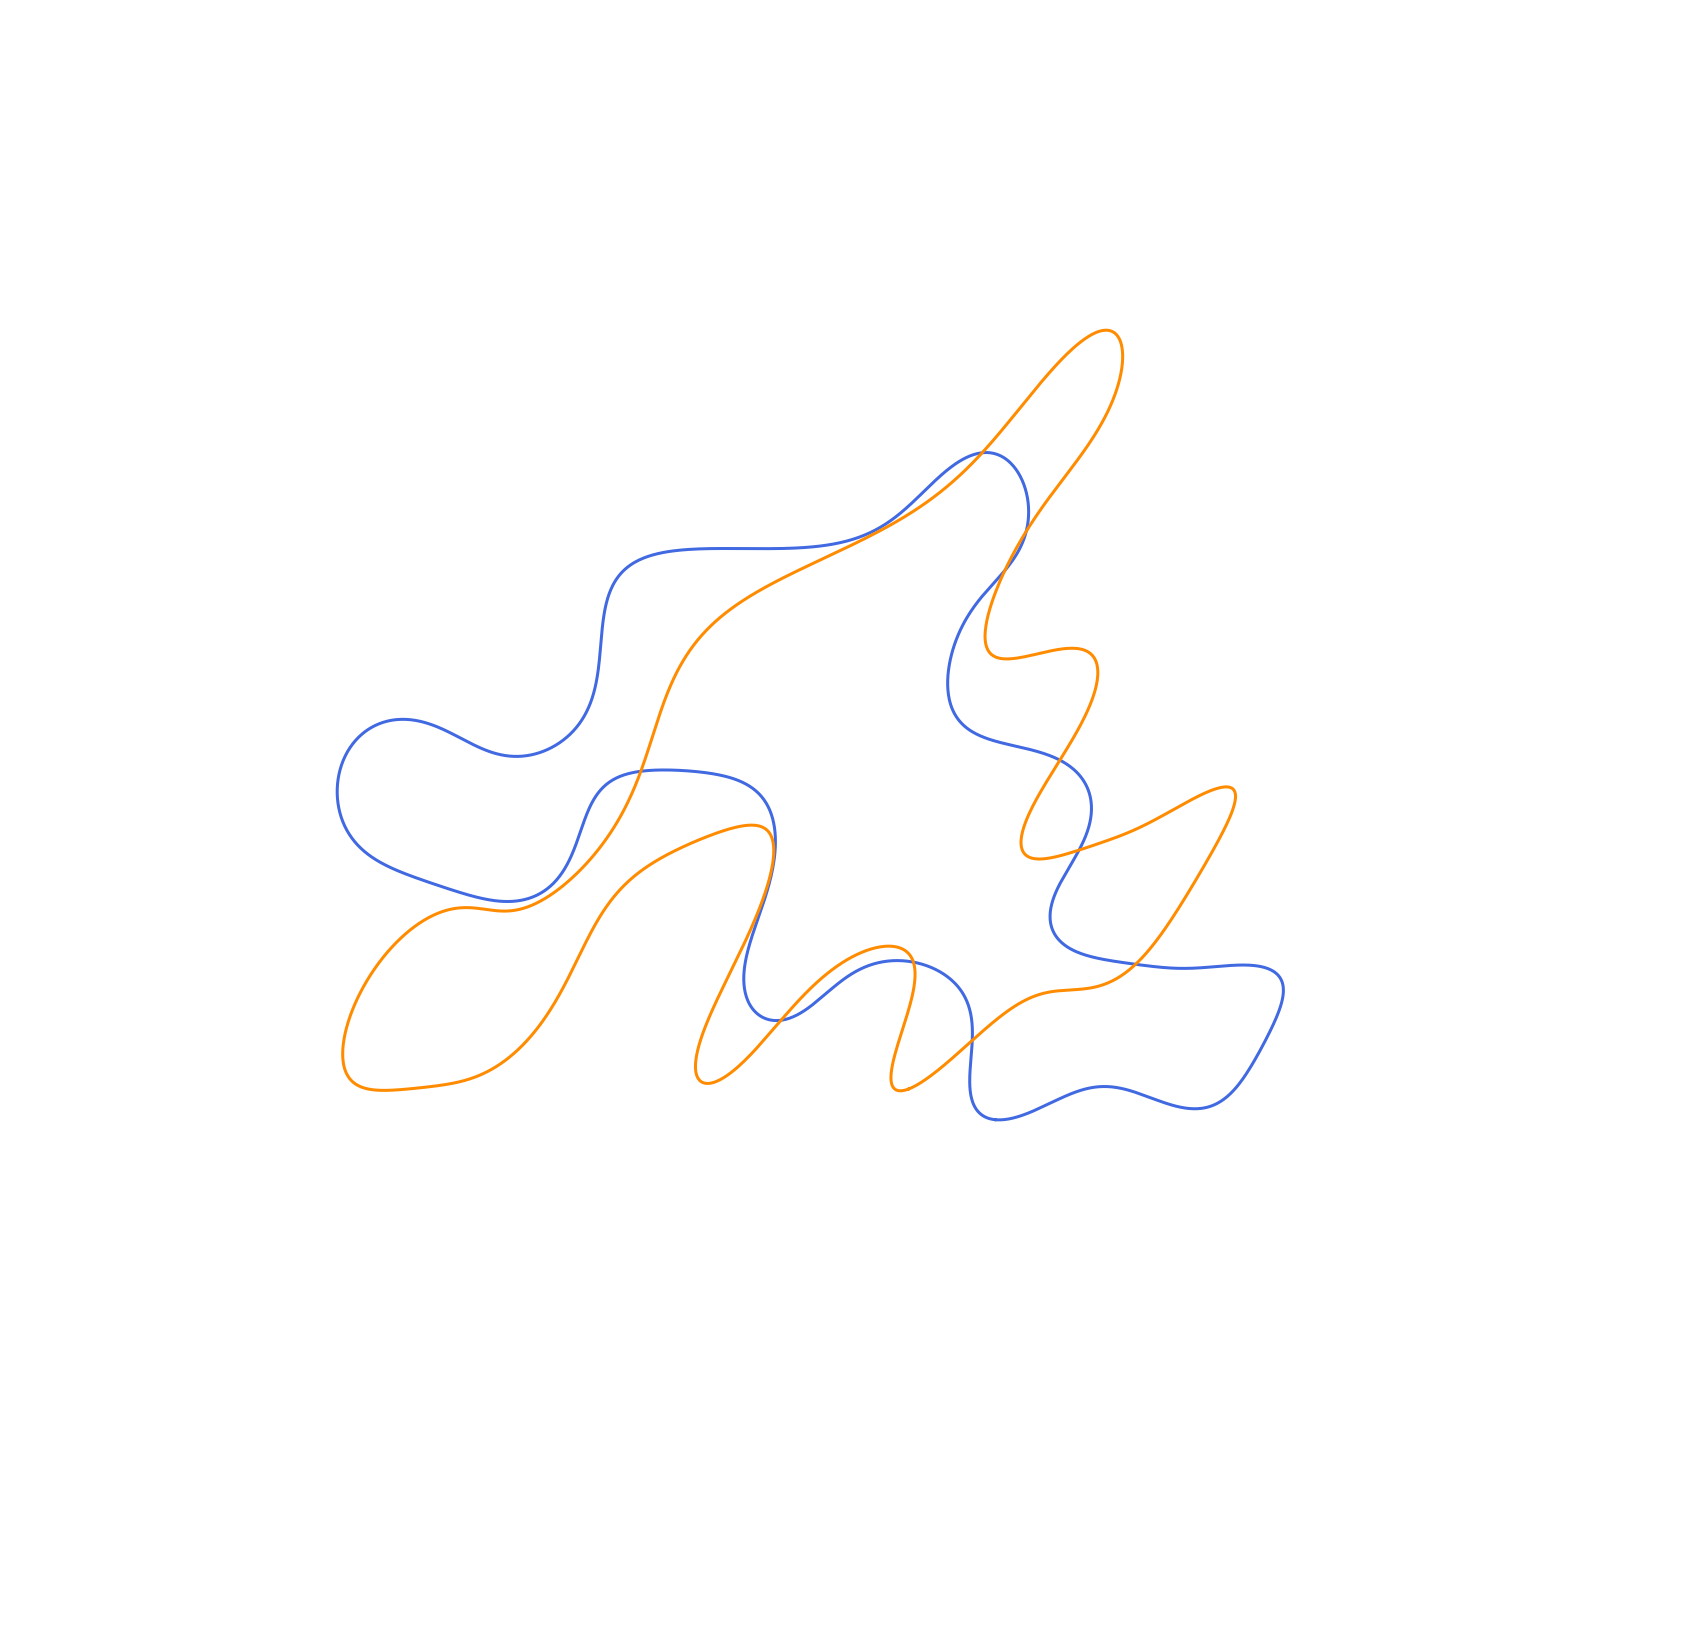

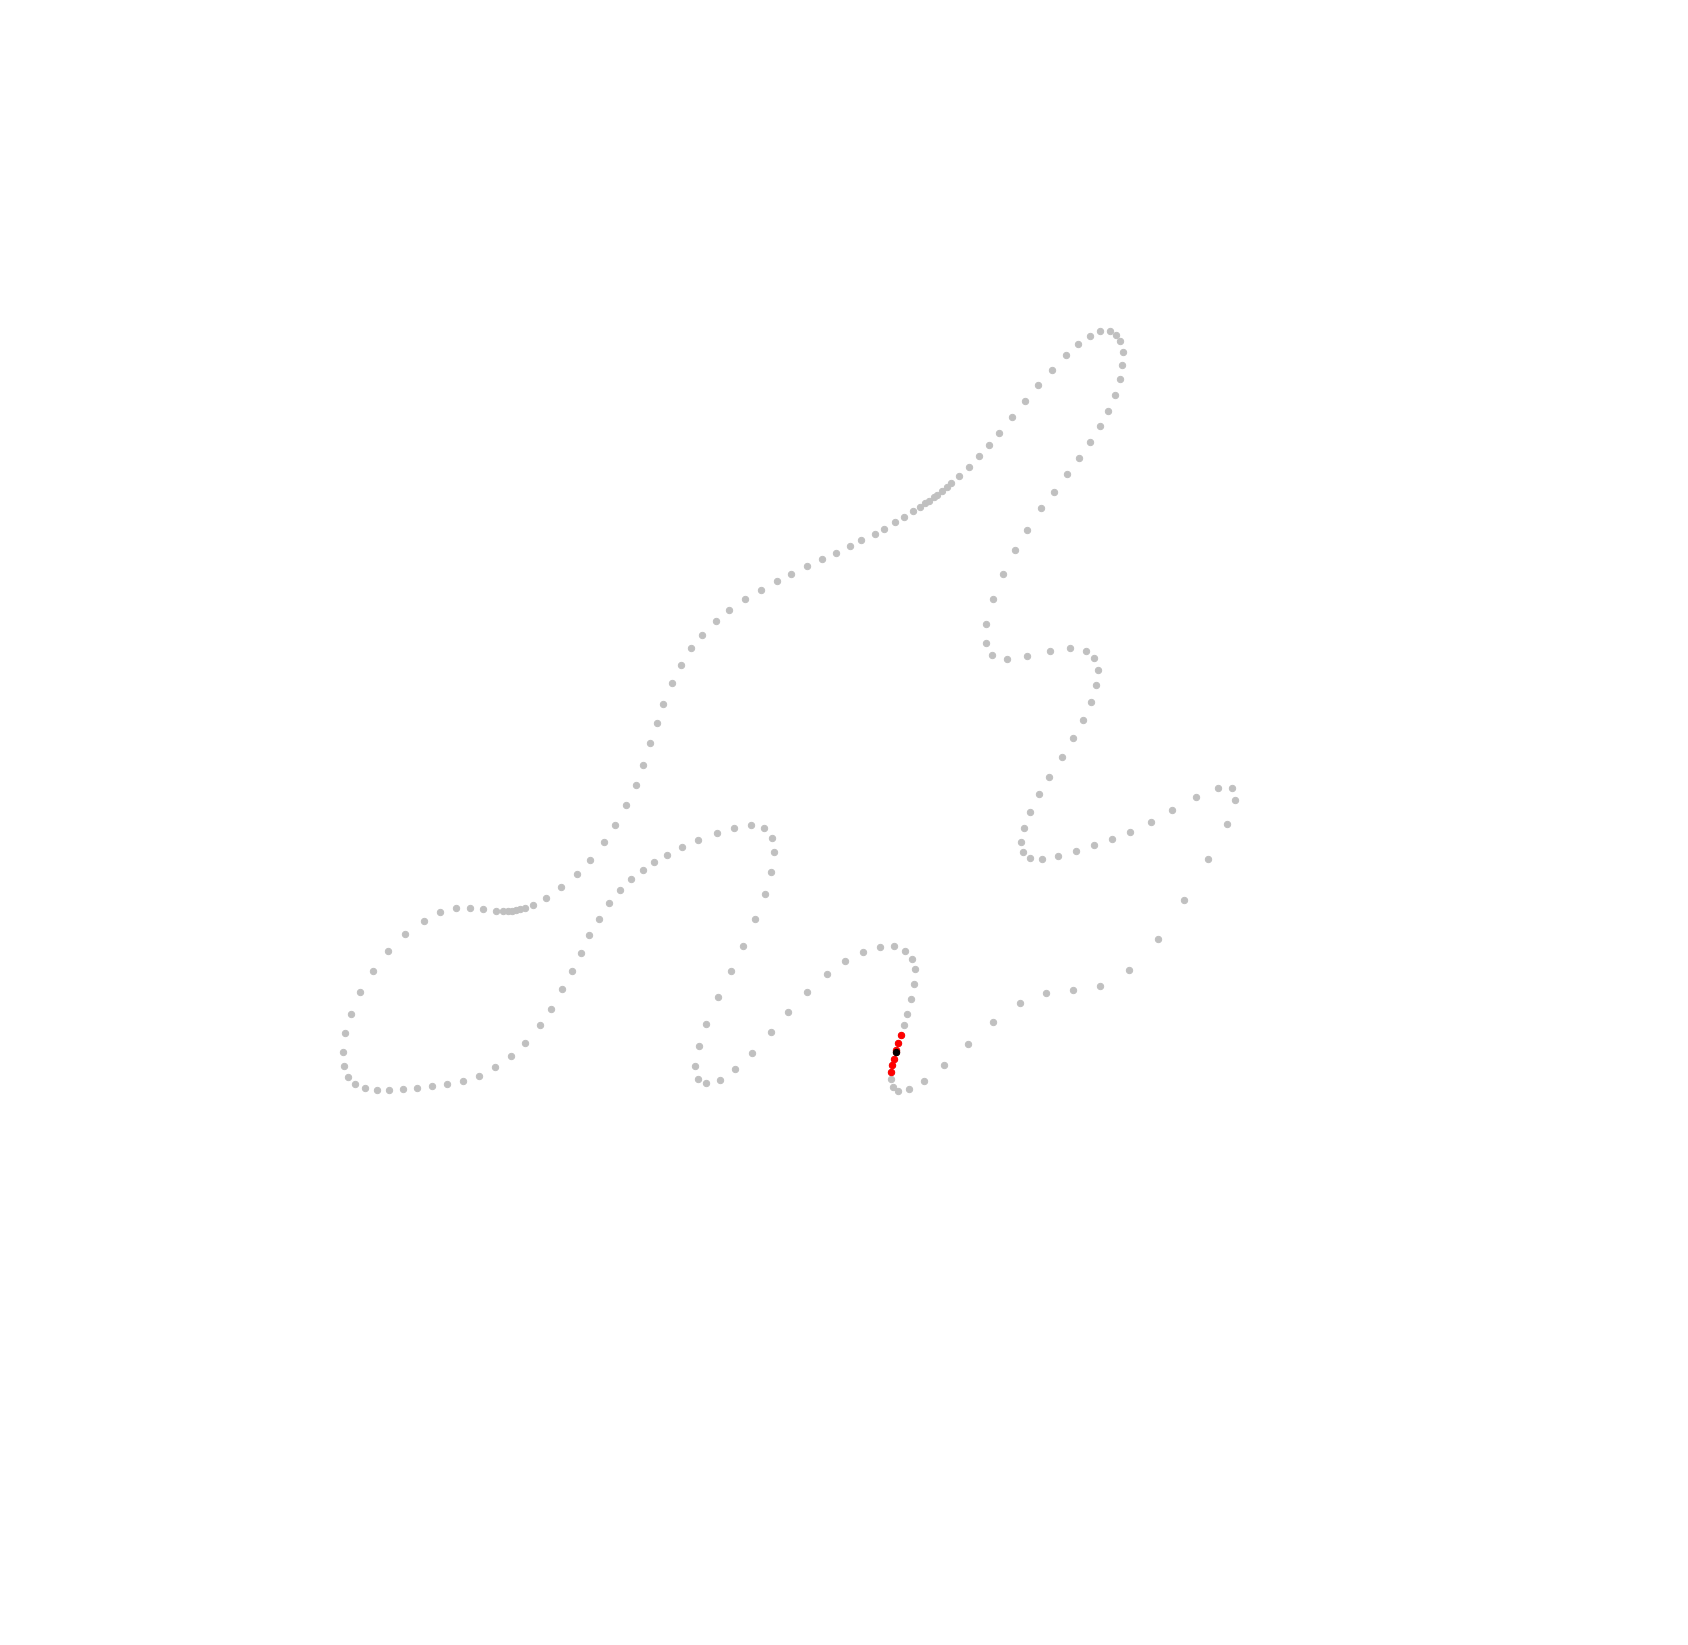

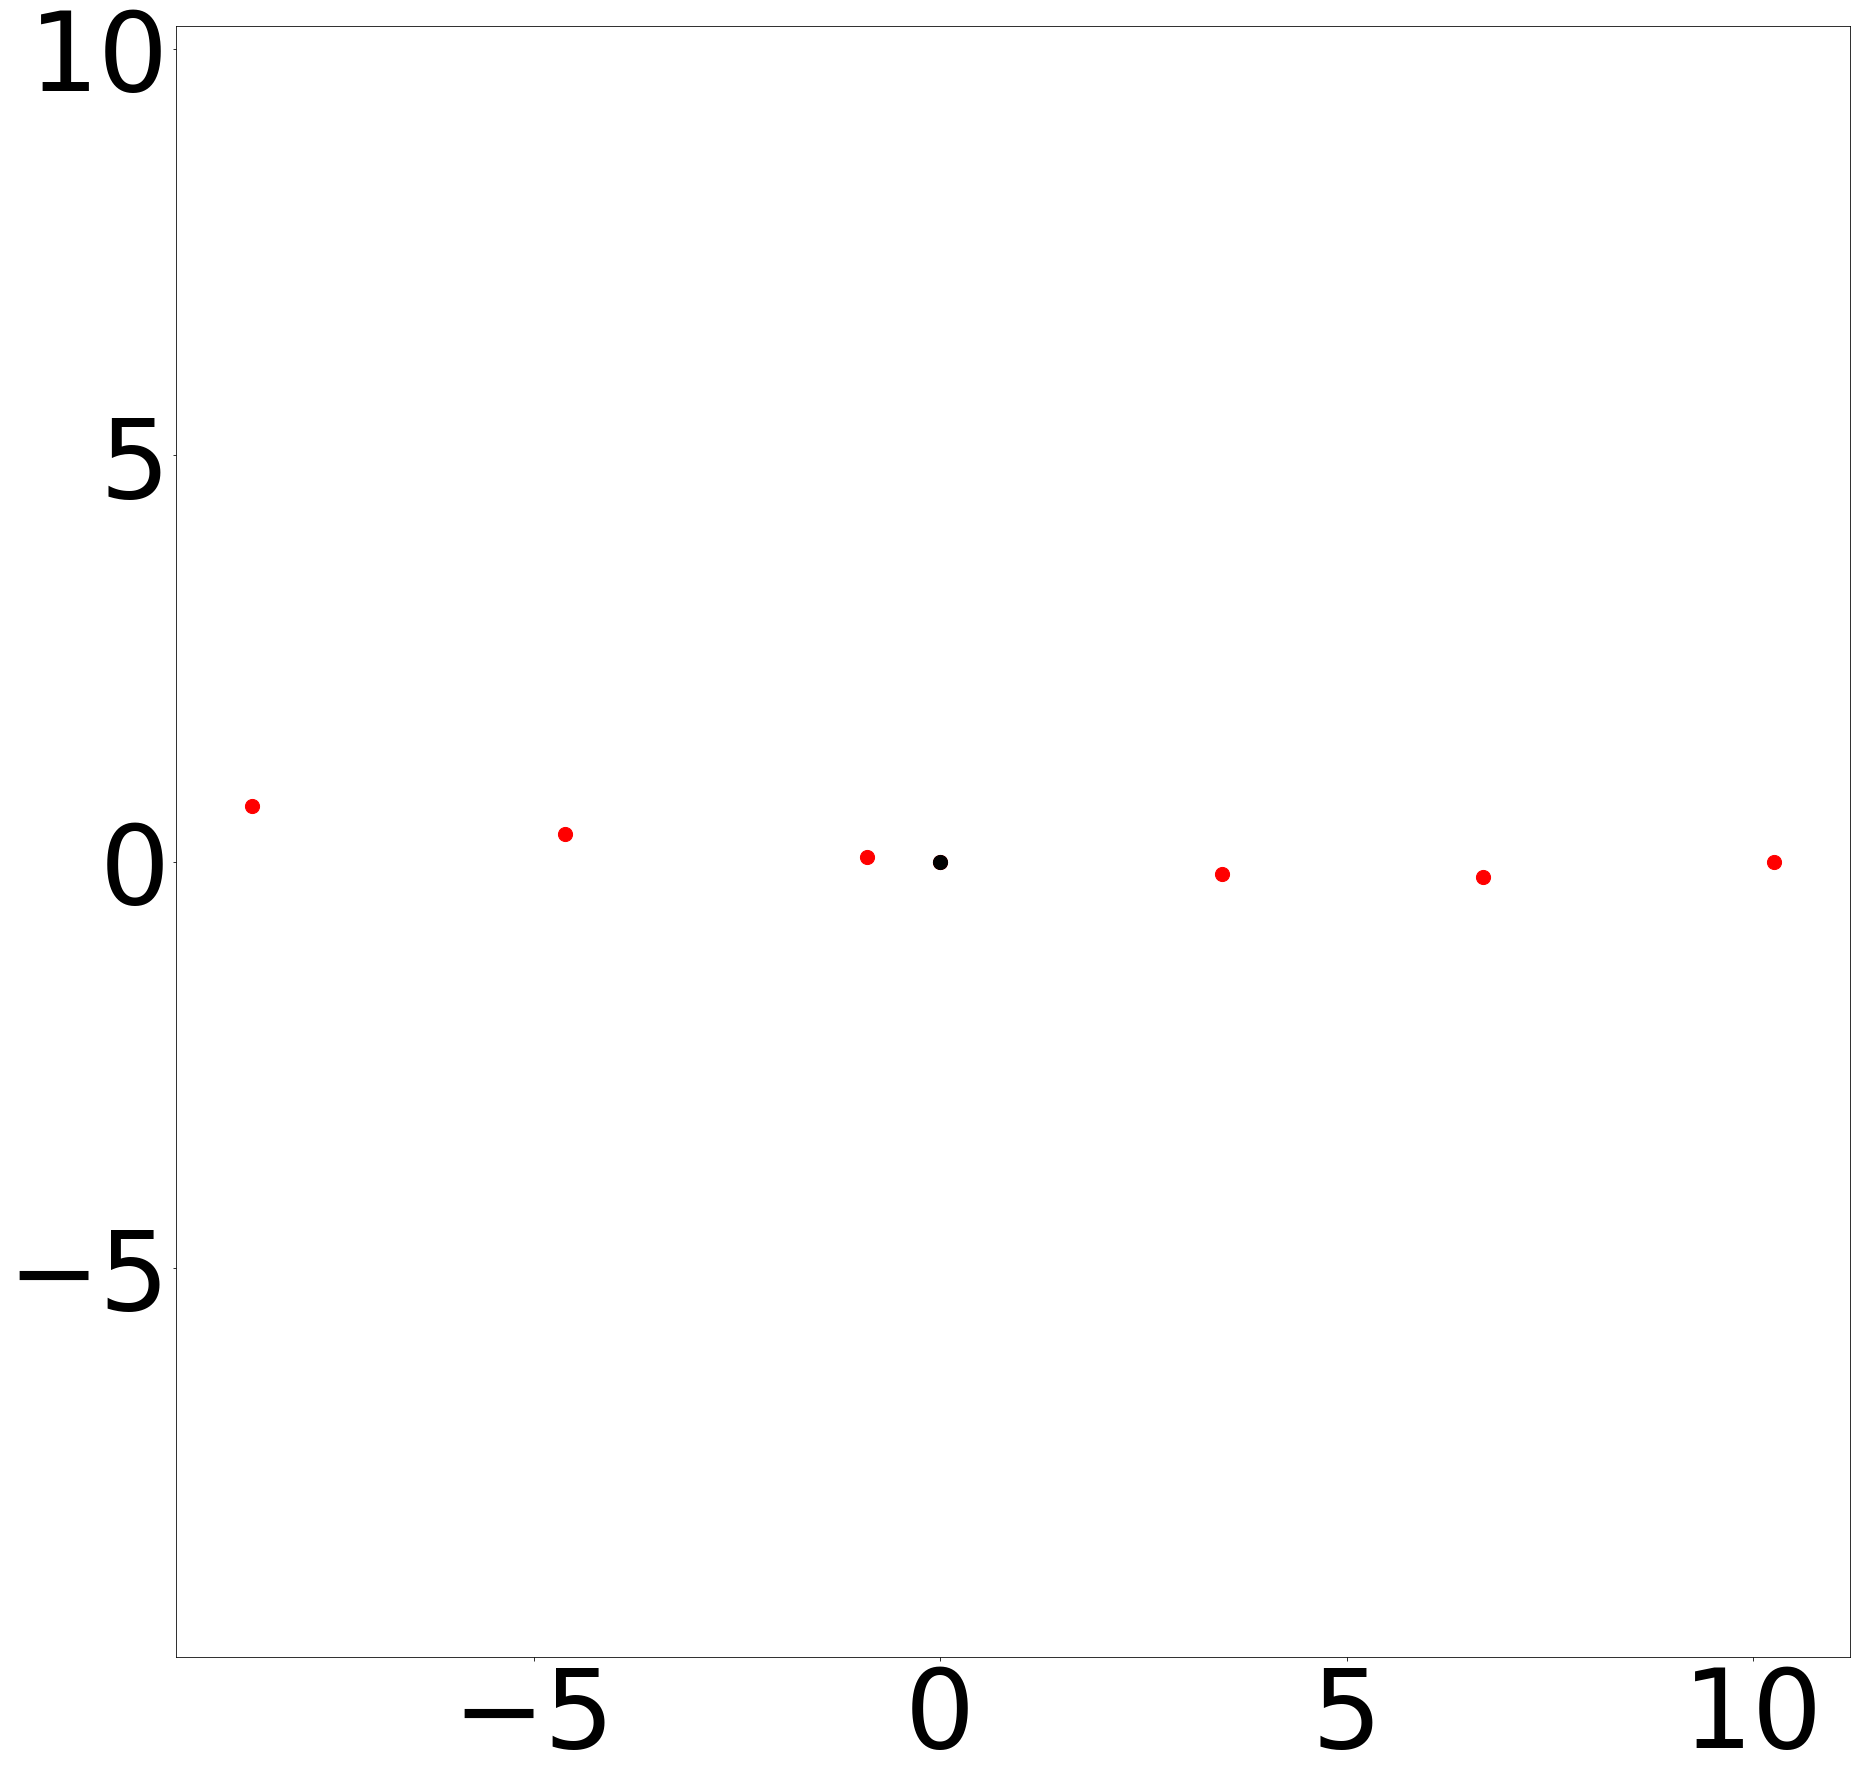

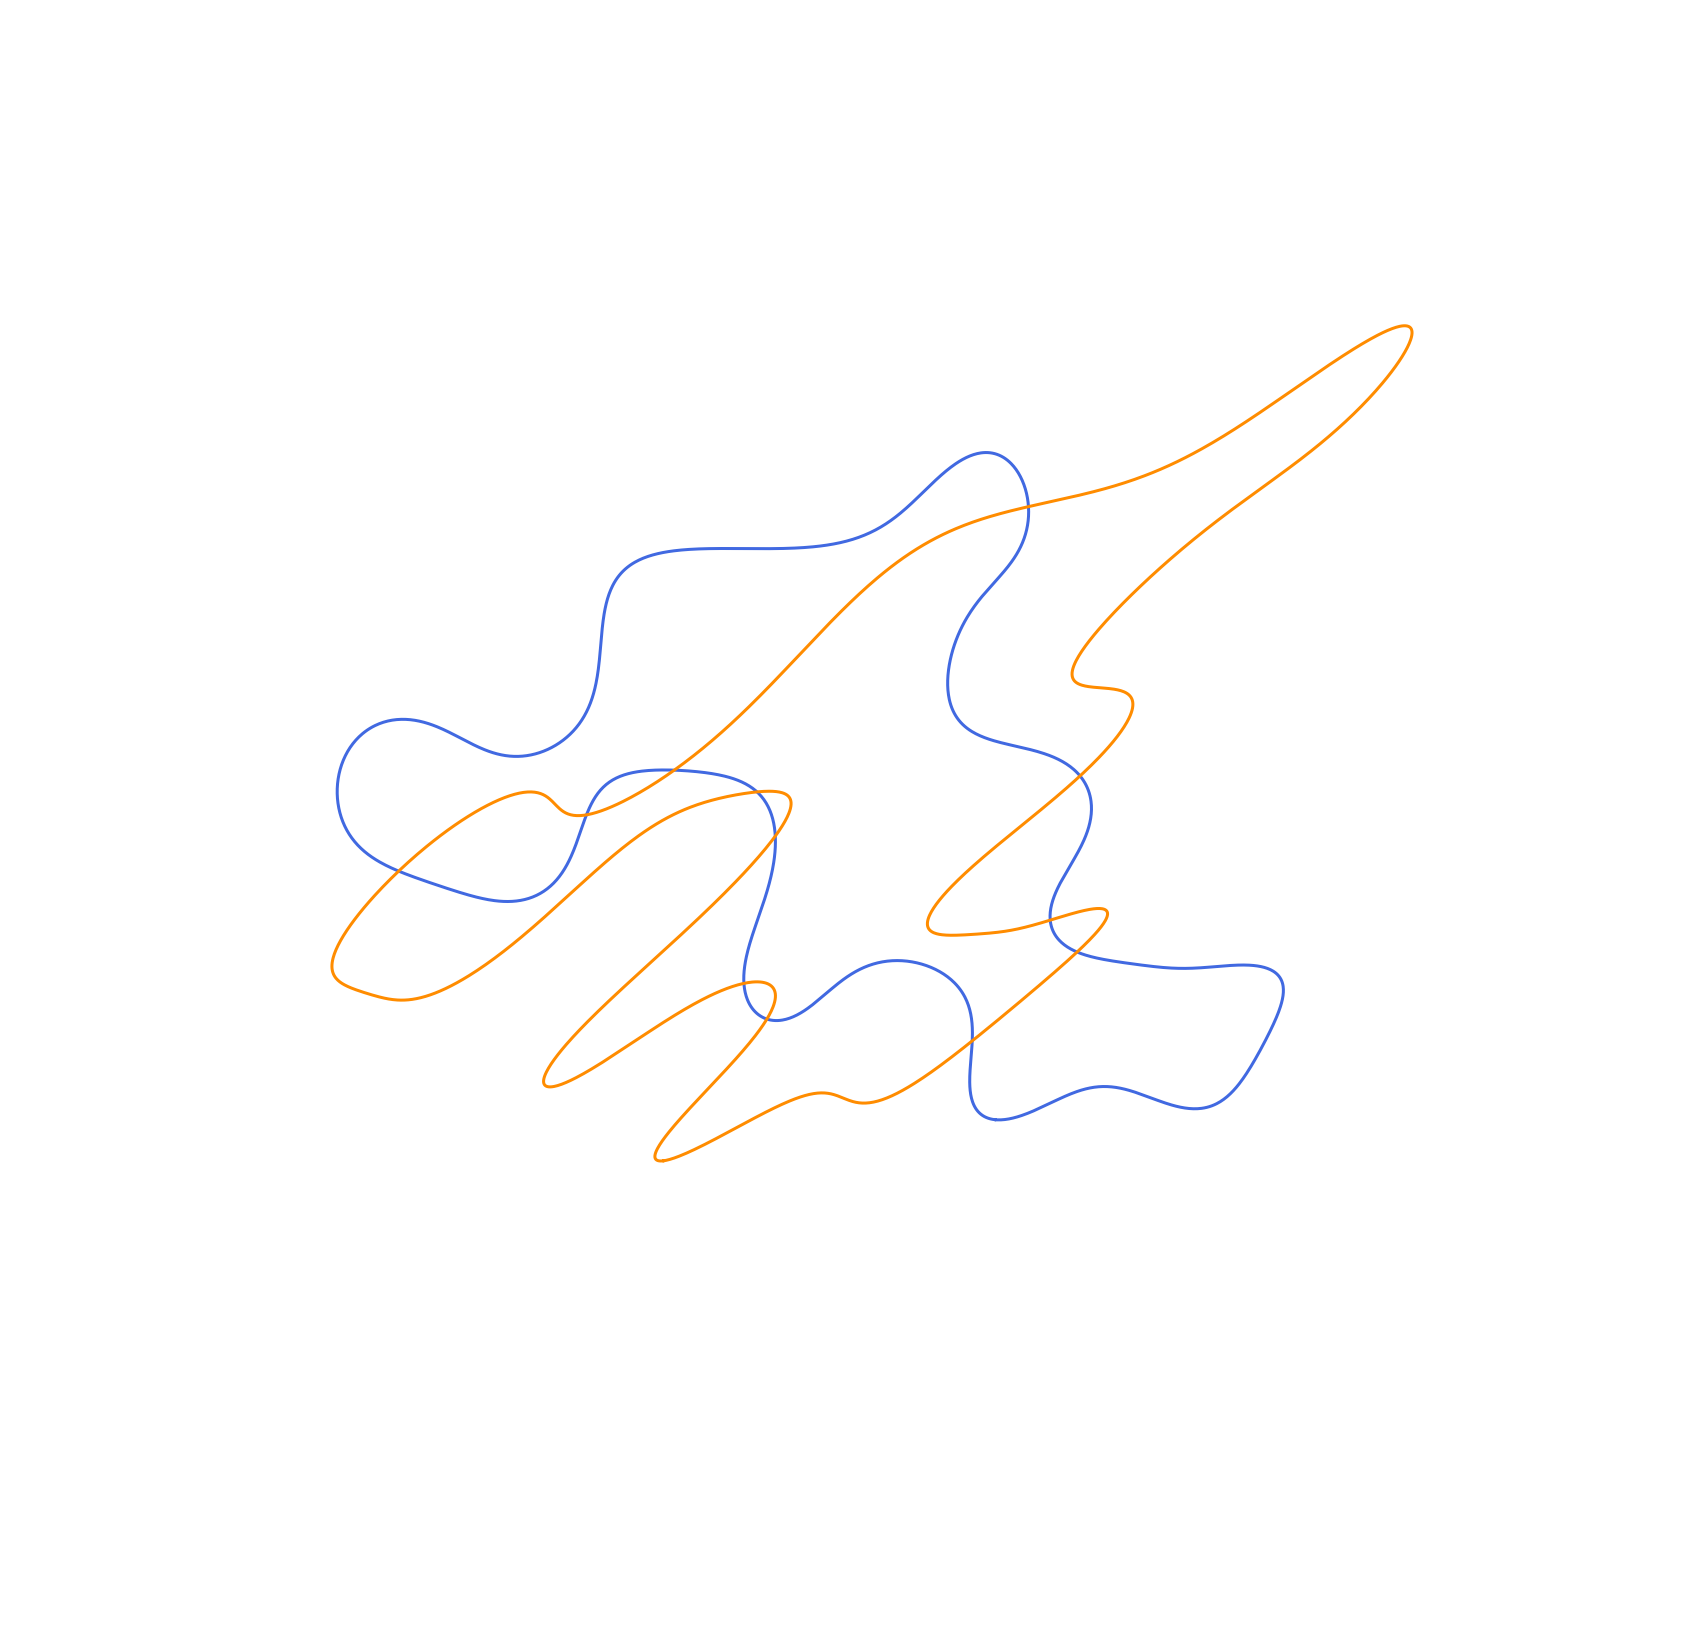

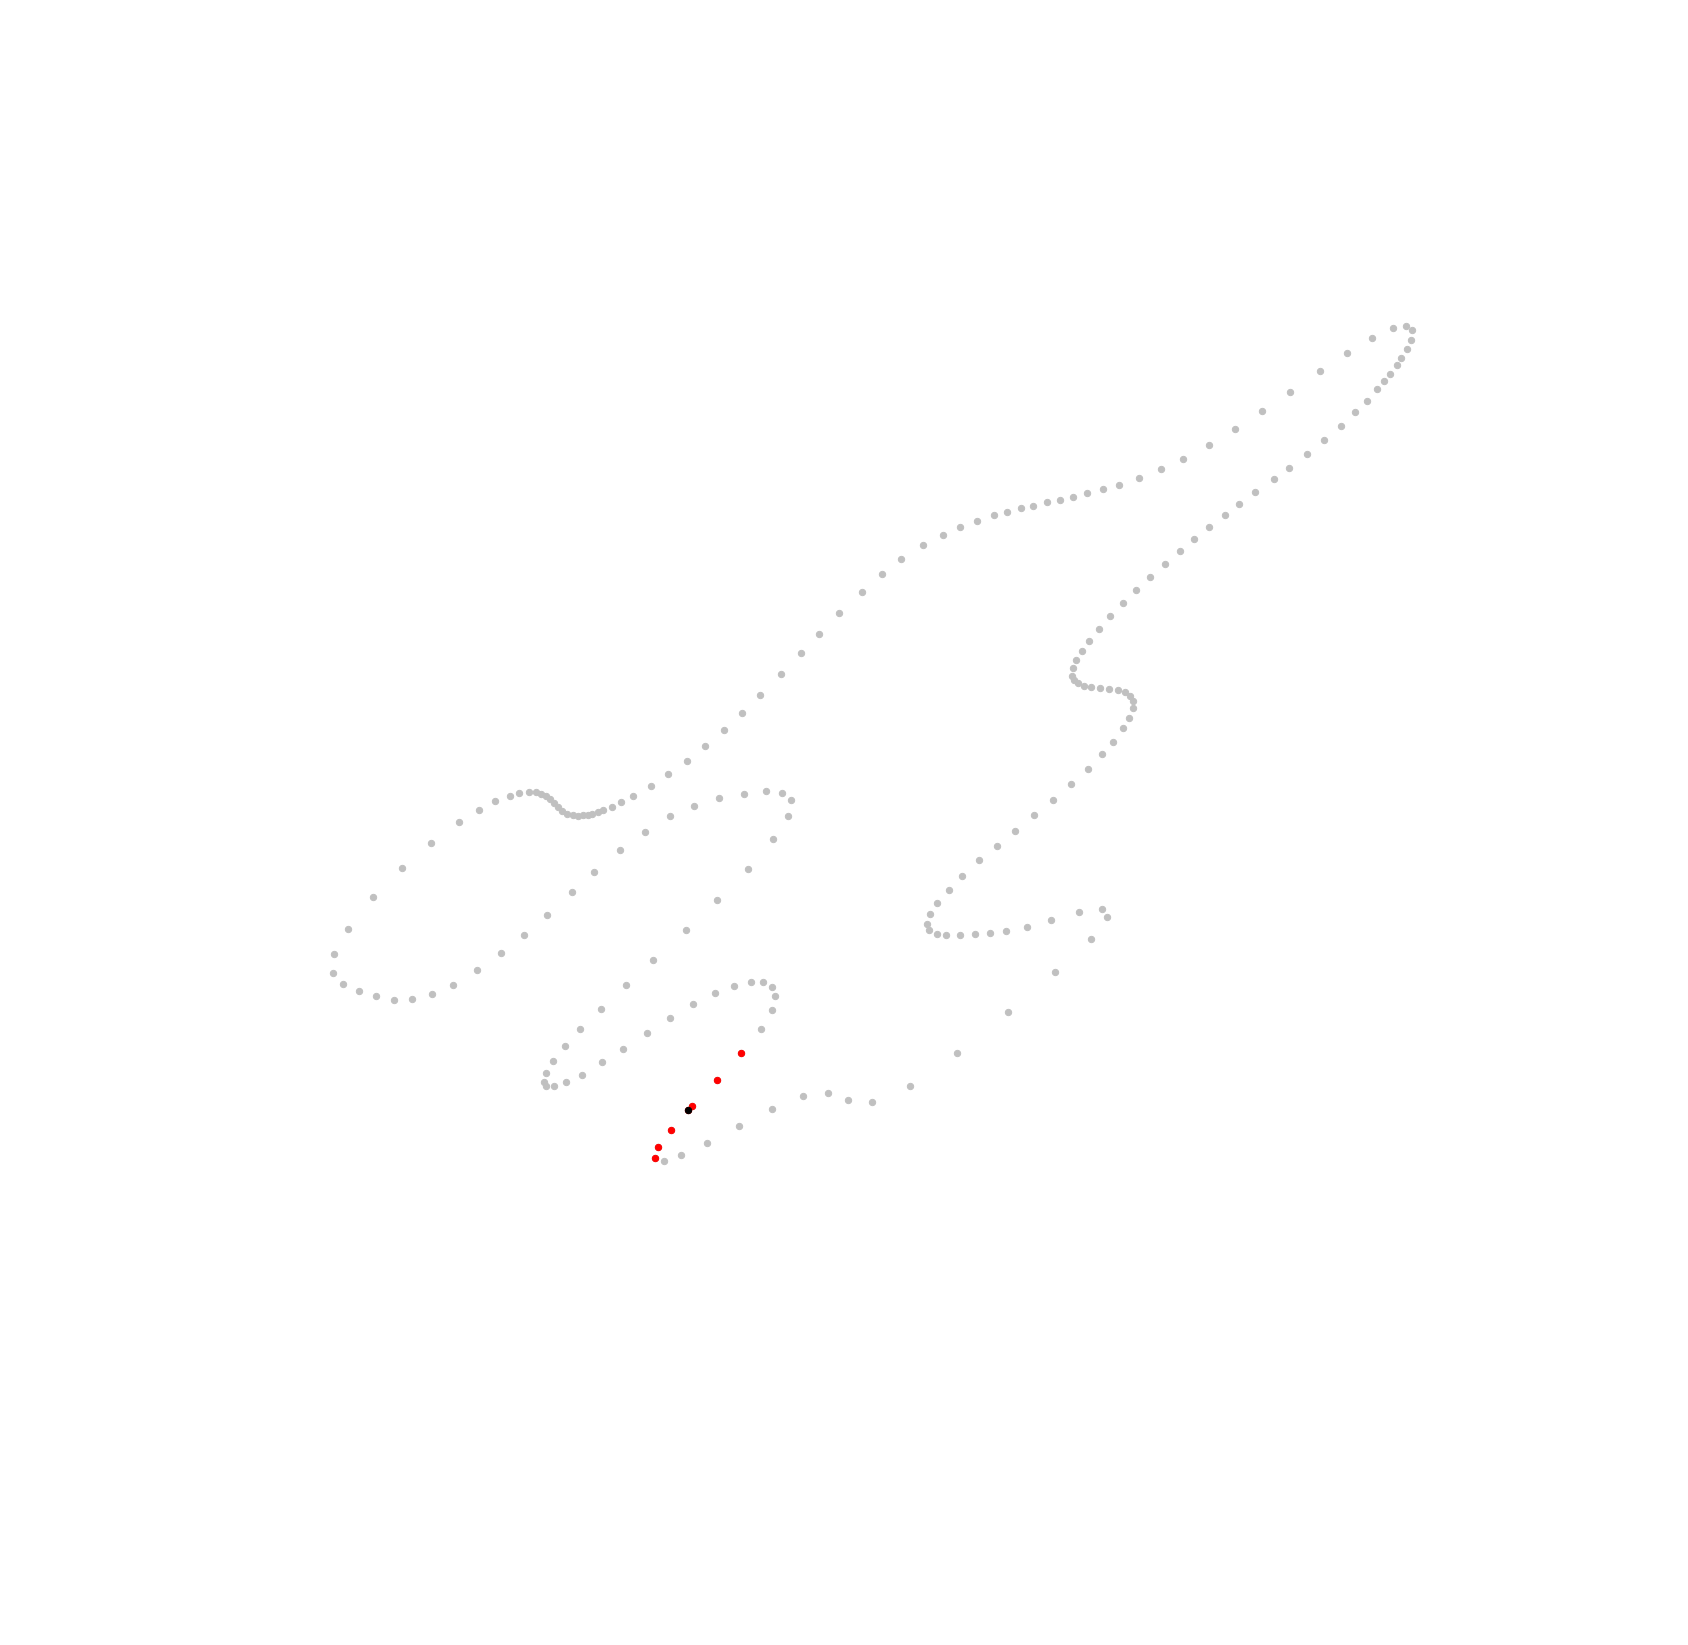

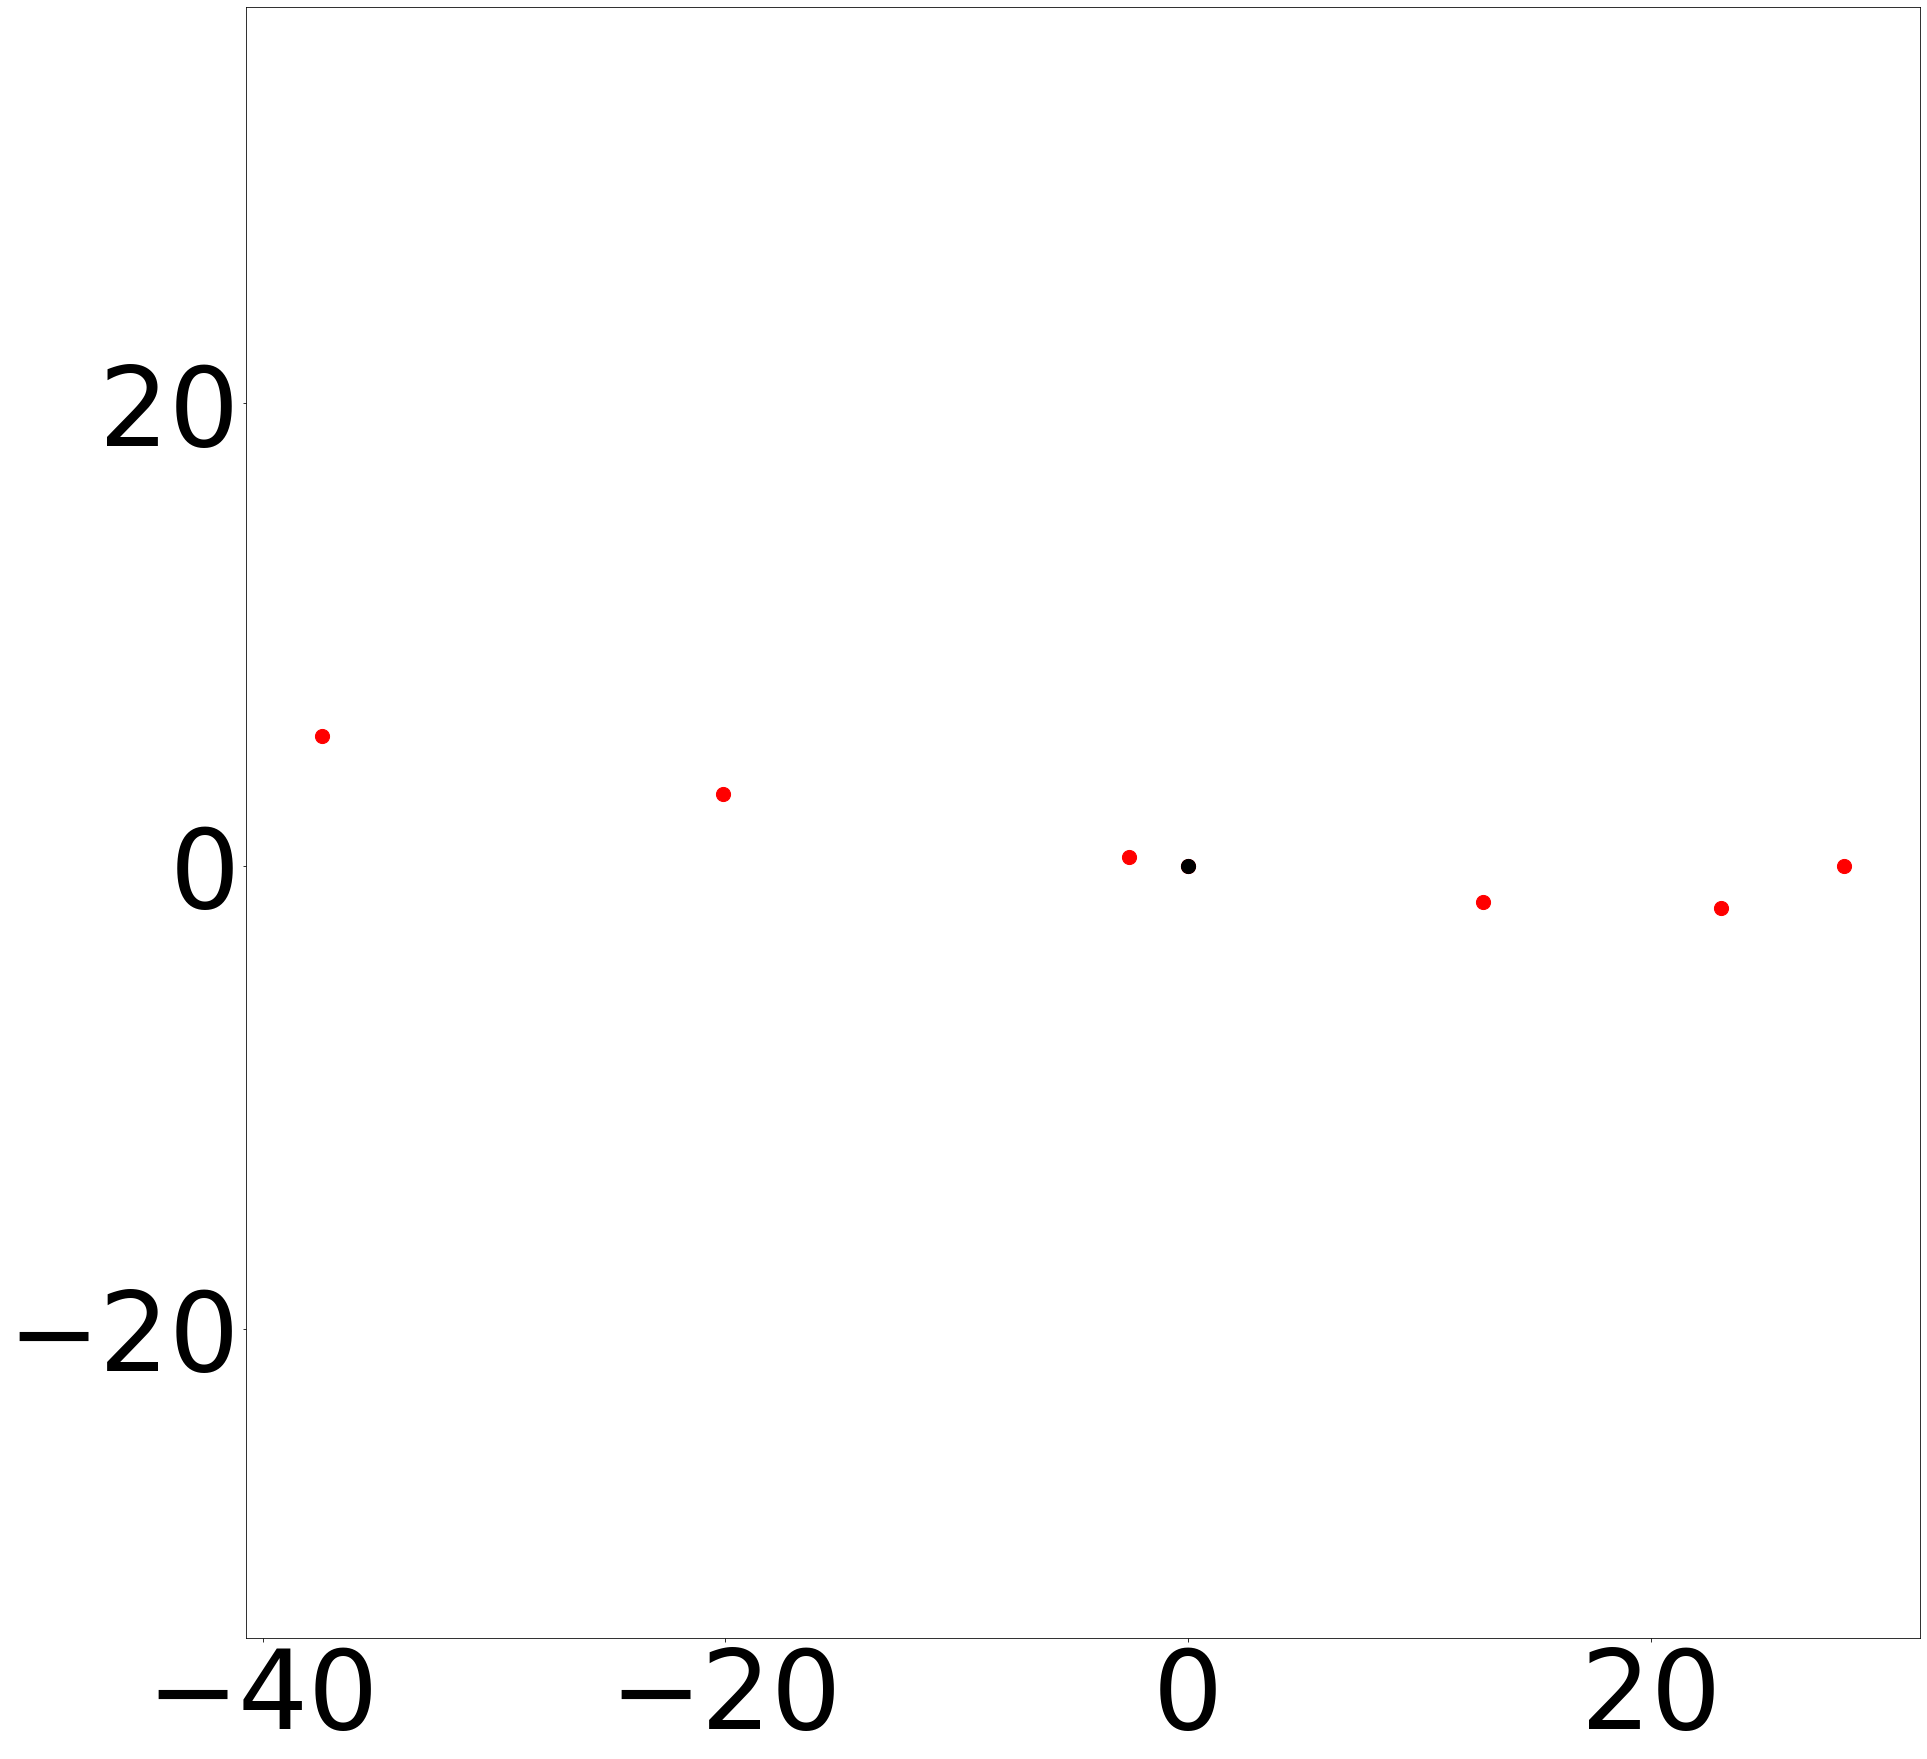

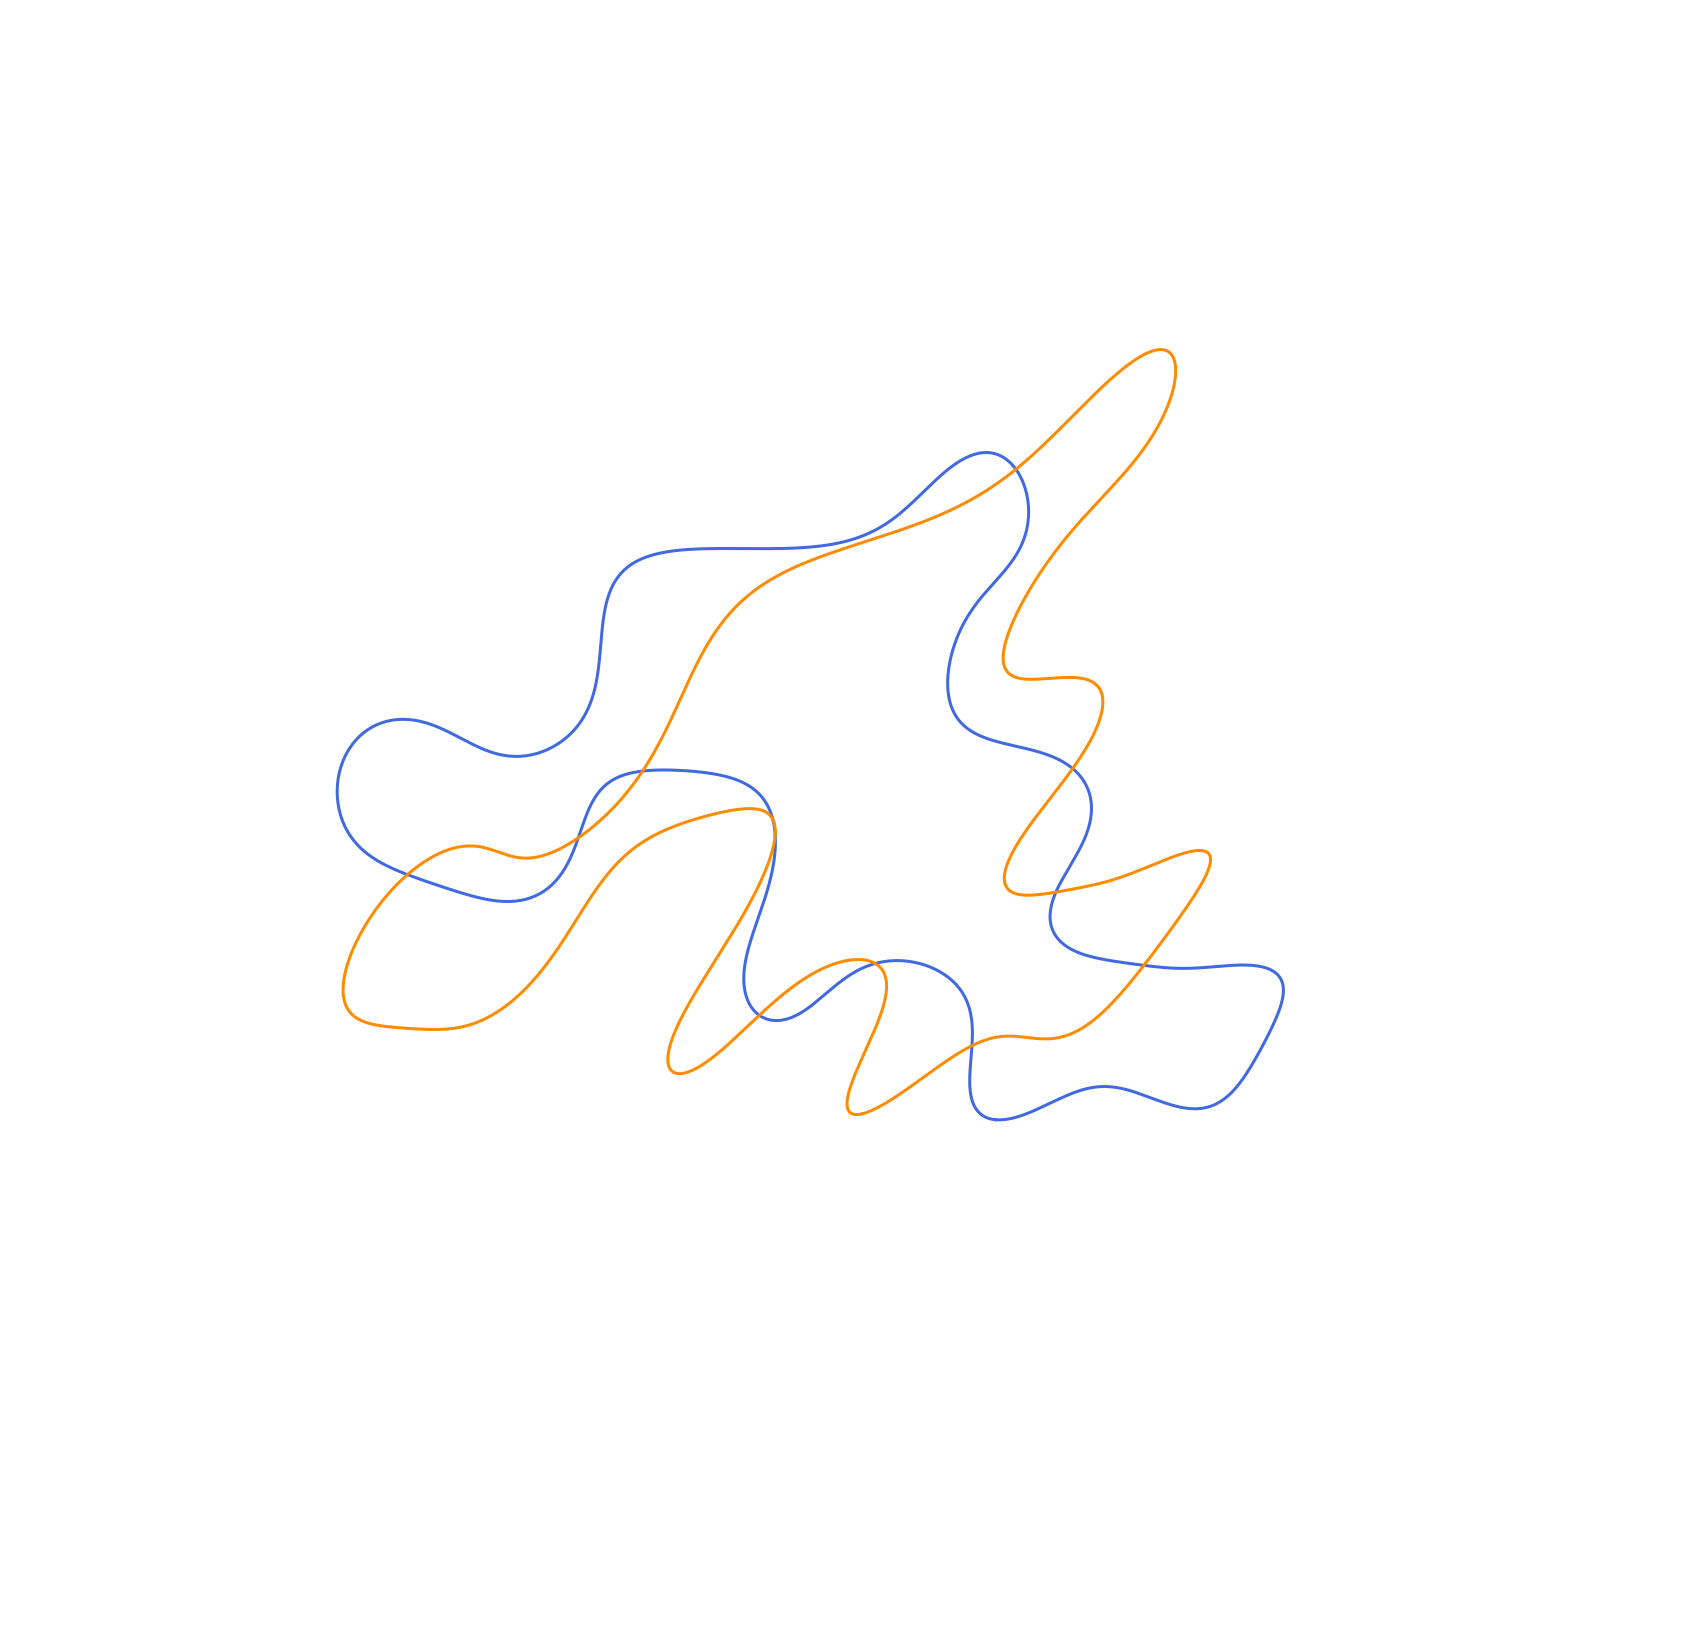

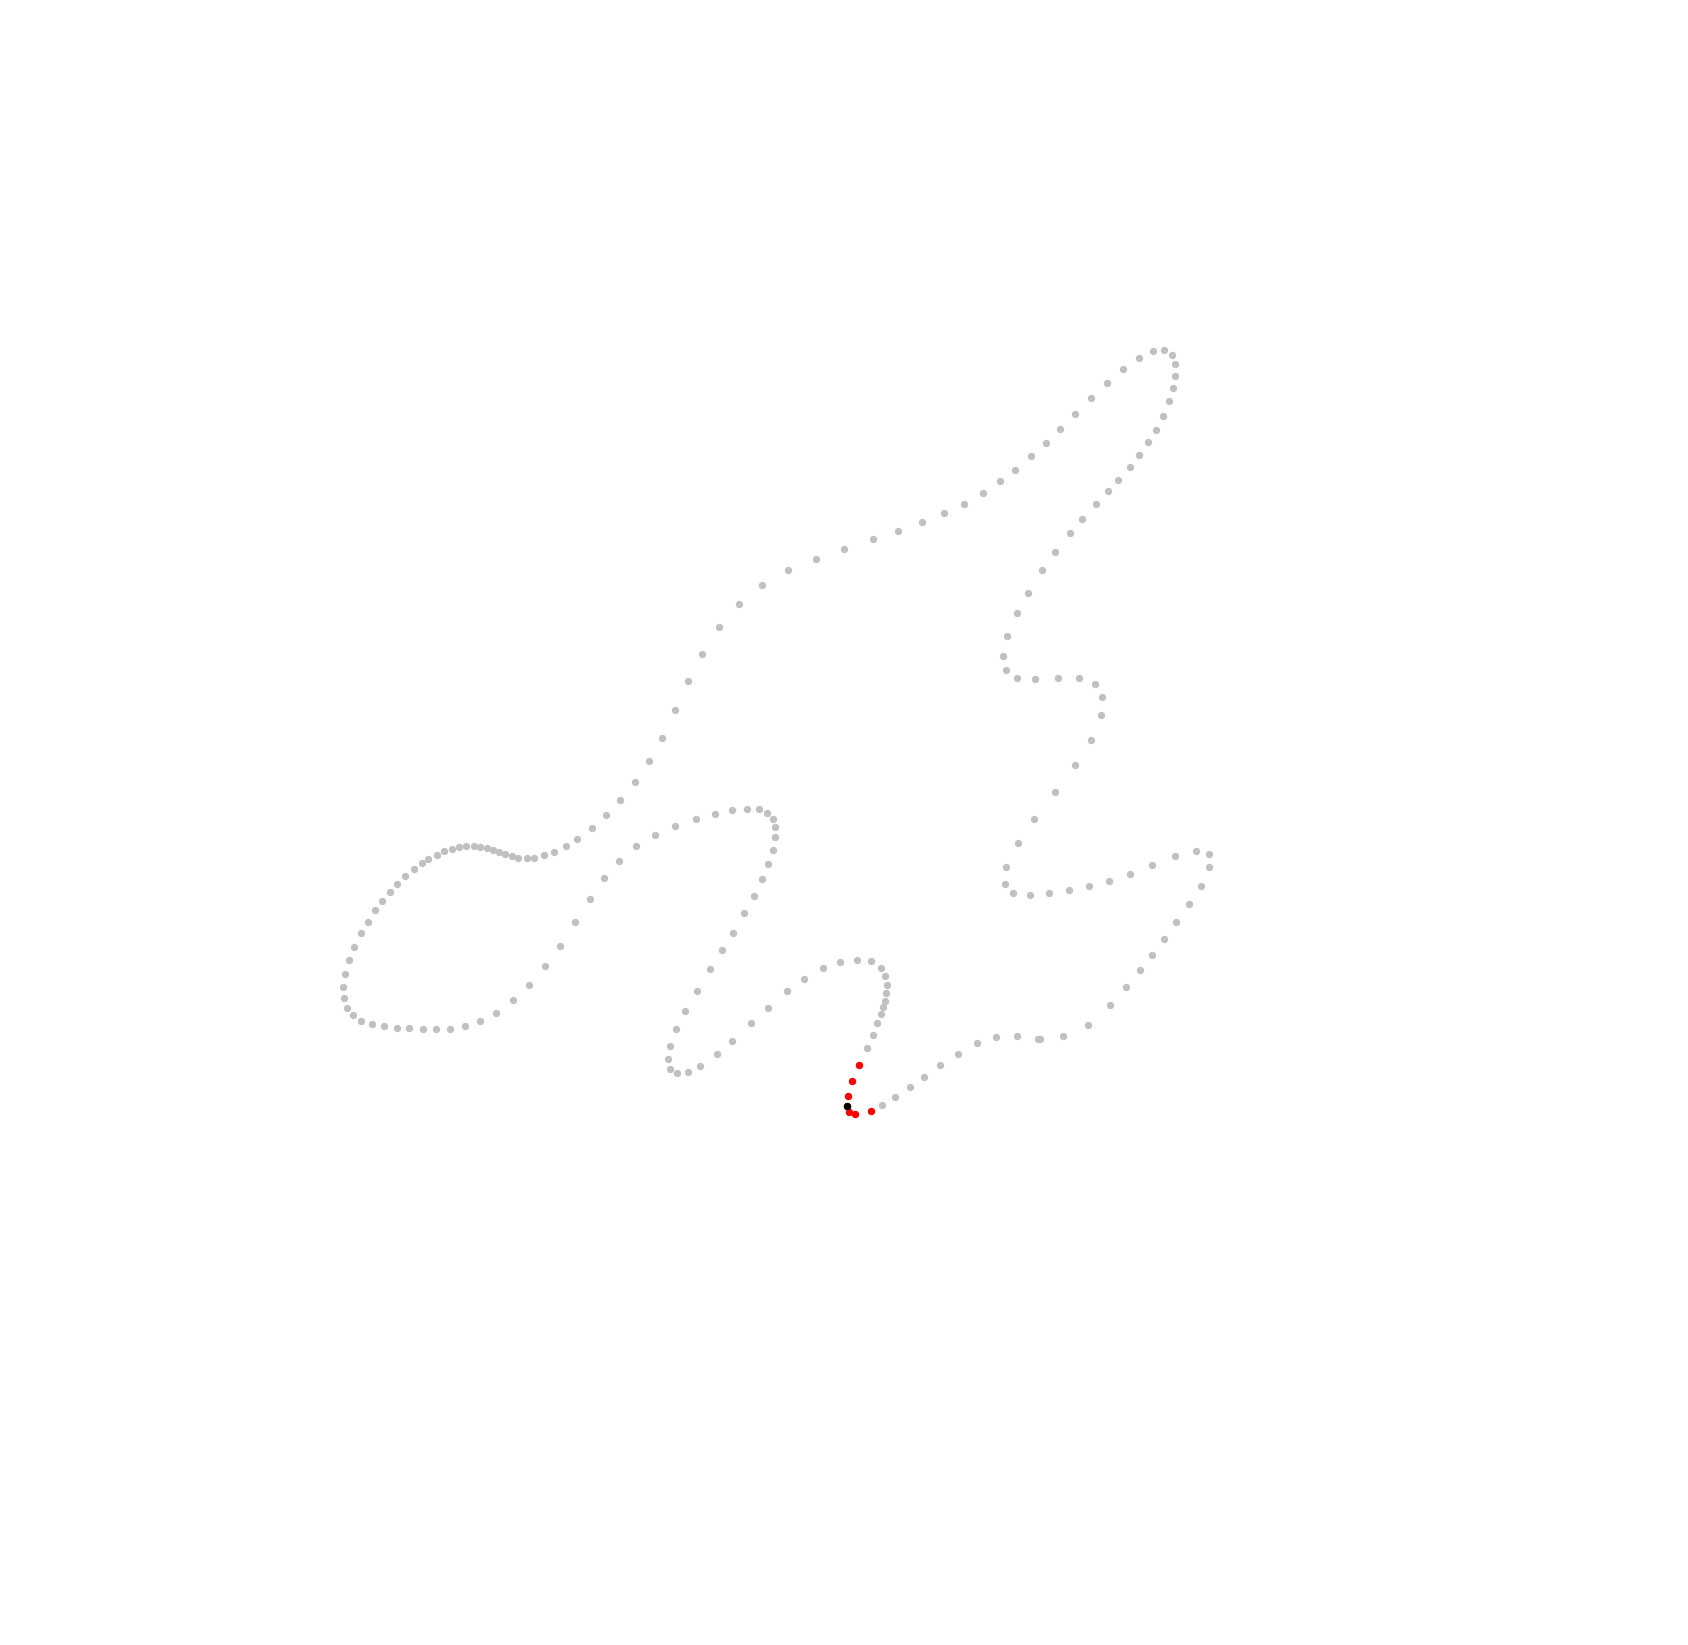

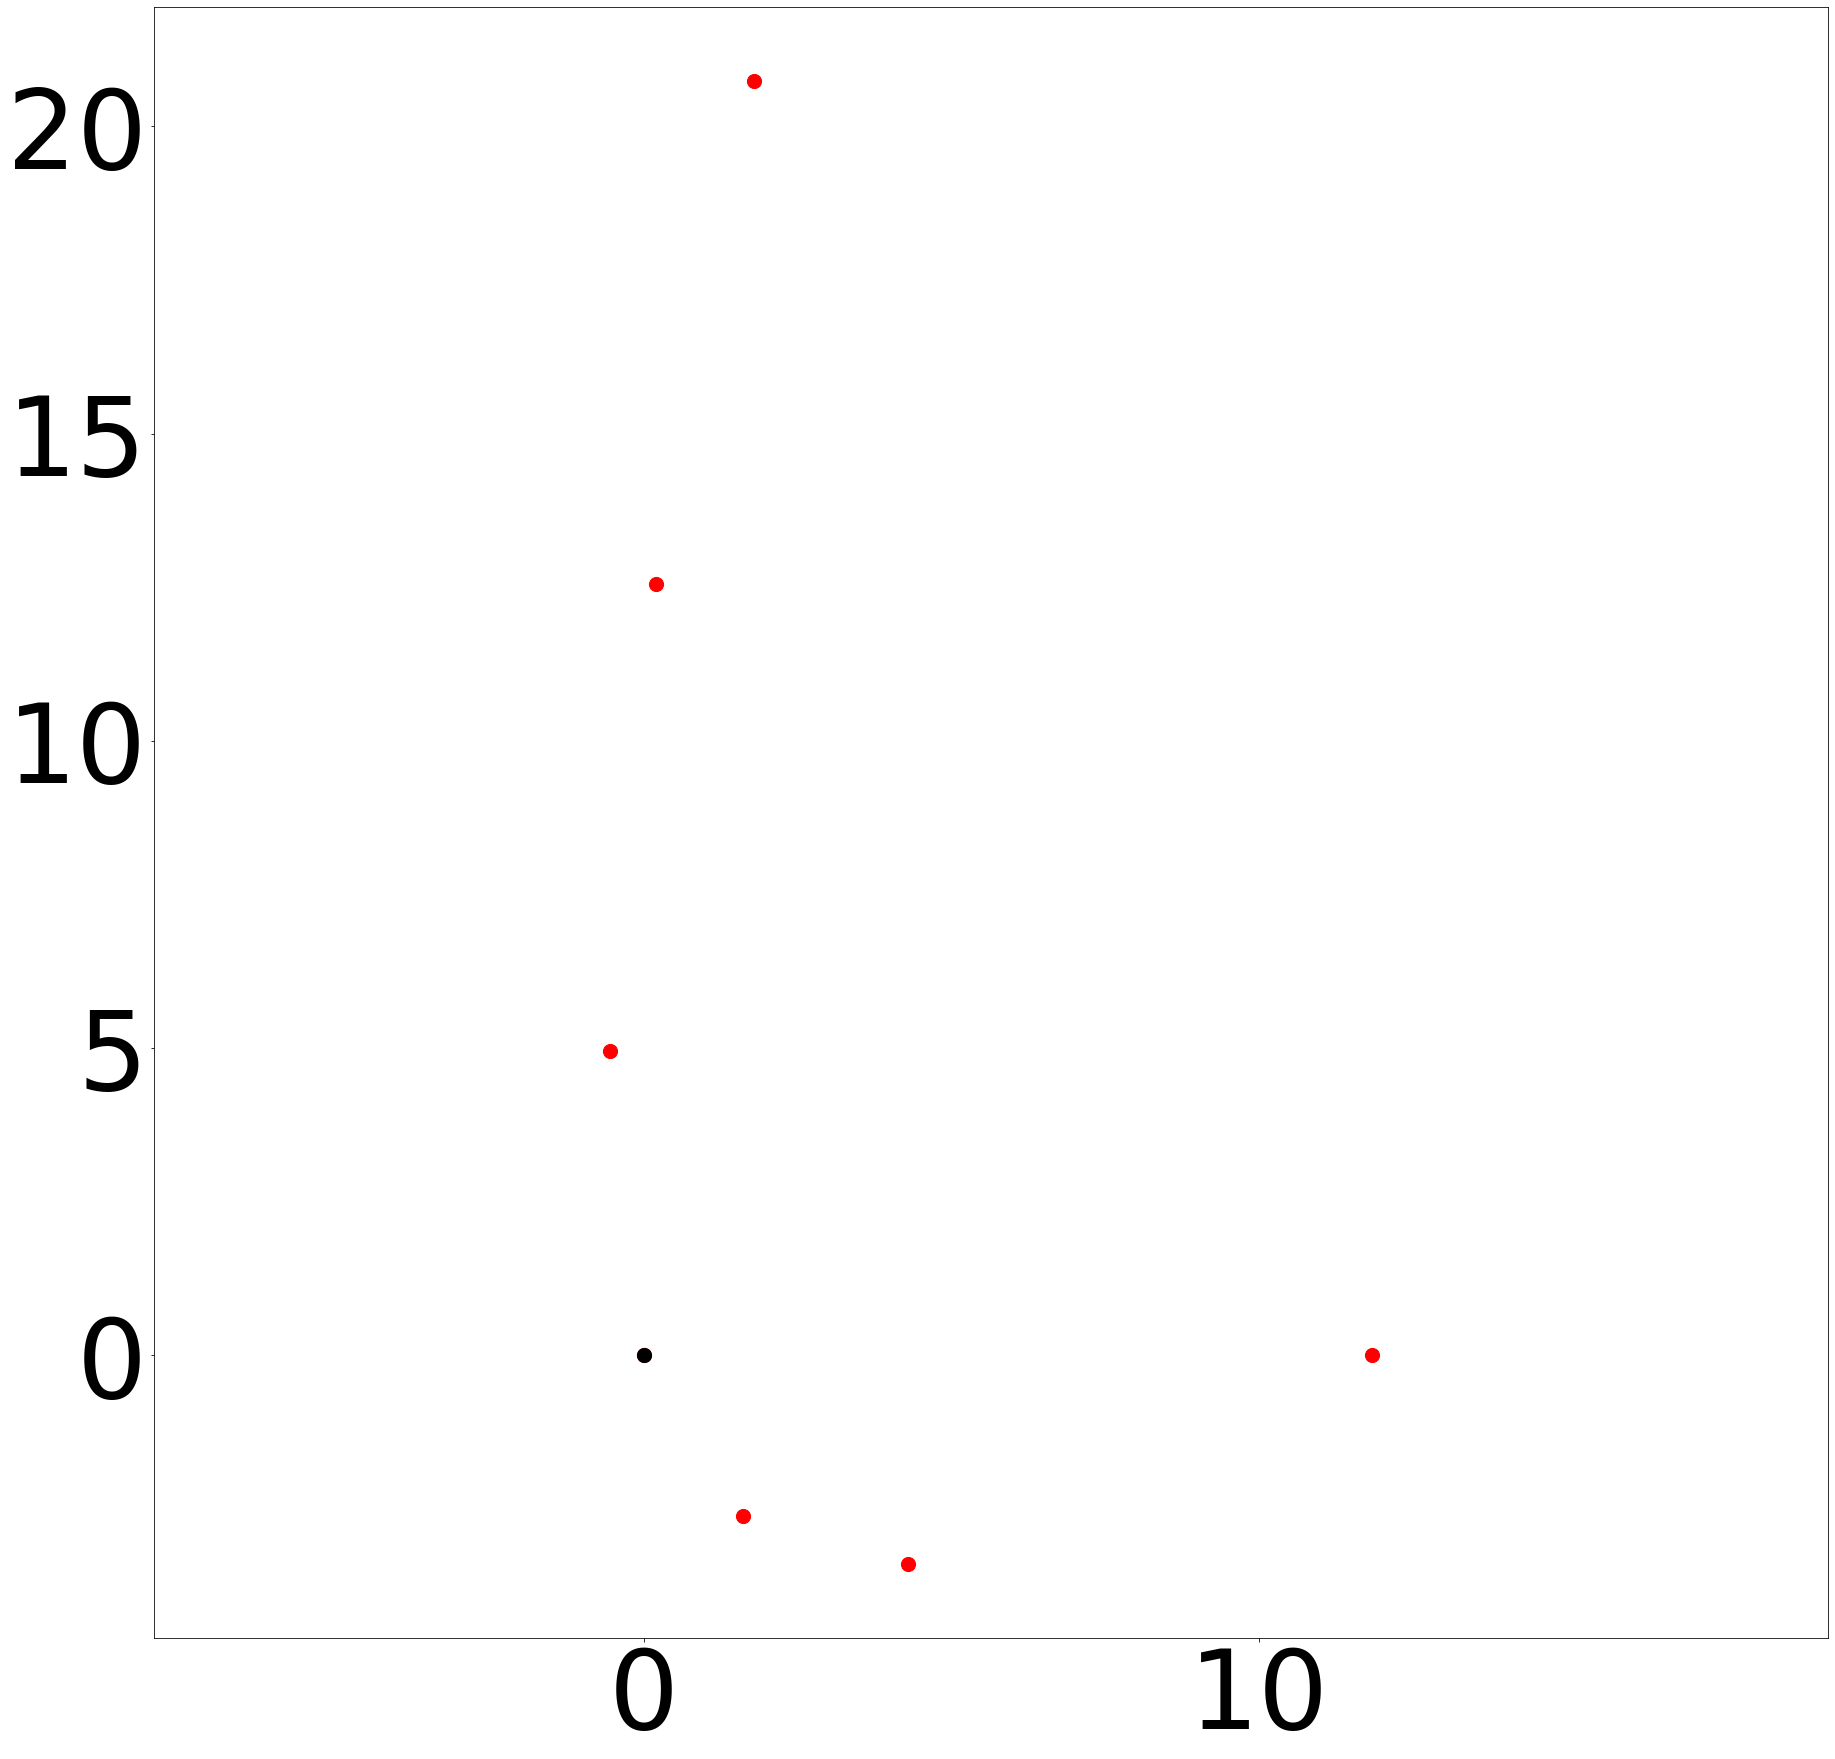

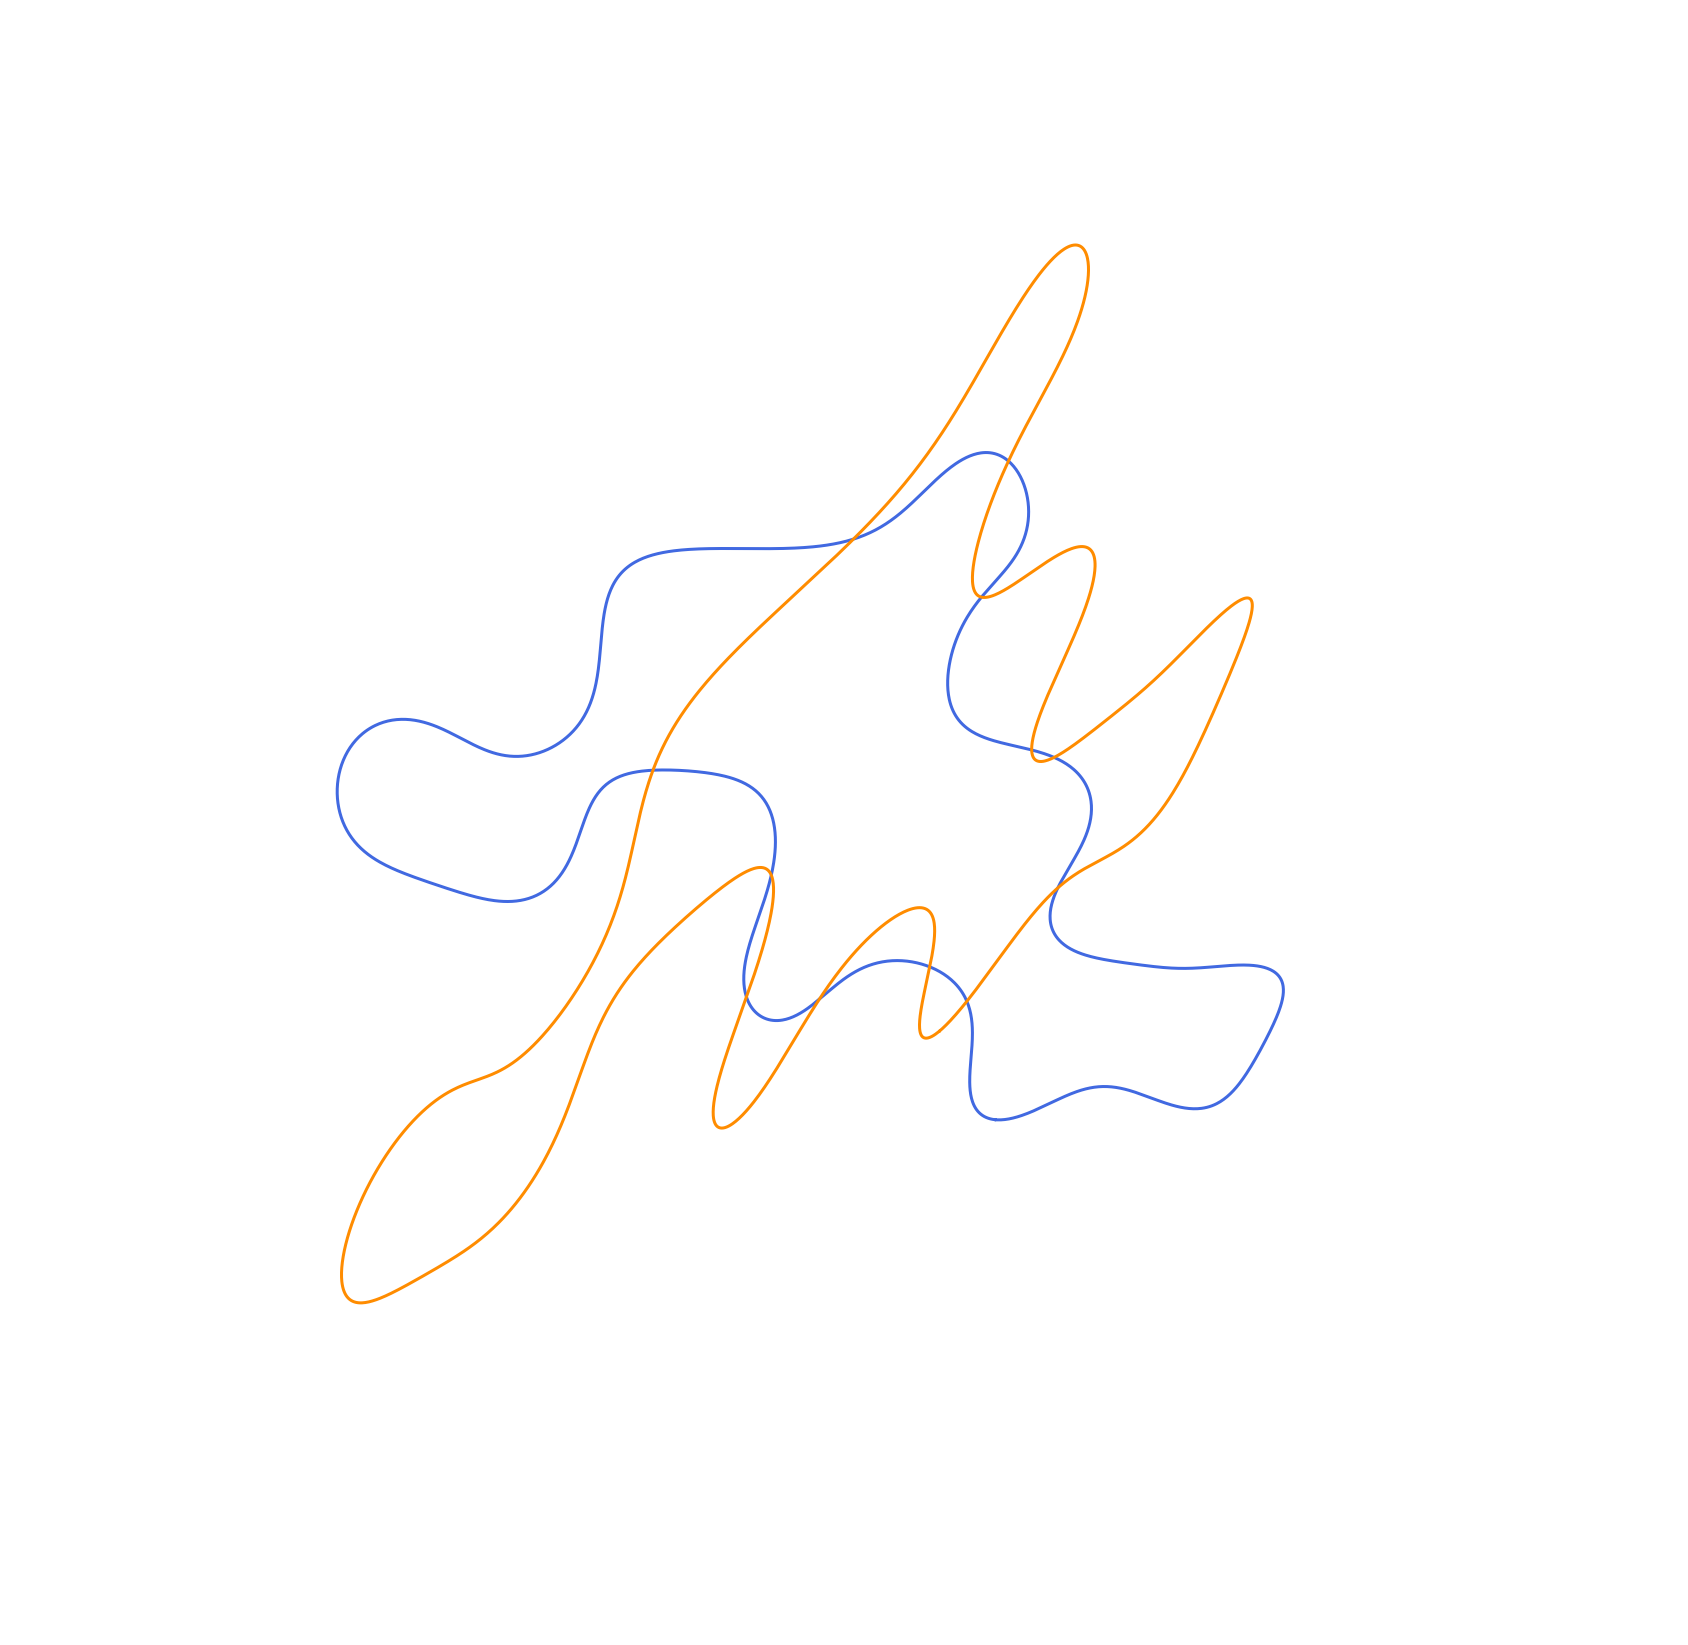

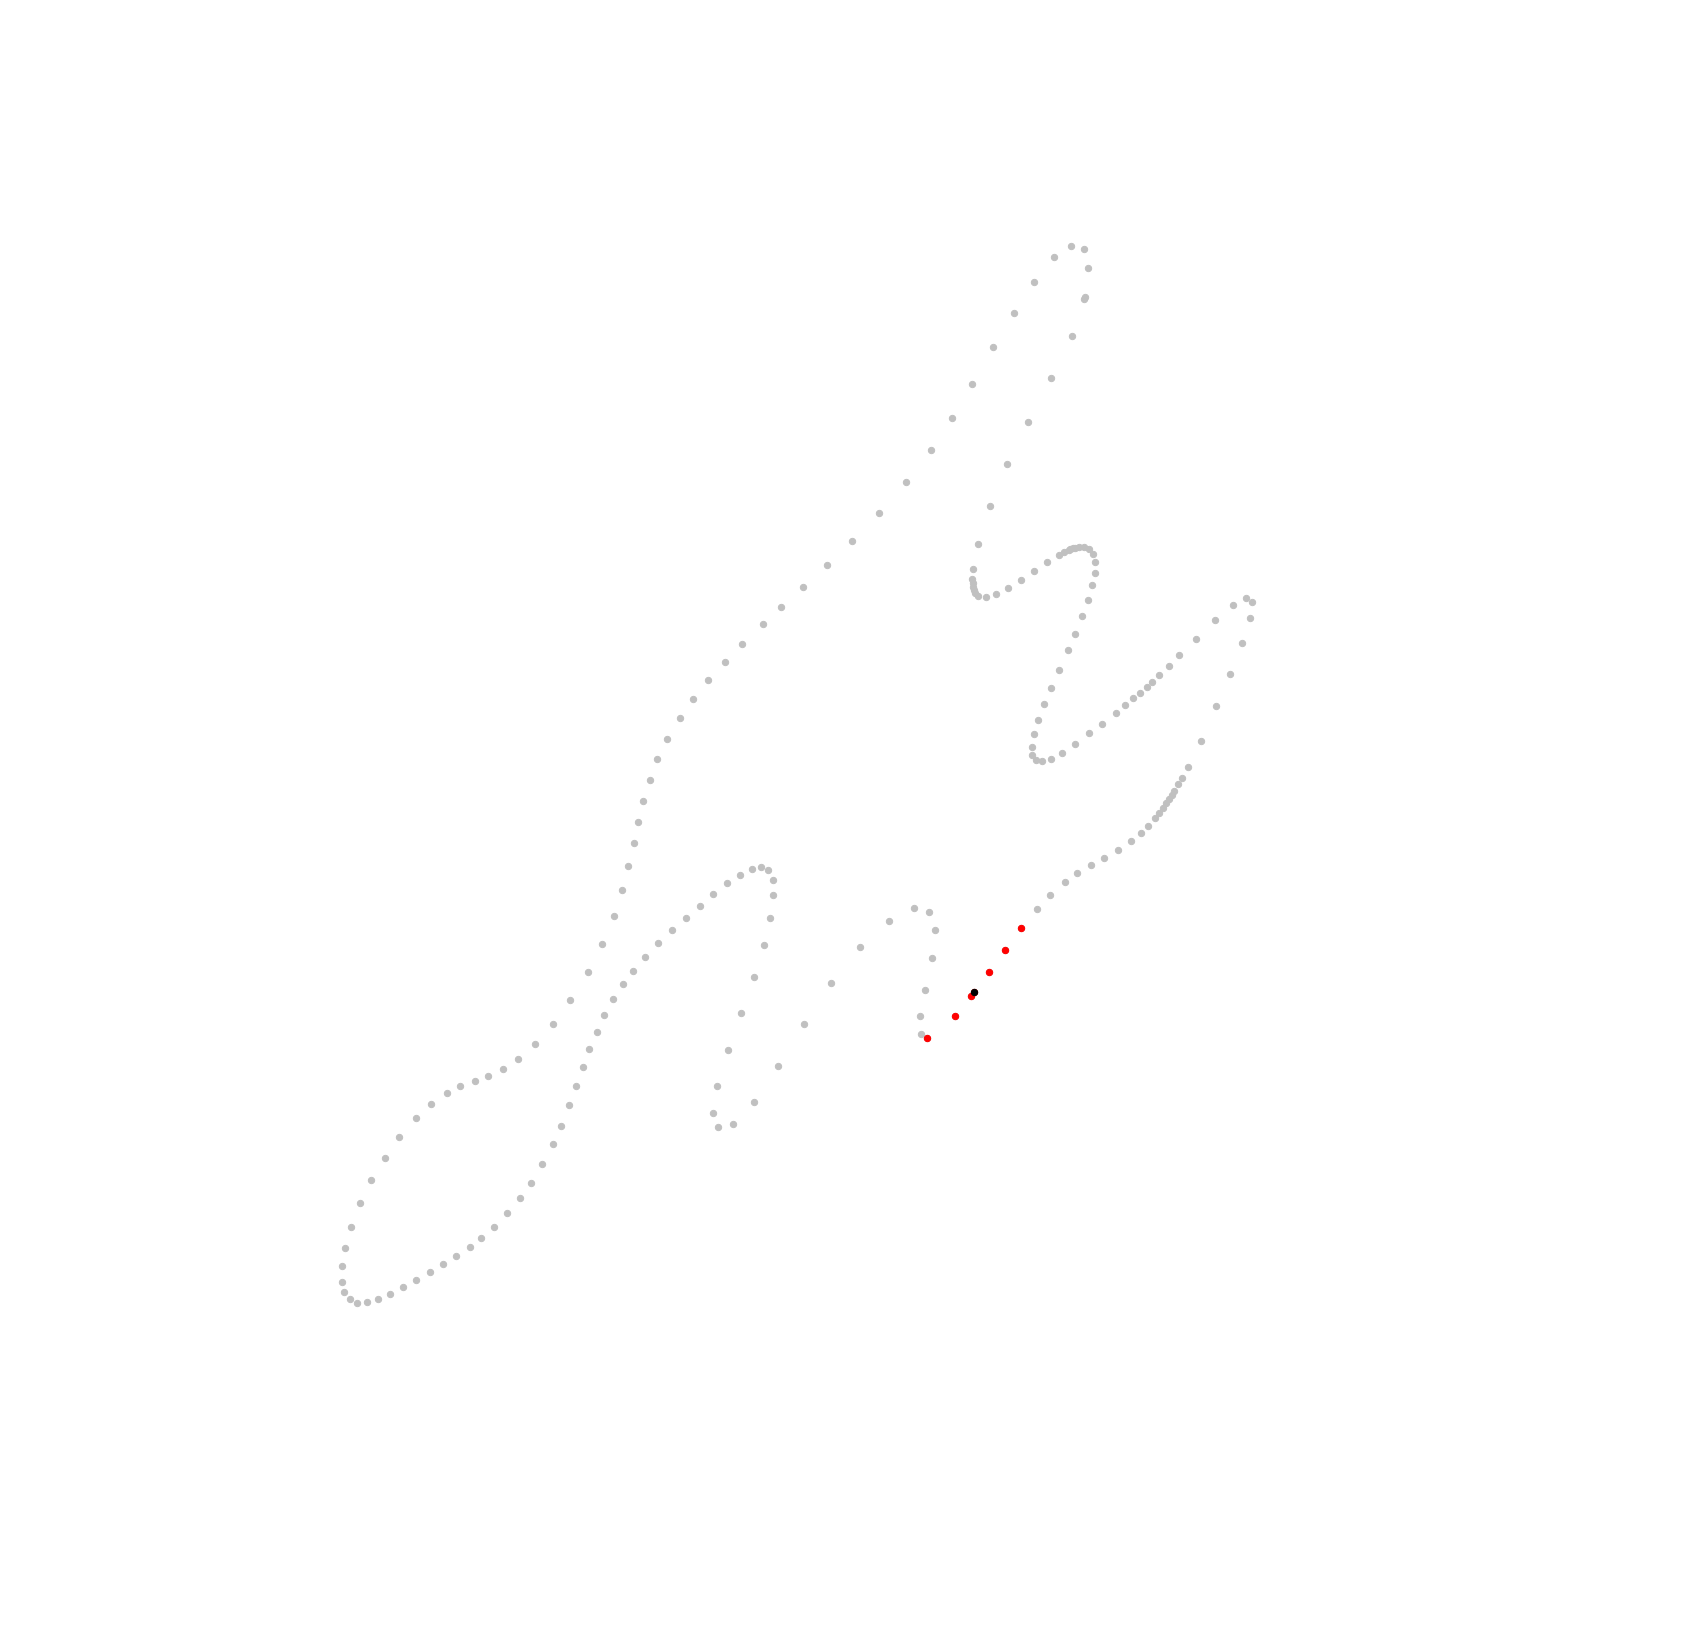

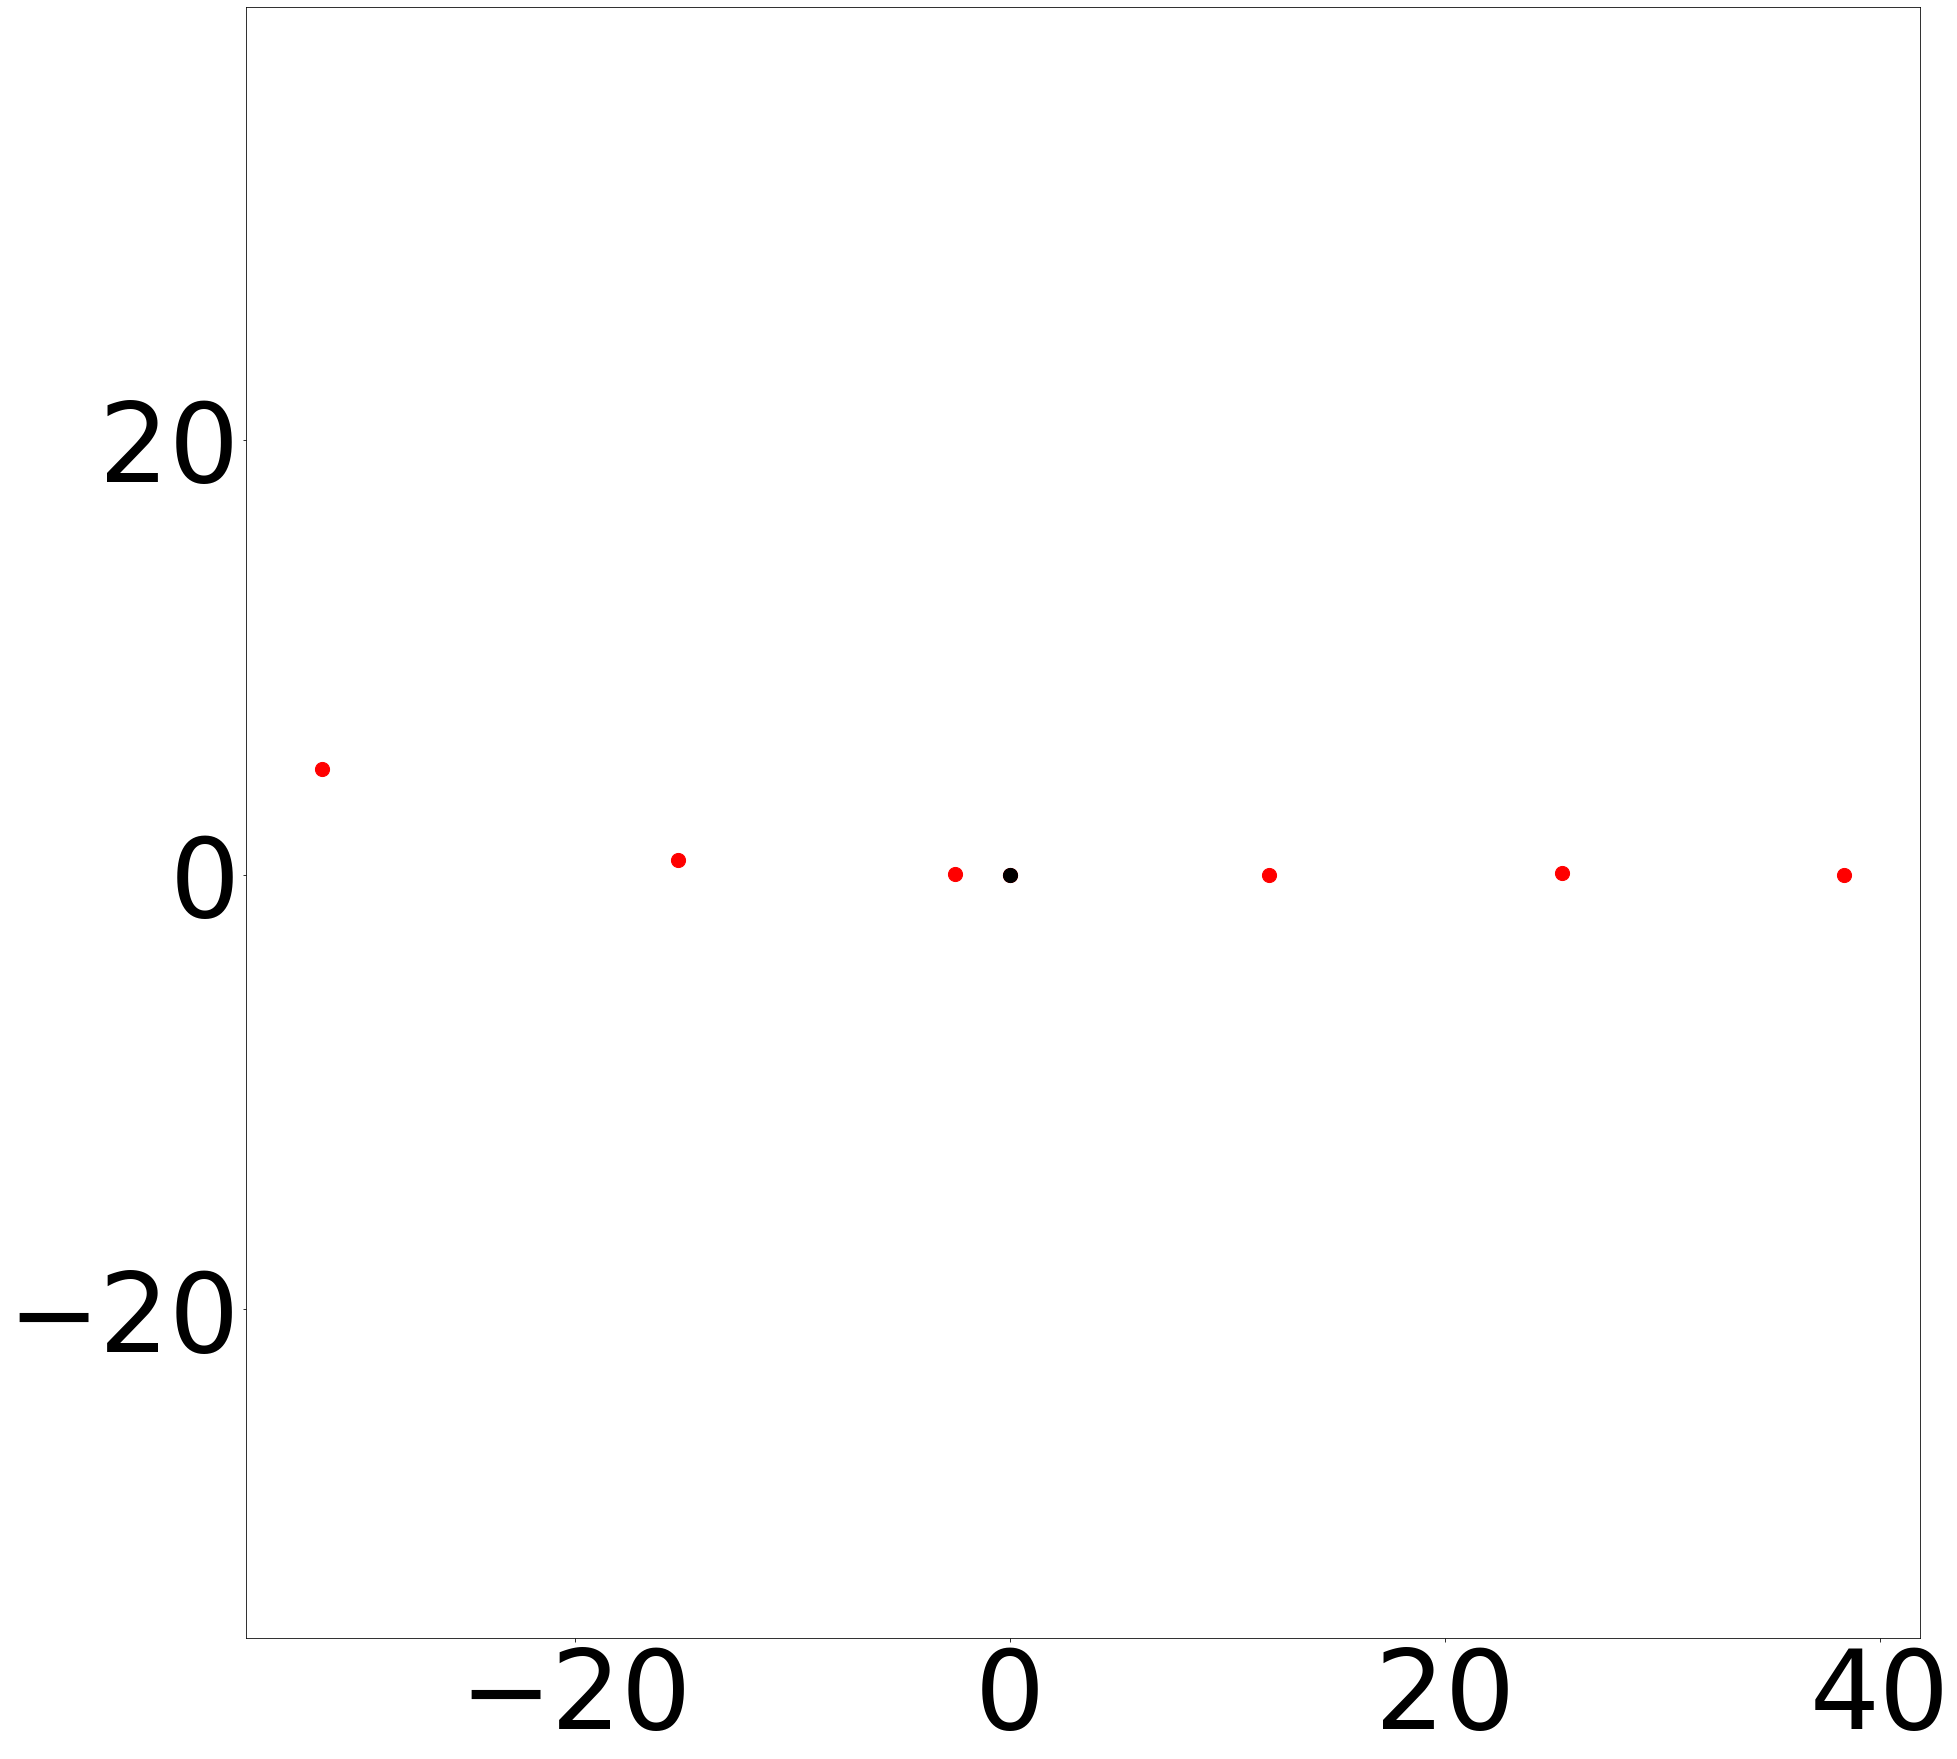

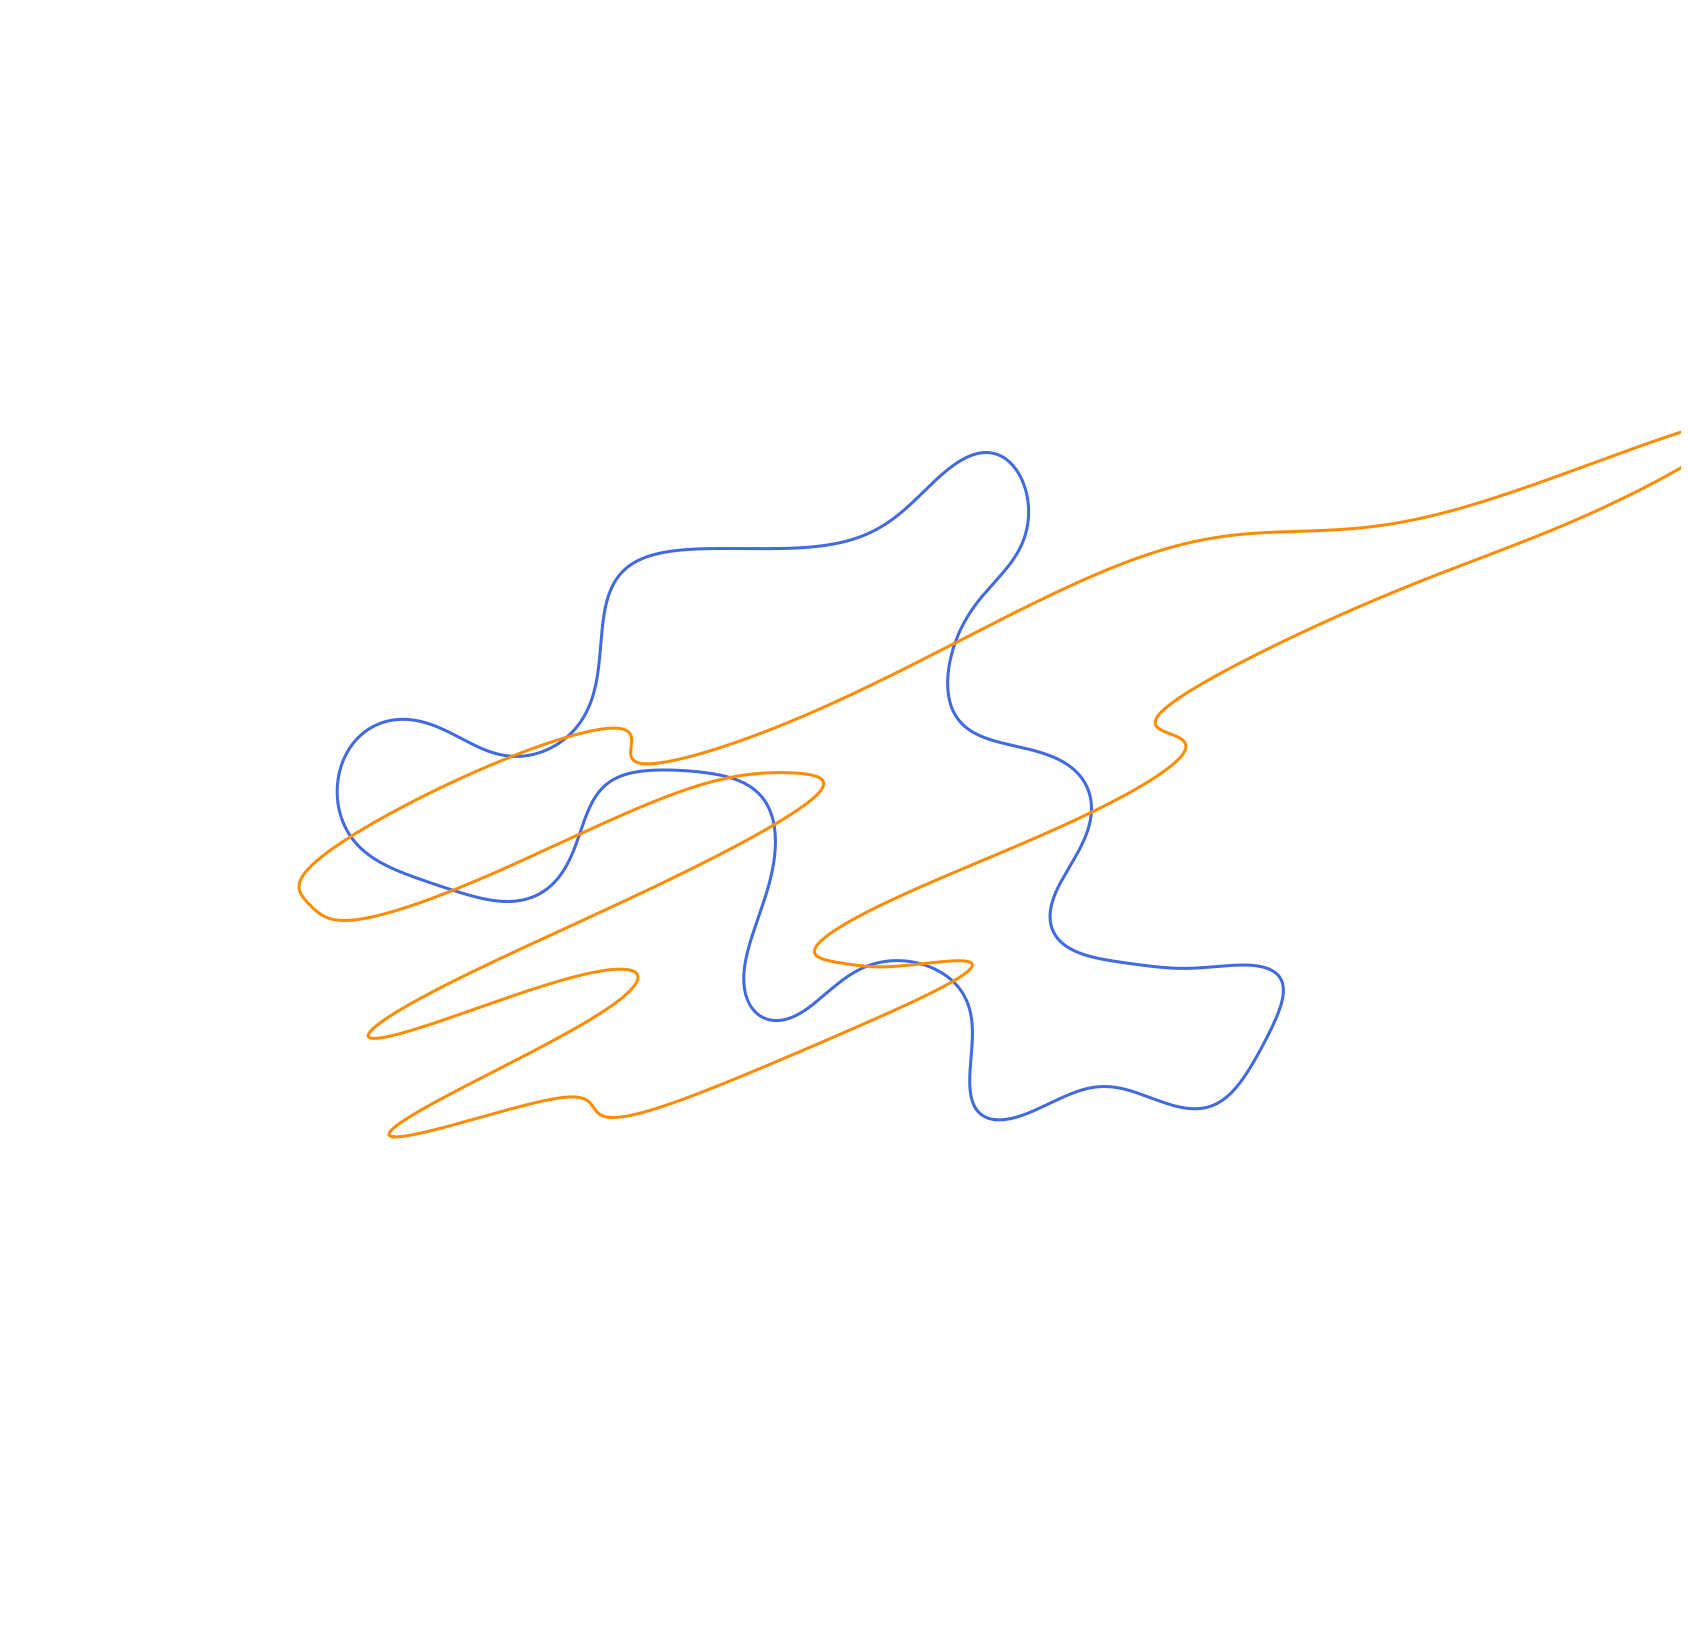

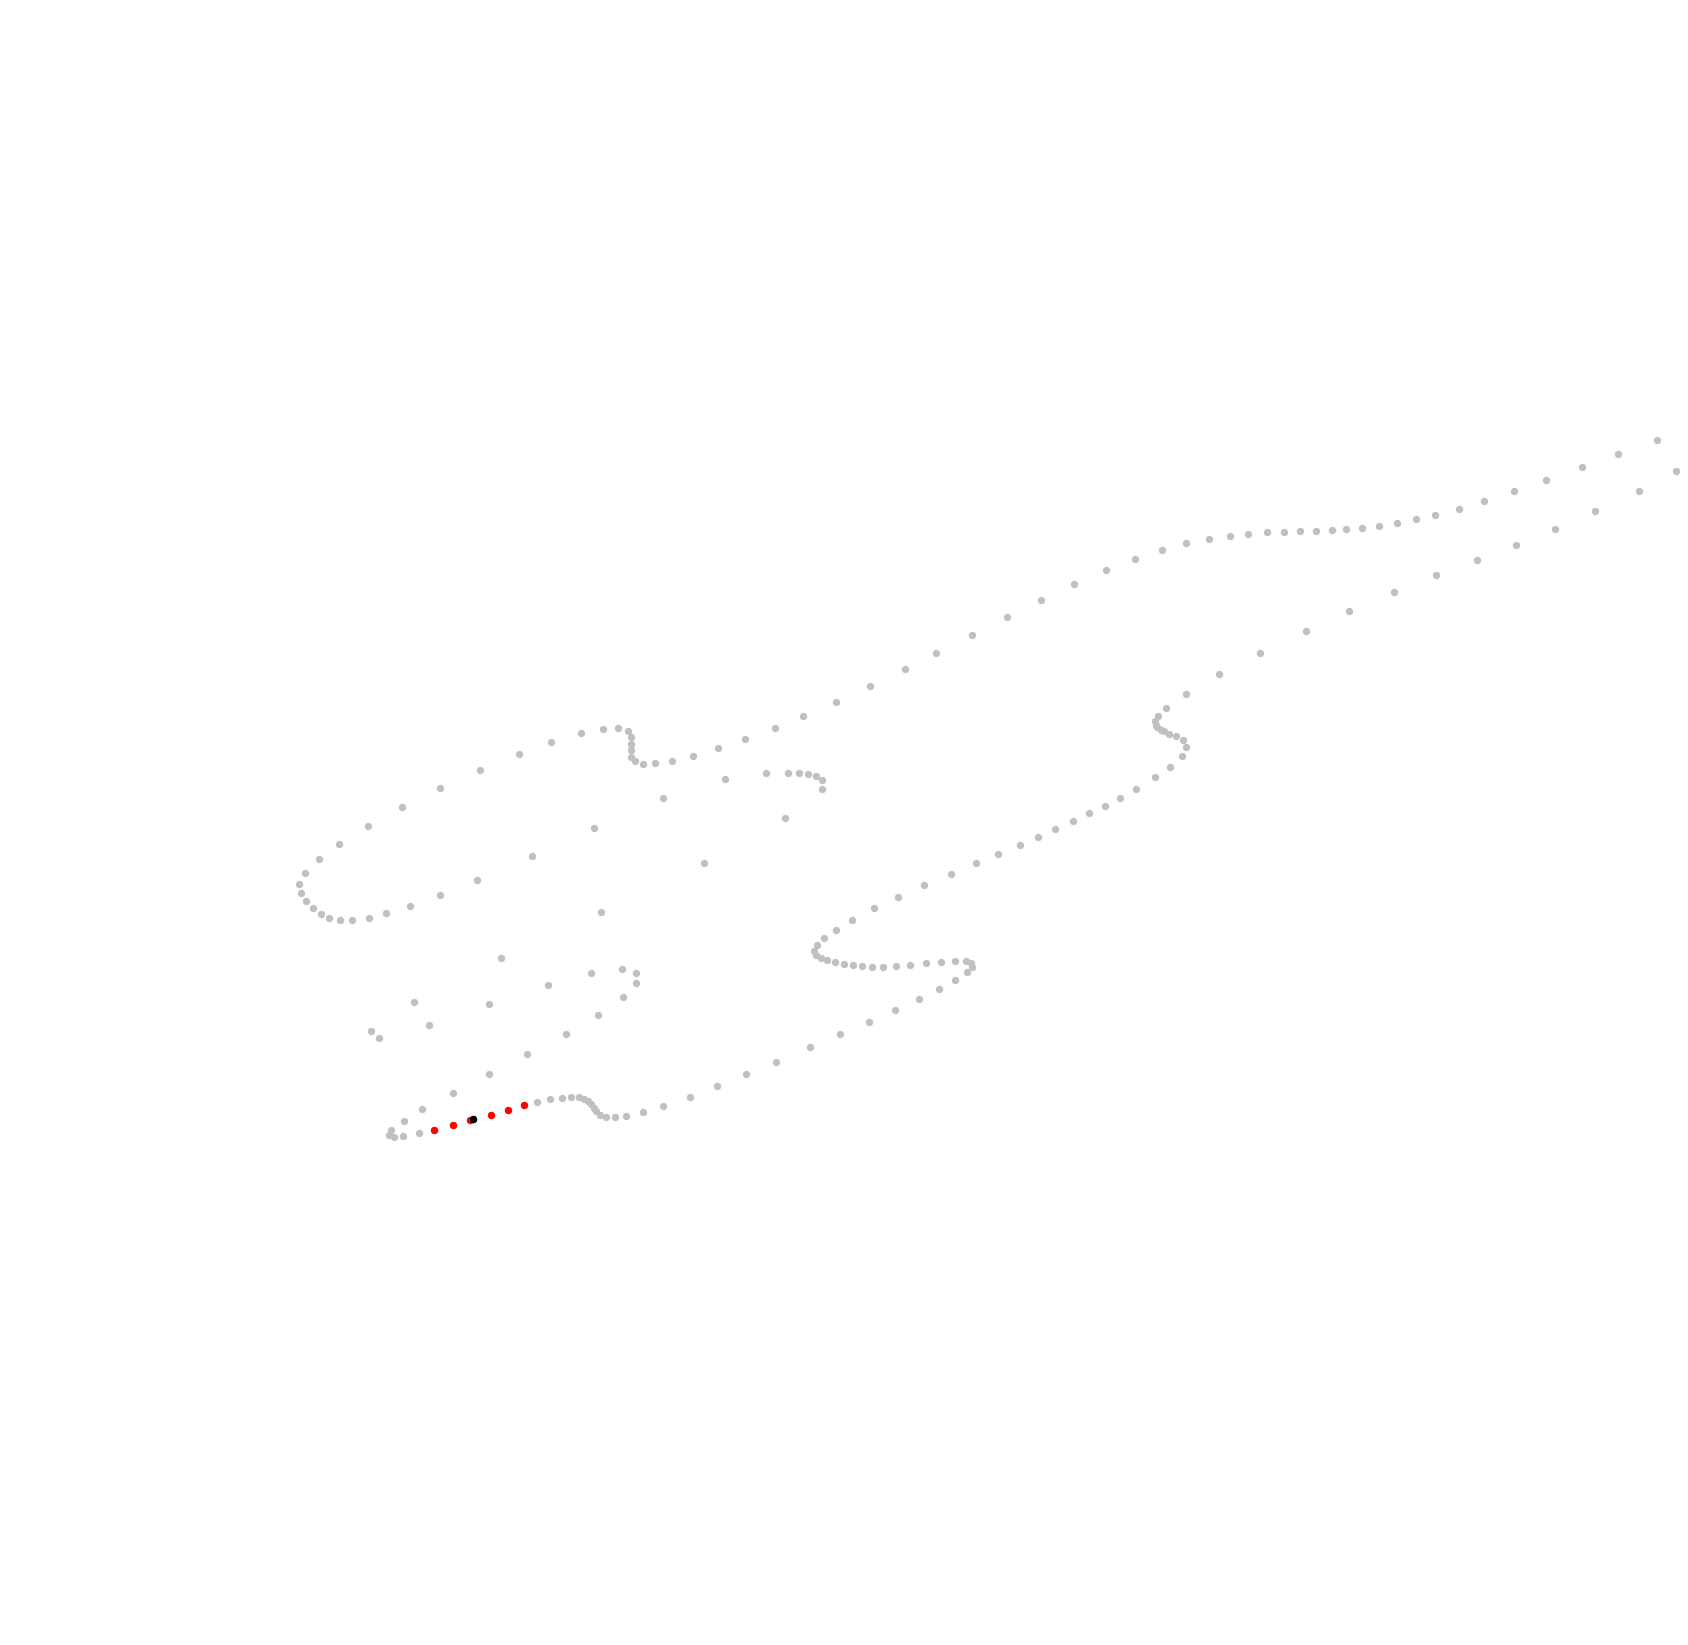

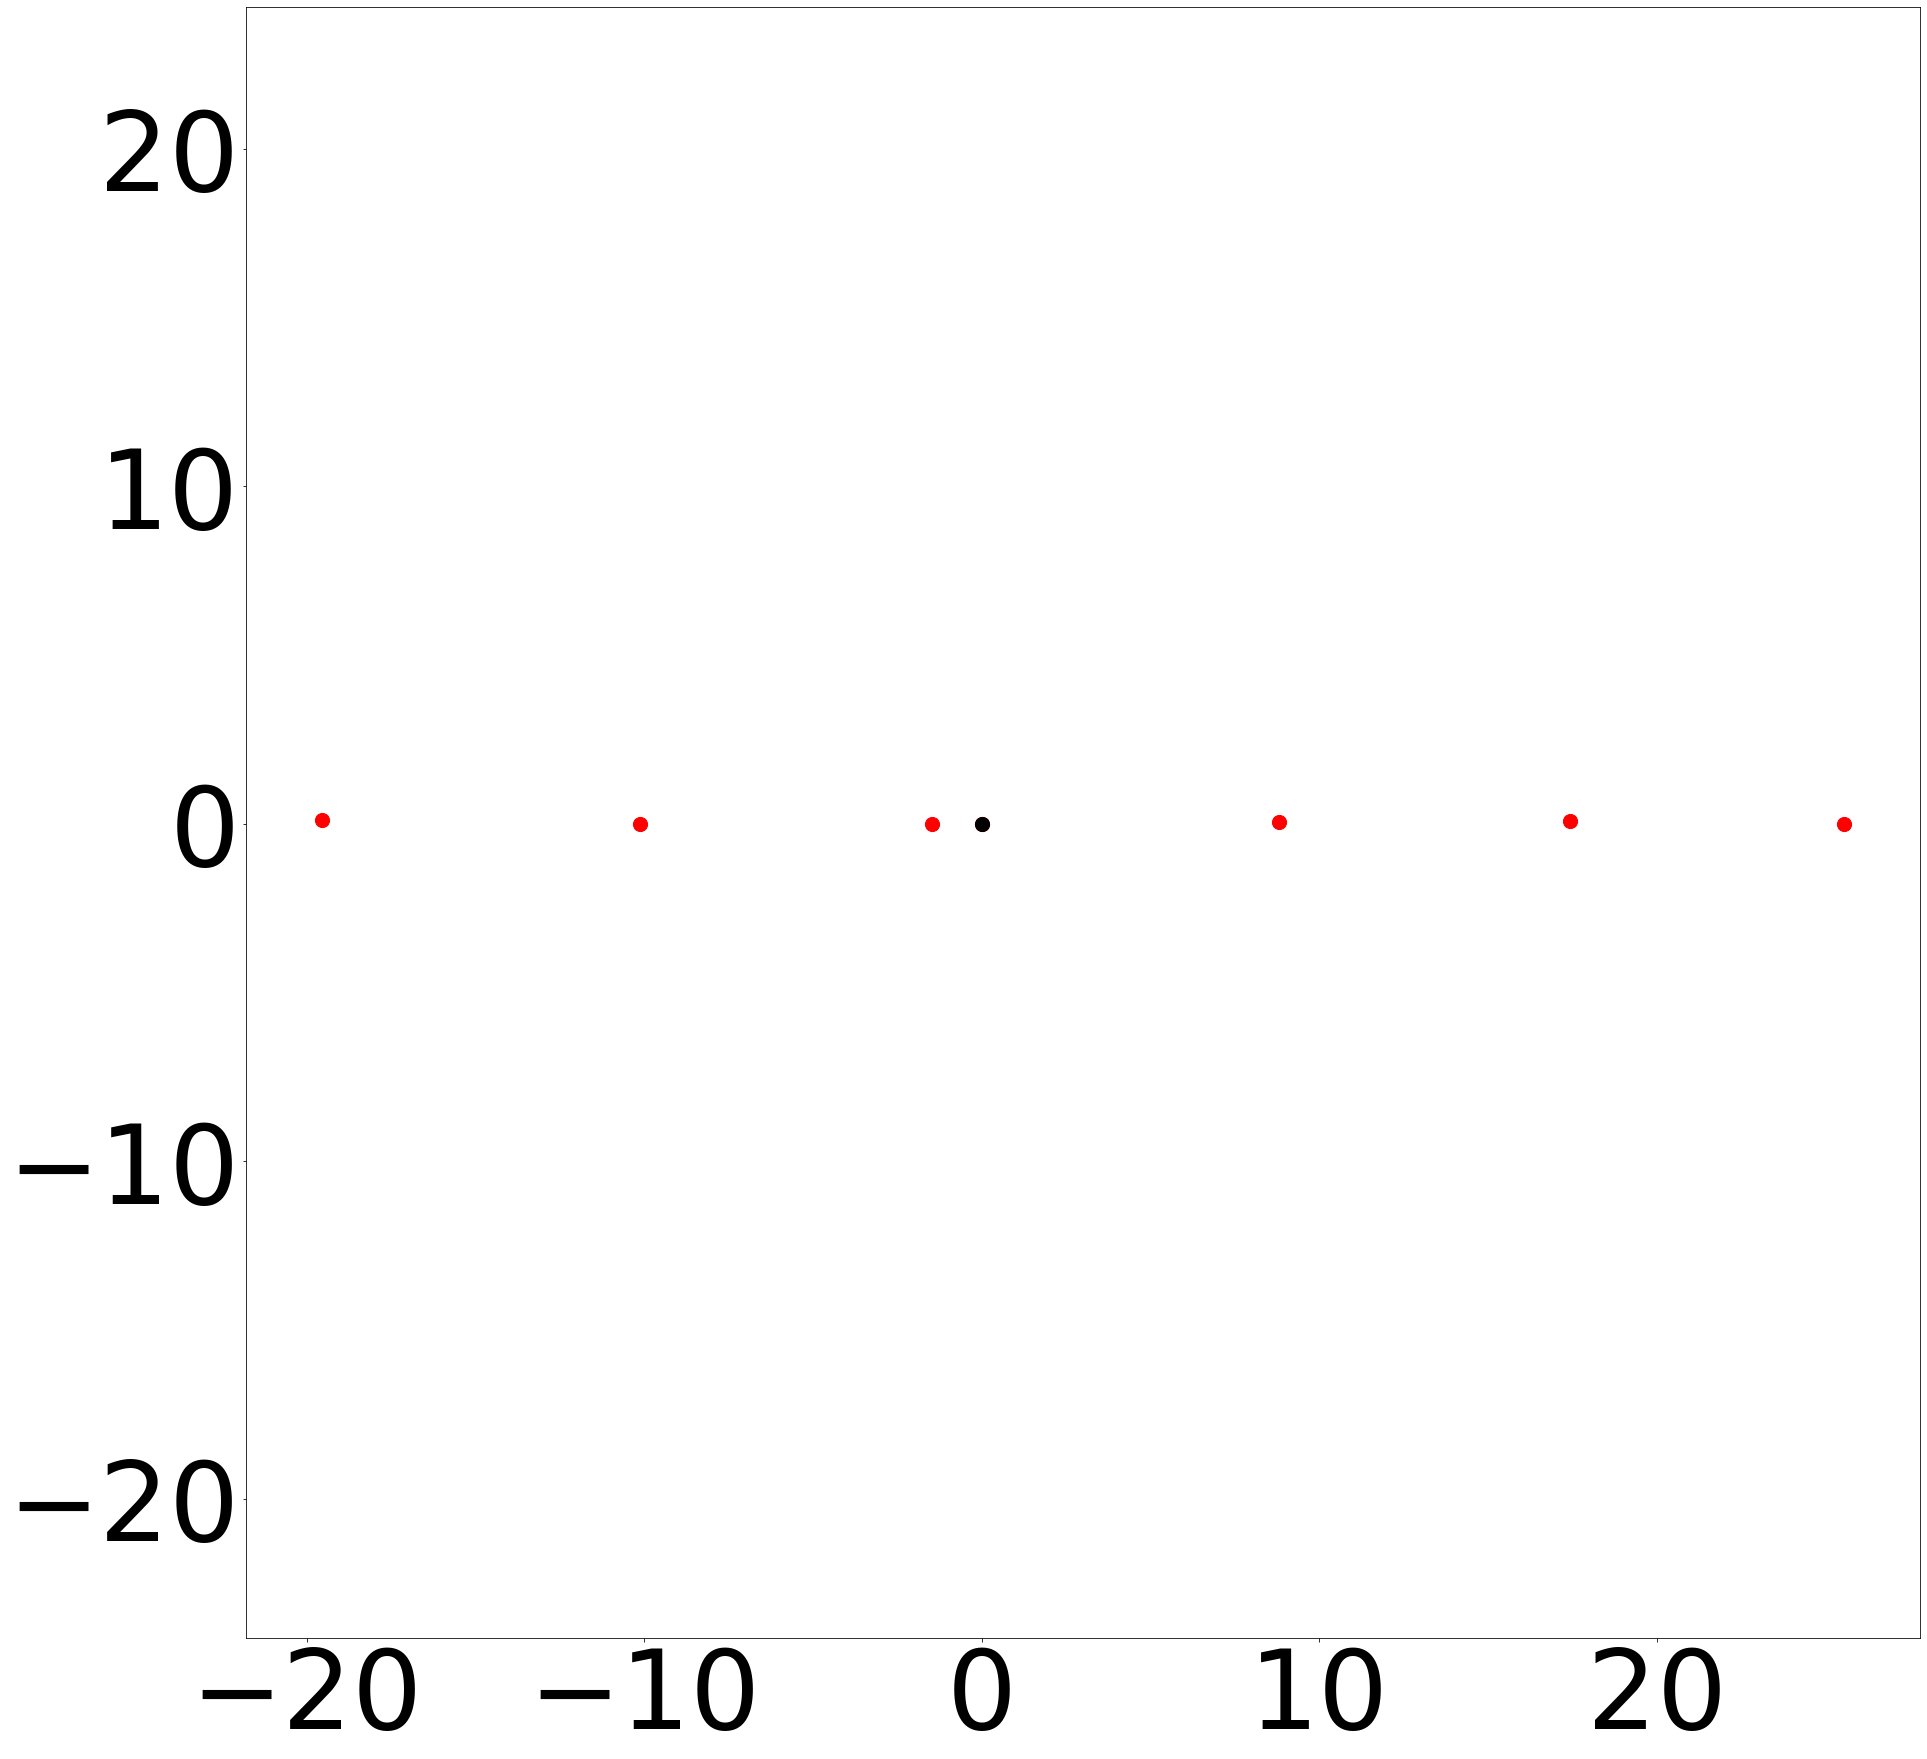

In [9]:
from pathlib import Path
Path("./curvature").mkdir(parents=True, exist_ok=True)

supporting_points_count = 3
sample_points = 2 * supporting_points_count + 1
sampling_ratio = 0.1
multimodality = 50
offset_length = 100
figsize=(30,30)
lim=[-400, 400]
numpy.random.seed(76)

curve_points_count = curve.shape[0]
sampling_points_count = int(sampling_ratio * curve_points_count)
discrete_distribution_pack = discrete_distribution.random_discrete_dist(bins=curve_points_count, multimodality=multimodality, max_density=1, count=2)
center_point_index = int(numpy.random.randint(curve.shape[0], size=1))
transform = affine_transform.generate_random_equiaffine_transform_2d()
transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)

transform2 = affine_transform.generate_random_equiaffine_transform_2d()
transformed_curve2 = curve_processing.transform_curve(curve=curve, transform=transform2)

display(HTML(f'<h1>Positive</h1>'))

indices_pool1 = discrete_distribution.sample_discrete_dist(dist=discrete_distribution_pack[0], sampling_points_count=sampling_points_count)
indices_pool2 = discrete_distribution.sample_discrete_dist(dist=discrete_distribution_pack[1], sampling_points_count=sampling_points_count)
indices_pool3 = indices_pool1
center_point_index = numpy.mod(5, curve.shape[0])

sampled_curve = curve[indices_pool1]
sampled_transformed_curve = transformed_curve[indices_pool2]
sampled_transformed_curve2 = transformed_curve2[indices_pool3]

sample1 = curve_sampling.sample_curve_neighborhood(
    curve=curve,
    center_point_index=center_point_index,
    indices_pool=indices_pool1,
    supporting_points_count=supporting_points_count)
sample1_normalized = curve_processing.normalize_curve(curve=sample1)

sample2 = curve_sampling.sample_curve_neighborhood(
    curve=transformed_curve,
    center_point_index=center_point_index,
    indices_pool=indices_pool2,
    supporting_points_count=supporting_points_count)
sample2_normalized = curve_processing.normalize_curve(curve=sample2)

sample3 = curve_sampling.sample_curve_neighborhood(
    curve=transformed_curve2,
    center_point_index=center_point_index,
    indices_pool=indices_pool3,
    supporting_points_count=supporting_points_count)
sample3_normalized = curve_processing.normalize_curve(curve=sample3)

original_curve_color = 'royalblue'
transformed_curve_color = 'darkorange'
reference_color = 'deepskyblue'
negative_color = 'red'
positive_color = 'lime'
flipped_color = 'magenta'
middle_point_color = 'black'
scatter_color = 'silver'
point_size = 40
point_size_enlarged_samples = 200
labelsize = 110

fig, ax = plt.subplots(figsize=figsize)
ax.plot(curve[:, 0], curve[:, 1], linewidth=3, c=original_curve_color)
ax.plot(transformed_curve[:, 0], transformed_curve[:, 1], linewidth=3, c=transformed_curve_color)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("./curvature/curve.svg")
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(curve[:, 0], curve[:, 1], linewidth=3, c=original_curve_color)
ax.plot(transformed_curve2[:, 0], transformed_curve2[:, 1], linewidth=3, c=transformed_curve_color)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("./curvature/curve2.svg")
plt.show()

# fig, ax = plt.subplots(figsize=figsize)
# ax.plot(transformed_curve[:, 0], transformed_curve[:, 1], linewidth=3, c=transformed_curve_color)
# ax.axis('off')
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# plt.savefig("transformed_curve.svg")
# plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(sampled_curve[:, 0], sampled_curve[:, 1], s=point_size, c=scatter_color)
ax.scatter(sample1[:, 0], sample1[:, 1], s=point_size, c=reference_color)
ax.scatter([sample1[3, 0]], [sample1[3, 1]], s=point_size, c=middle_point_color)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("./curvature/positive_sample1.svg")
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(sampled_transformed_curve[:, 0], sampled_transformed_curve[:, 1], s=point_size, c=scatter_color)
ax.scatter(sample2[:, 0], sample2[:, 1], s=point_size, c=positive_color)
ax.scatter([sample2[3, 0]], [sample2[3, 1]], s=point_size, c=middle_point_color)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("./curvature/positive_sample2.svg")
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(sampled_transformed_curve2[:, 0], sampled_transformed_curve2[:, 1], s=point_size, c=scatter_color)
ax.scatter(sample3[:, 0], sample3[:, 1], s=point_size, c=reference_color)
ax.scatter([sample3[3, 0]], [sample3[3, 1]], s=point_size, c=middle_point_color)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("./curvature/positive_sample3.svg")
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(sample1_normalized[:, 0], sample1_normalized[:, 1], s=point_size_enlarged_samples, c=reference_color)
ax.scatter([sample1_normalized[3, 0]], [sample1_normalized[3, 1]], s=point_size_enlarged_samples, c=middle_point_color)
ax.axis('equal')
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
plt.savefig("./curvature/positive_sample1_enlarged.svg")
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(sample2_normalized[:, 0], sample2_normalized[:, 1], s=point_size_enlarged_samples, c=positive_color)
ax.scatter([sample2_normalized[3, 0]], [sample2_normalized[3, 1]], s=point_size_enlarged_samples, c=middle_point_color)
ax.axis('equal')
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
plt.savefig("./curvature/positive_sample2_enlarged.svg")
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(sample3_normalized[:, 0], sample3_normalized[:, 1], s=point_size_enlarged_samples, c=reference_color)
ax.scatter([sample3_normalized[3, 0]], [sample3_normalized[3, 1]], s=point_size_enlarged_samples, c=middle_point_color)
ax.axis('equal')
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
plt.savefig("./curvature/positive_sample3_enlarged.svg")
plt.show()

flipped_sample = numpy.flip(m=sample1, axis=0).copy()
flipped_sample_normalized = curve_processing.normalize_curve(curve=flipped_sample)
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(flipped_sample_normalized[:, 0], flipped_sample_normalized[:, 1], s=point_size_enlarged_samples, c=flipped_color)
ax.scatter([flipped_sample_normalized[3, 0]], [flipped_sample_normalized[3, 1]], s=point_size_enlarged_samples, c=middle_point_color)
ax.axis('equal')
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
plt.savefig("./curvature/flipped_sample_enlarged.svg")
plt.show()

num_dist = 10
discrete_distribution_pack = discrete_distribution.random_discrete_dist(bins=curve_points_count, multimodality=multimodality, max_density=1, count=num_dist)
for i in range(num_dist):

    display(HTML(f'<h1>Negative {i+1}</h1>'))

    while True:
        center_point_index_offset = int(numpy.random.randint(offset_length, size=1)) - int(offset_length/2)
        if numpy.abs(center_point_index_offset) > 10:
            break

    
    transform = affine_transform.generate_random_equiaffine_transform_2d()
    transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)

    indices_pool = discrete_distribution.sample_discrete_dist(dist=discrete_distribution_pack[i], sampling_points_count=sampling_points_count)

    sampled_transformed_curve = transformed_curve[indices_pool]

    negative_sample = curve_sampling.sample_curve_neighborhood(
        curve=transformed_curve,
        center_point_index=numpy.mod(center_point_index + center_point_index_offset, transformed_curve.shape[0]),
        indices_pool=indices_pool,
        supporting_points_count=supporting_points_count)

    negative_sample_normalized = curve_processing.normalize_curve(curve=negative_sample)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(curve[:, 0], curve[:, 1], linewidth=3, c=original_curve_color)
    ax.plot(transformed_curve[:, 0], transformed_curve[:, 1], linewidth=3, c=transformed_curve_color)
    ax.axis('off')
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    # ax.axis('equal')
    plt.savefig(f"./curvature/transformed_curve_negative_{i+1}.svg")
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(sampled_transformed_curve[:, 0], sampled_transformed_curve[:, 1], s=point_size, c=scatter_color)
    ax.scatter(negative_sample[:, 0], negative_sample[:, 1], s=point_size, c=negative_color)
    ax.scatter([negative_sample[3, 0]], [negative_sample[3, 1]], s=point_size, c=middle_point_color)
    ax.axis('off')
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    plt.savefig(f"./curvature/negative_sample{i+1}.svg")
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(negative_sample_normalized[:, 0], negative_sample_normalized[:, 1], s=point_size_enlarged_samples, c=negative_color)
    # ax.scatter(negative_sample_normalized[:, 0], negative_sample_normalized[:, 1], s=point_size, c=negative_color)
    ax.scatter([negative_sample_normalized[3, 0]], [negative_sample_normalized[3, 1]], s=point_size_enlarged_samples, c=middle_point_color)
    # ax.axis('off')
    ax.axis('equal')
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.savefig(f"./curvature/negative_sample{i+1}_enlarged.svg")
    plt.show()

# PLOT ARC-LENGTH SAMPLES

In [ ]:
def _sample_curve_section(curve, supporting_points_count, start_point_index, end_point_index):
    sample = curve_sampling.sample_curve_section_old(
        curve=curve,
        supporting_points_count=supporting_points_count,
        start_point_index=start_point_index,
        end_point_index=end_point_index)

    return sample

sampling_ratio = 0.3
multimodality = 50
offset_length = 50
num_workers = 1
section_points_count = 10
supporting_points_count = 20
min_offset = supporting_points_count
max_offset = 6*supporting_points_count
figsize=(30,30)
lim=[-400, 400]
numpy.random.seed(50)

curve_points_count = curve.shape[0]
sampling_points_count = int(sampling_ratio * curve_points_count)
discrete_distribution_pack = discrete_distribution.random_discrete_dist(bins=curve_points_count, multimodality=multimodality, max_density=1, count=2)
center_point_index = int(numpy.random.randint(curve.shape[0], size=1))
transform = affine_transform.generate_random_equiaffine_transform_2d()
transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)

indices_pool1 = discrete_distribution.sample_discrete_dist(dist=discrete_distribution_pack[0], sampling_points_count=sampling_points_count)
indices_pool2 = discrete_distribution.sample_discrete_dist(dist=discrete_distribution_pack[1], sampling_points_count=sampling_points_count)
center_point_index = numpy.mod(5, curve.shape[0])

sampled_curve = curve[indices_pool1]
sampled_transformed_curve = transformed_curve[indices_pool2]


original_curve_color = 'royalblue'
transformed_curve_color = 'darkorange'
reference_color = 'deepskyblue'
negative_color = 'red'
positive_color = 'lime'
flipped_color = 'magenta'
middle_point_color = 'black'
scatter_color = 'silver'
point_size = 40
point_size_enlarged_samples = 200
labelsize = 110

raw_offset = numpy.random.randint(max_offset, size=4)
offset = numpy.maximum(raw_offset, [min_offset] * 4)
index1 = center_point_index
index2 = int(numpy.mod(index1 + offset[0], curve.shape[0]))
index3 = int(numpy.mod(index2 + offset[1], curve.shape[0]))
index4 = int(numpy.mod(index3 + offset[2], curve.shape[0]))
index5 = int(numpy.mod(index4 + offset[3], curve.shape[0]))

transform = transform = affine_transform.generate_random_equiaffine_transform_2d()
transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)

org_curve_sample1 = _sample_curve_section(
    curve=curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index1,
    end_point_index=index3)

org_curve_sample2 = _sample_curve_section(
    curve=curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index2,
    end_point_index=index4)

org_curve_sample3 = _sample_curve_section(
    curve=curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index3,
    end_point_index=index5)

org_curve_sample4 = _sample_curve_section(
    curve=curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index1,
    end_point_index=index4)

org_curve_sample5 = _sample_curve_section(
    curve=curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index2,
    end_point_index=index5)

org_curve_sample6 = _sample_curve_section(
    curve=curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index1,
    end_point_index=index5)

trans_curve_sample1 = _sample_curve_section(
    curve=transformed_curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index1,
    end_point_index=index2)

trans_curve_sample2 = _sample_curve_section(
    curve=transformed_curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index2,
    end_point_index=index3)

trans_curve_sample3 = _sample_curve_section(
    curve=transformed_curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index3,
    end_point_index=index4)

trans_curve_sample4 = _sample_curve_section(
    curve=transformed_curve,
    supporting_points_count=supporting_points_count,
    start_point_index=index4,
    end_point_index=index5)


fig, ax = plt.subplots(figsize=figsize)
ax.plot(curve[:, 0], curve[:, 1], linewidth=3, c=original_curve_color)
ax.plot(transformed_curve[:, 0], transformed_curve[:, 1], linewidth=3, c=transformed_curve_color)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("curve.svg")
plt.show()

def _plot_curve_section_sample(curve, curve_sample, start_index, end_index, sample_color, prefix):
    fig, ax = plt.subplots(figsize=figsize)
    curve_sample_comp1 = curve[list(range(0, start_index))]
    curve_sample_comp2 = curve[list(range(end_index, curve.shape[0]))]
    ax.plot(curve_sample_comp1[:, 0], curve_sample_comp1[:, 1], linewidth=3, c=scatter_color)
    ax.plot(curve_sample_comp2[:, 0], curve_sample_comp2[:, 1], linewidth=3, c=scatter_color)
    ax.scatter(curve_sample[:, 0], curve_sample[:, 1], s=point_size, c=sample_color, zorder=100)

    if index1 <= start_index or index1 >= end_index:
        ax.scatter([curve[index1, 0]], [curve[index1, 1]], s=point_size, c=middle_point_color, zorder=100)
    if index2 <= start_index or index2 >= end_index:    
        ax.scatter([curve[index2, 0]], [curve[index2, 1]], s=point_size, c=middle_point_color, zorder=100)
    if index3 <= start_index or index3 >= end_index:  
        ax.scatter([curve[index3, 0]], [curve[index3, 1]], s=point_size, c=middle_point_color, zorder=100)
    if index4 <= start_index or index4 >= end_index:  
        ax.scatter([curve[index4, 0]], [curve[index4, 1]], s=point_size, c=middle_point_color, zorder=100)
    if index5 <= start_index or index5 >= end_index:  
        ax.scatter([curve[index5, 0]], [curve[index5, 1]], s=point_size, c=middle_point_color, zorder=100)

    ax.axis('off')
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    plt.savefig(f'{prefix}_curve_sample_arclength{start_index}_{end_index}.svg')
    plt.show()

    curve_sample_normalized = curve_processing.normalize_curve(curve=curve_sample)

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(curve_sample_normalized[:, 0], curve_sample_normalized[:, 1], s=point_size_enlarged_samples, c=sample_color)
    ax.scatter([curve_sample_normalized[0, 0]], [curve_sample_normalized[0, 1]], s=point_size_enlarged_samples, c=middle_point_color, zorder=100)
    ax.scatter([curve_sample_normalized[-1, 0]], [curve_sample_normalized[-1, 1]], s=point_size_enlarged_samples, c=middle_point_color, zorder=100)
    ax.axis('equal')
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.savefig(f'{prefix}_curve_sample_normalized_arclength{start_index}_{end_index}.svg')
    plt.show()

_plot_curve_section_sample(curve=curve, curve_sample=org_curve_sample1, start_index=index1, end_index=index3, sample_color=reference_color, prefix='org')
_plot_curve_section_sample(curve=curve, curve_sample=org_curve_sample2, start_index=index2, end_index=index4, sample_color=reference_color, prefix='org')
_plot_curve_section_sample(curve=curve, curve_sample=org_curve_sample3, start_index=index3, end_index=index5, sample_color=reference_color, prefix='org')
_plot_curve_section_sample(curve=curve, curve_sample=org_curve_sample4, start_index=index1, end_index=index4, sample_color=reference_color, prefix='org')
_plot_curve_section_sample(curve=curve, curve_sample=org_curve_sample5, start_index=index2, end_index=index5, sample_color=reference_color, prefix='org')
_plot_curve_section_sample(curve=curve, curve_sample=org_curve_sample6, start_index=index1, end_index=index5, sample_color=reference_color, prefix='org')

_plot_curve_section_sample(curve=transformed_curve, curve_sample=trans_curve_sample1, start_index=index1, end_index=index2, sample_color=positive_color, prefix='trans')
_plot_curve_section_sample(curve=transformed_curve, curve_sample=trans_curve_sample2, start_index=index2, end_index=index3, sample_color=positive_color, prefix='trans')
_plot_curve_section_sample(curve=transformed_curve, curve_sample=trans_curve_sample3, start_index=index3, end_index=index4, sample_color=positive_color, prefix='trans')
_plot_curve_section_sample(curve=transformed_curve, curve_sample=trans_curve_sample4, start_index=index4, end_index=index5, sample_color=positive_color, prefix='trans')



fig, ax = plt.subplots(figsize=figsize)
ax.plot(curve[:, 0], curve[:, 1], linewidth=3, c=scatter_color)
ax.scatter([curve[index1, 0]], [curve[index1, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([curve[index2, 0]], [curve[index2, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([curve[index3, 0]], [curve[index3, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([curve[index4, 0]], [curve[index4, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([curve[index5, 0]], [curve[index5, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("curve_with_anchors.svg")
plt.show()


fig, ax = plt.subplots(figsize=figsize)
ax.plot(transformed_curve[:, 0], transformed_curve[:, 1], linewidth=3, c=scatter_color)
ax.scatter([transformed_curve[index1, 0]], [transformed_curve[index1, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([transformed_curve[index2, 0]], [transformed_curve[index2, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([transformed_curve[index3, 0]], [transformed_curve[index3, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([transformed_curve[index4, 0]], [transformed_curve[index4, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.scatter([transformed_curve[index5, 0]], [transformed_curve[index5, 1]], s=point_size, c=middle_point_color, zorder=100)
ax.axis('off')
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig("trans_curve_with_anchors.svg")
plt.show()